In [1]:
import os
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
df_cardio=pd.read_csv("C:/Users/matte/DataMiningJupyter/projectDM/datasets/notebooks_final/dataset_MIT-BIH_normalized.csv")

In [3]:
columns = df_cardio.columns.tolist()
columns.remove(columns[0])
df_cardio=df_cardio[columns]

In [4]:
import pandas as pd
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import numpy as np
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import classification_report
from sklearn.ensemble import AdaBoostClassifier


pipe_normal = Pipeline([
        ('classification', AdaBoostClassifier())
    ])
pipe_normal

Pipeline(steps=[('classification', AdaBoostClassifier())])

In [5]:
def handle_warning(confusion_matrix,cr):
    #print(confusion_matrix)
    #print(confusion_matrix.shape)
    df=pd.DataFrame()
    for k,v in cr.items():
        if(k!='accuracy' and k!='macro avg' and k!= 'weighted avg'):
            new_v={}
            #print(k)
            #print(v)
            recall=0
            precision=0
            #print("k:v-->"+str(k)+":"+str(v))
            #print(v)
            

            #handle precision
            if(k=='0.0'):
                #classe N
                #print("classe N")
                for i in range(confusion_matrix.shape[0]):
                    if(confusion_matrix[i][0]!=0):
                        new_v['precision']=v['precision']
                        precision=1
            if(k=='1.0'):
                #classe N
                for i in range(confusion_matrix.shape[0]):
                    if(confusion_matrix[i][1]!=0):
                        new_v['precision']=v['precision']
                        precision=1
            if(k=='2.0'):
                #classe N
                for i in range(confusion_matrix.shape[0]):
                    if(confusion_matrix[i][confusion_matrix.shape[0]-1]!=0):  #potrebbe essere di dimensione 2x2 la confusion, e se questa classe c'è, in ogni caso è in posizione dimensione_matrice-1
                        new_v['precision']=v['precision']
                        precision=1
            #handle recall            
            if(v['support']!=0):
                new_v['recall']=v['recall']
                recall=1

            #handle f1_score
            if(recall==1 and precision==1):
                new_v['f1-score']=v['f1-score']
                
            #insert support
            new_v['support']=v['support']
            
            #print(new_v)
            cr[k]=new_v
    print(pd.DataFrame(cr))
    return cr
        

In [6]:
from sklearn.metrics import confusion_matrix
confusion_matrix_sum = np.zeros((3, 3))

def cross_valid(pipeline, skf, X, y,groups):
    list_df = []
    list_accuracy = []
    list_f1score={}
    labels={0.0:'N',1.0:'SVEB',2.0:'VEB'}
    confusion_matrix_sum = np.zeros((3, 3))

    k = 1
    for i, (train, val) in enumerate(skf.split(X, y, groups)):
        print(f"Fold {k}:")
        print(f"  Test:  patient="+str(i))
        # fit and predict using pipeline
        X_tr = X.to_numpy()[train]
        y_tr = y.to_numpy()[train]
        X_val = X.to_numpy()[val]
        y_val = y.to_numpy()[val]
        
        
        pipeline.fit(X_tr,y_tr)
        y_pred = pipeline.predict(X_val)
        # compute classification report
        # I want two exclude the labels which the precision AND the recall are 0/0
        labels_true=np.unique(y_val)
        labels_pred=np.unique(y_pred)
        index_true = [i for i in range(len(labels_true))]
        index_pred = [i for i in range(len(labels_pred))]
        labels_concatenate=np.concatenate((labels_true[index_true],labels_pred[index_pred]))
        labels_un=np.unique(labels_concatenate)
        cr = classification_report(y_val,y_pred,labels=labels_un,output_dict = True) 
        print(classification_report(y_val,y_pred,labels=labels_un))
        # store accuracy
        #list_accuracy.append(cr['accuracy'])
        # store per-class metrics as a dataframe
        classes = sorted(set(y_val) | set(y_pred))
        display_labels = [labels[cls] for cls in classes]
        
        simple_labels=[cls for cls in classes]
        confusion_matrix_fold = confusion_matrix(y_val, y_pred,labels=simple_labels)

        
        cr_new=handle_warning(confusion_matrix_fold,cr)
        
        df = pd.DataFrame({k:v for k,v in cr_new.items() if k!='accuracy'})
        list_df.append(df)
        
        list_f1score["patient"+str(i)]=({k:v['f1-score'] for k,v in cr_new.items() if k!='accuracy' and v.get('f1-score') is not None})
        
        #classes = sorted(set(y_val) | set(y_pred))
        #display_labels = [labels[cls] for cls in classes]
        
       
        
        classes_present = np.unique(np.concatenate((y_val, y_pred)))
        #print(classes_present)
        num_classes_present = len(classes_present)
        #print(num_classes_present)
        class_indices = {classes_present[i]: i for i in range(num_classes_present)}
        #print(class_indices)
        
        for i in range(num_classes_present):
            for j in range(num_classes_present):
                class_i = classes_present[i]
                class_j = classes_present[j]
                i_fold = class_indices[class_i]
                j_fold = class_indices[class_j]
                confusion_matrix_sum[i_fold, j_fold] += confusion_matrix_fold[i, j]

        ConfusionMatrixDisplay.from_predictions(y_val, 
                                        y_pred,display_labels = display_labels )
        plt.show()
        
        k+=1


    # compute average per-class metrics    
    df_concat = pd.concat(list_df)
    grouped_by_row_index = df_concat.groupby(df_concat.index)
    df_avg = grouped_by_row_index.mean()
    
    # compute average accuracy
    accuracy_avg = np.mean(list_accuracy)
    return df_avg, accuracy_avg,confusion_matrix_sum,list_f1score

Fold 1:
  Test:  patient=0


C:\Users\matte\anaconda3\envs\DMML\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matte\anaconda3\envs\DMML\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matte\anaconda3\envs\DMML\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matte\anaconda3\

              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99      2238
         1.0       0.00      0.00      0.00        33
         2.0       0.25      1.00      0.40         1

    accuracy                           0.99      2272
   macro avg       0.41      0.67      0.46      2272
weighted avg       0.97      0.99      0.98      2272

                   0.0   1.0   2.0  accuracy    macro avg  weighted avg
precision     0.986772   NaN  0.25  0.985475     0.412257      0.972116
recall        1.000000   0.0  1.00  0.985475     0.666667      0.985475
f1-score      0.993342   NaN  0.40  0.985475     0.464447      0.978653
support    2238.000000  33.0  1.00  0.985475  2272.000000   2272.000000


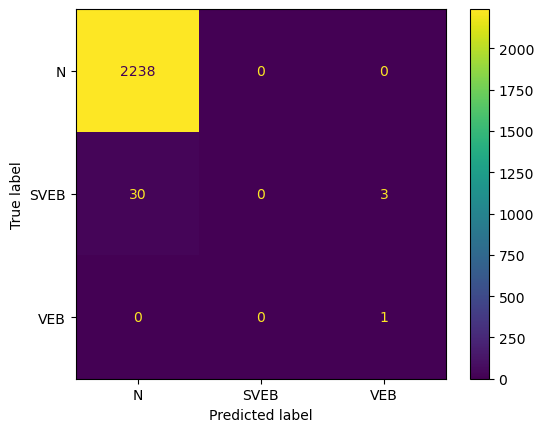

Fold 2:
  Test:  patient=1
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      1859
         1.0       0.00      0.00      0.00         3
         2.0       0.00      0.00      0.00         0

    accuracy                           1.00      1862
   macro avg       0.33      0.33      0.33      1862
weighted avg       1.00      1.00      1.00      1862

                   0.0  1.0  2.0  accuracy    macro avg  weighted avg
precision     0.998388  NaN  0.0  0.997852     0.332796      0.996779
recall        0.999462  0.0  NaN  0.997852     0.333154      0.997852
f1-score      0.998925  NaN  NaN  0.997852     0.332975      0.997315
support    1859.000000  3.0  0.0  0.997852  1862.000000   1862.000000


C:\Users\matte\anaconda3\envs\DMML\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matte\anaconda3\envs\DMML\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matte\anaconda3\envs\DMML\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matte\anaconda3\envs\DMM

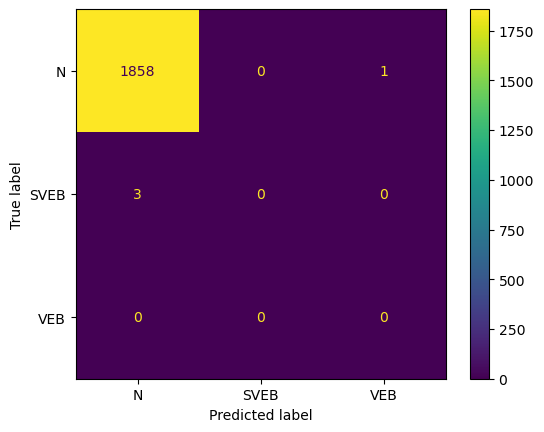

Fold 3:
  Test:  patient=2
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      2081
         1.0       0.00      0.00      0.00         2
         2.0       0.00      0.00      0.00         0

    accuracy                           1.00      2083
   macro avg       0.33      0.33      0.33      2083
weighted avg       1.00      1.00      1.00      2083

                   0.0  1.0  2.0  accuracy    macro avg  weighted avg
precision     1.000000  NaN  0.0   0.99808     0.333333       0.99904
recall        0.999039  0.0  NaN   0.99808     0.333013       0.99808
f1-score      0.999519  NaN  NaN   0.99808     0.333173       0.99856
support    2081.000000  2.0  0.0   0.99808  2083.000000    2083.00000


C:\Users\matte\anaconda3\envs\DMML\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matte\anaconda3\envs\DMML\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matte\anaconda3\envs\DMML\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matte\anaconda3\envs\DMM

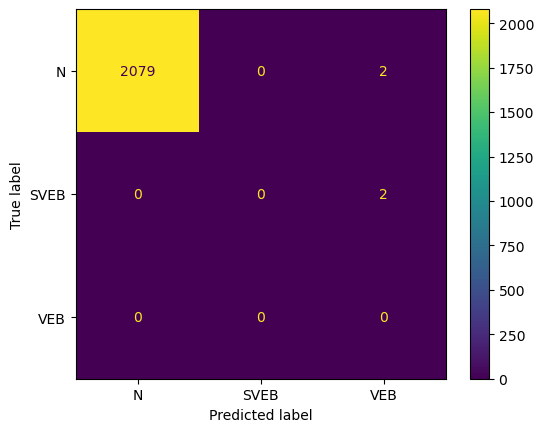

Fold 4:
  Test:  patient=3
              precision    recall  f1-score   support

         0.0       1.00      0.97      0.99      2525
         2.0       0.35      0.95      0.51        41

    accuracy                           0.97      2566
   macro avg       0.68      0.96      0.75      2566
weighted avg       0.99      0.97      0.98      2566

                   0.0        2.0  accuracy    macro avg  weighted avg
precision     0.999185   0.351351  0.971161     0.675268      0.988834
recall        0.971485   0.951220  0.971161     0.961352      0.971161
f1-score      0.985141   0.513158  0.971161     0.749149      0.977599
support    2525.000000  41.000000  0.971161  2566.000000   2566.000000


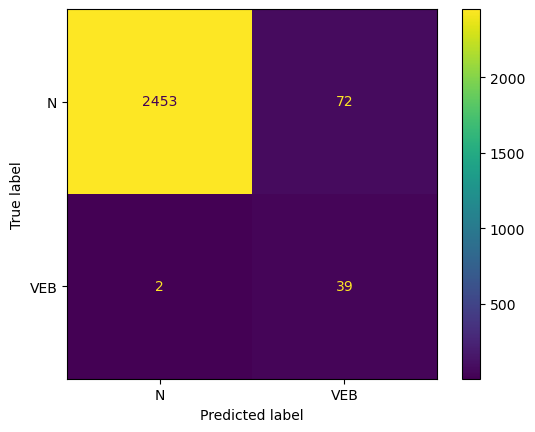

Fold 5:
  Test:  patient=4
              precision    recall  f1-score   support

         0.0       0.84      1.00      0.91      1506
         2.0       1.00      0.44      0.61       520

    accuracy                           0.86      2026
   macro avg       0.92      0.72      0.76      2026
weighted avg       0.88      0.86      0.83      2026

                   0.0         2.0  accuracy    macro avg  weighted avg
precision     0.837597    1.000000  0.855874     0.918799      0.879280
recall        1.000000    0.438462  0.855874     0.719231      0.855874
f1-score      0.911622    0.609626  0.855874     0.760624      0.834111
support    1506.000000  520.000000  0.855874  2026.000000   2026.000000


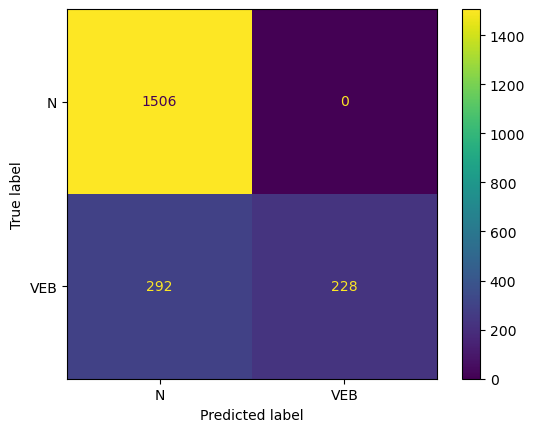

Fold 6:
  Test:  patient=5
              precision    recall  f1-score   support

         0.0       1.00      0.92      0.96      1739
         1.0       0.00      0.00      0.00         4
         2.0       0.07      0.59      0.12        17

    accuracy                           0.92      1760
   macro avg       0.35      0.50      0.36      1760
weighted avg       0.98      0.92      0.95      1760

                   0.0  1.0        2.0  accuracy    macro avg  weighted avg
precision     0.995028  NaN   0.066225  0.915341     0.353751      0.983795
recall        0.920644  0.0   0.588235  0.915341     0.502960      0.915341
f1-score      0.956392  NaN   0.119048  0.915341     0.358480      0.946130
support    1739.000000  4.0  17.000000  0.915341  1760.000000   1760.000000


C:\Users\matte\anaconda3\envs\DMML\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matte\anaconda3\envs\DMML\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matte\anaconda3\envs\DMML\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matte\anaconda3\

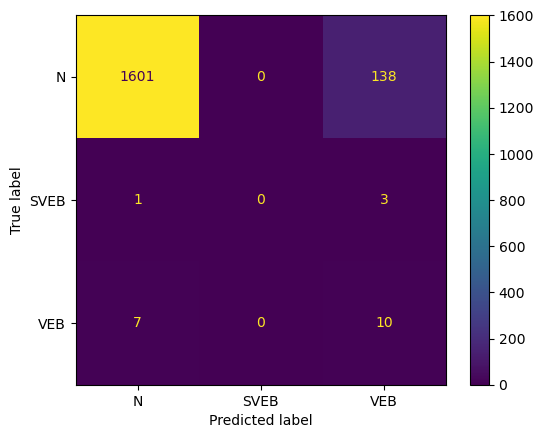

Fold 7:
  Test:  patient=6
              precision    recall  f1-score   support

         0.0       1.00      0.93      0.96      2491
         2.0       0.16      0.87      0.28        38

    accuracy                           0.93      2529
   macro avg       0.58      0.90      0.62      2529
weighted avg       0.99      0.93      0.95      2529

                   0.0        2.0  accuracy    macro avg  weighted avg
precision     0.997851   0.163366  0.931198     0.580609      0.985313
recall        0.932156   0.868421  0.931198     0.900288      0.931198
f1-score      0.963885   0.275000  0.931198     0.619443      0.953534
support    2491.000000  38.000000  0.931198  2529.000000   2529.000000


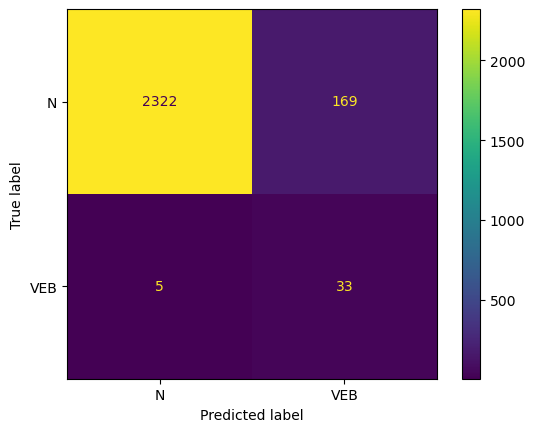

Fold 8:
  Test:  patient=7
              precision    recall  f1-score   support

         0.0       1.00      0.93      0.96      2122
         2.0       0.01      1.00      0.01         1

    accuracy                           0.93      2123
   macro avg       0.50      0.96      0.49      2123
weighted avg       1.00      0.93      0.96      2123

                   0.0       2.0  accuracy    macro avg  weighted avg
precision     1.000000  0.006410   0.92699     0.503205      0.999532
recall        0.926956  1.000000   0.92699     0.963478      0.926990
f1-score      0.962093  0.012739   0.92699     0.487416      0.961646
support    2122.000000  1.000000   0.92699  2123.000000   2123.000000


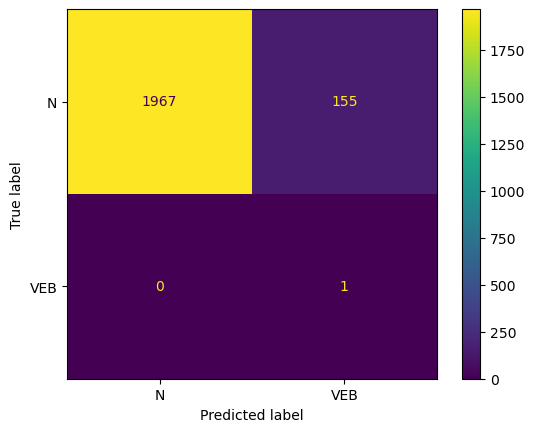

Fold 9:
  Test:  patient=8
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      2536
         1.0       0.00      0.00      0.00         2

    accuracy                           1.00      2538
   macro avg       0.50      0.50      0.50      2538
weighted avg       1.00      1.00      1.00      2538

                   0.0  1.0  accuracy    macro avg  weighted avg
precision     0.999212  NaN  0.999212     0.499606      0.998425
recall        1.000000  0.0  0.999212     0.500000      0.999212
f1-score      0.999606  NaN  0.999212     0.499803      0.998818
support    2536.000000  2.0  0.999212  2538.000000   2538.000000


C:\Users\matte\anaconda3\envs\DMML\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matte\anaconda3\envs\DMML\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matte\anaconda3\envs\DMML\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matte\anaconda3\

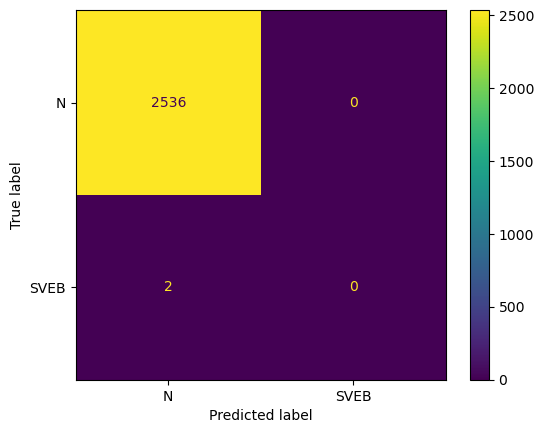

Fold 10:
  Test:  patient=9


C:\Users\matte\anaconda3\envs\DMML\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matte\anaconda3\envs\DMML\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matte\anaconda3\envs\DMML\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matte\anaconda3\envs\DMM

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      1788
         1.0       0.00      0.00      0.00         6
         2.0       0.00      0.00      0.00         0

    accuracy                           1.00      1794
   macro avg       0.33      0.33      0.33      1794
weighted avg       1.00      1.00      1.00      1794

                   0.0  1.0  2.0  accuracy    macro avg  weighted avg
precision     0.998883  NaN  0.0  0.996656     0.332961      0.995542
recall        1.000000  0.0  NaN  0.996656     0.333333      0.996656
f1-score      0.999441  NaN  NaN  0.996656     0.333147      0.996098
support    1788.000000  6.0  0.0  0.996656  1794.000000   1794.000000


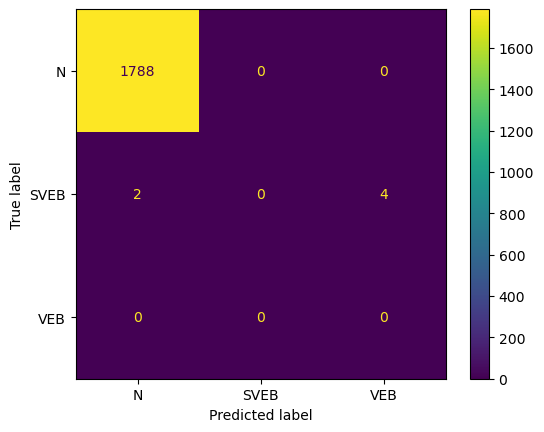

Fold 11:
  Test:  patient=10
              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99      1819
         1.0       0.00      0.00      0.00        12
         2.0       0.65      0.56      0.60        43

    accuracy                           0.98      1874
   macro avg       0.55      0.52      0.53      1874
weighted avg       0.97      0.98      0.97      1874

                   0.0   1.0        2.0  accuracy    macro avg  weighted avg
precision     0.986361   0.0   0.648649  0.977588     0.545003      0.972296
recall        0.993953   0.0   0.558140  0.977588     0.517364      0.977588
f1-score      0.990142   0.0   0.600000  0.977588     0.530047      0.974850
support    1819.000000  12.0  43.000000  0.977588  1874.000000   1874.000000


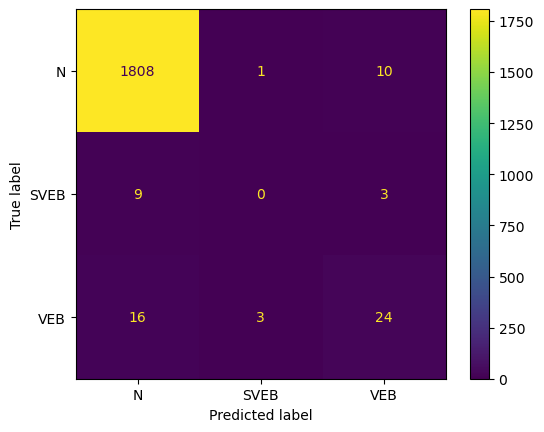

Fold 12:
  Test:  patient=11
              precision    recall  f1-score   support

         0.0       1.00      0.99      1.00      1952
         1.0       0.00      0.00      0.00         0

    accuracy                           0.99      1952
   macro avg       0.50      0.50      0.50      1952
weighted avg       1.00      0.99      1.00      1952

                   0.0  1.0  accuracy    macro avg  weighted avg
precision     1.000000  0.0  0.992828     0.500000      1.000000
recall        0.992828  NaN  0.992828     0.496414      0.992828
f1-score      0.996401  NaN  0.992828     0.498201      0.996401
support    1952.000000  0.0  0.992828  1952.000000   1952.000000


C:\Users\matte\anaconda3\envs\DMML\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matte\anaconda3\envs\DMML\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matte\anaconda3\envs\DMML\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matte\anaconda3\envs\DMML\lib\site-packa

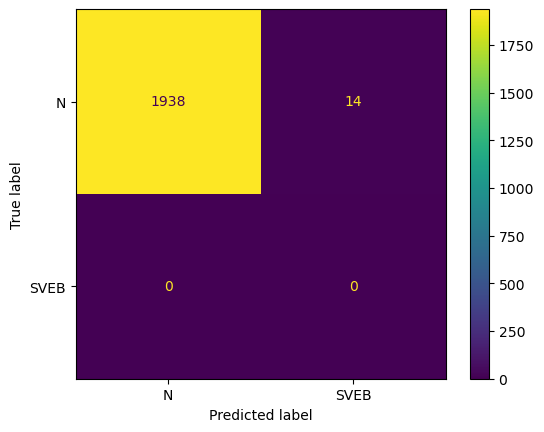

Fold 13:
  Test:  patient=12
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      2301
         1.0       0.33      1.00      0.50         1
         2.0       0.99      0.97      0.98       109

    accuracy                           1.00      2411
   macro avg       0.77      0.99      0.83      2411
weighted avg       1.00      1.00      1.00      2411

                   0.0       1.0         2.0  accuracy    macro avg  \
precision     0.999565  0.333333    0.990654  0.998341     0.774518   
recall        0.999565  1.000000    0.972477  0.998341     0.990681   
f1-score      0.999565  0.500000    0.981481  0.998341     0.827016   
support    2301.000000  1.000000  109.000000  0.998341  2411.000000   

           weighted avg  
precision      0.998886  
recall         0.998341  
f1-score       0.998541  
support     2411.000000  


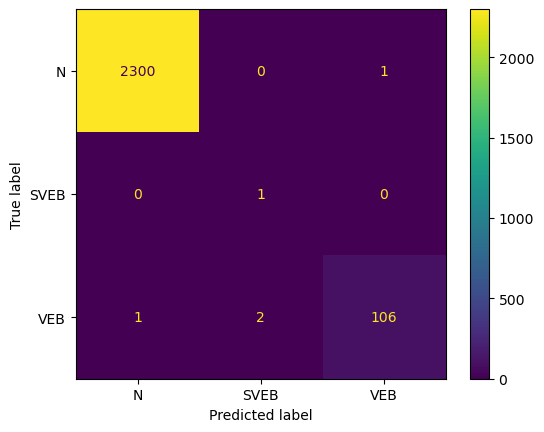

Fold 14:
  Test:  patient=13
              precision    recall  f1-score   support

         0.0       1.00      0.98      0.99      1533
         1.0       0.03      1.00      0.06         1

    accuracy                           0.98      1534
   macro avg       0.51      0.99      0.52      1534
weighted avg       1.00      0.98      0.99      1534

                   0.0       1.0  accuracy    macro avg  weighted avg
precision     1.000000  0.029412  0.978488     0.514706      0.999367
recall        0.978474  1.000000  0.978488     0.989237      0.978488
f1-score      0.989120  0.057143  0.978488     0.523131      0.988512
support    1533.000000  1.000000  0.978488  1534.000000   1534.000000


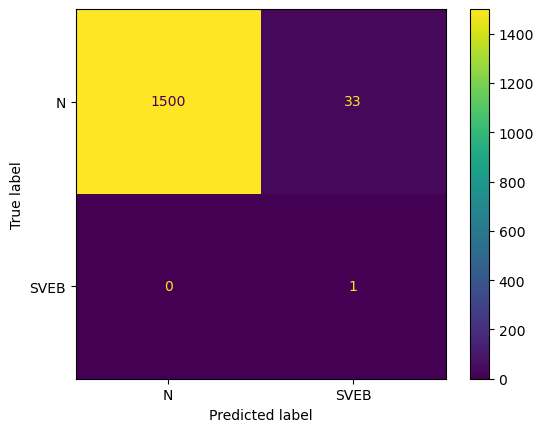

Fold 15:
  Test:  patient=14
              precision    recall  f1-score   support

         0.0       0.97      0.63      0.76      2165
         1.0       0.20      0.01      0.02        96
         2.0       0.01      0.50      0.02        16

    accuracy                           0.60      2277
   macro avg       0.39      0.38      0.27      2277
weighted avg       0.93      0.60      0.73      2277

                   0.0        1.0        2.0  accuracy    macro avg  \
precision     0.966737   0.200000   0.009313  0.603865     0.392017   
recall        0.630947   0.010417   0.500000  0.603865     0.380455   
f1-score      0.763555   0.019802   0.018286  0.603865     0.267214   
support    2165.000000  96.000000  16.000000  0.603865  2277.000000   

           weighted avg  
precision      0.927684  
recall         0.603865  
f1-score       0.726961  
support     2277.000000  


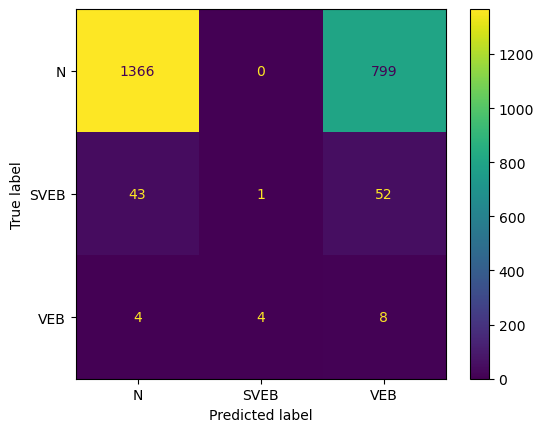

Fold 16:
  Test:  patient=15
              precision    recall  f1-score   support

         0.0       0.97      1.00      0.99      1542
         2.0       1.00      0.90      0.95       444

    accuracy                           0.98      1986
   macro avg       0.99      0.95      0.97      1986
weighted avg       0.98      0.98      0.98      1986

                   0.0         2.0  accuracy    macro avg  weighted avg
precision     0.972257    1.000000  0.977845     0.986129      0.978460
recall        1.000000    0.900901  0.977845     0.950450      0.977845
f1-score      0.985934    0.947867  0.977845     0.966900      0.977423
support    1542.000000  444.000000  0.977845  1986.000000   1986.000000


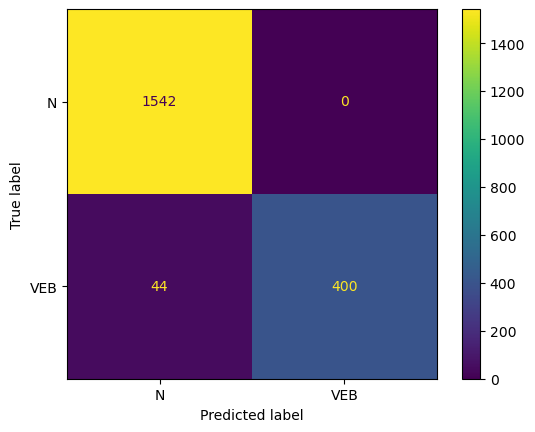

Fold 17:
  Test:  patient=16
              precision    recall  f1-score   support

         0.0       1.00      0.96      0.98      1860
         1.0       0.01      1.00      0.03         1
         2.0       1.00      1.00      1.00         1

    accuracy                           0.96      1862
   macro avg       0.67      0.99      0.67      1862
weighted avg       1.00      0.96      0.98      1862

                   0.0       1.0  2.0  accuracy    macro avg  weighted avg
precision     1.000000  0.013699  1.0  0.961332     0.671233      0.999470
recall        0.961290  1.000000  1.0  0.961332     0.987097      0.961332
f1-score      0.980263  0.027027  1.0  0.961332     0.669097      0.979762
support    1860.000000  1.000000  1.0  0.961332  1862.000000   1862.000000


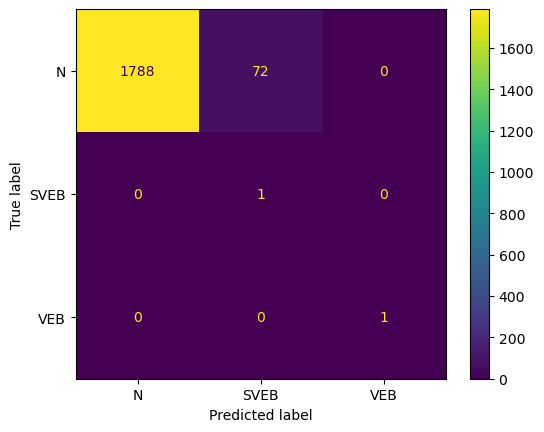

Fold 18:
  Test:  patient=17
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      2475
         1.0       0.00      0.00      0.00         0

    accuracy                           1.00      2475
   macro avg       0.50      0.50      0.50      2475
weighted avg       1.00      1.00      1.00      2475

                   0.0  1.0  accuracy    macro avg  weighted avg
precision     1.000000  0.0  0.998788     0.500000      1.000000
recall        0.998788  NaN  0.998788     0.499394      0.998788
f1-score      0.999394  NaN  0.998788     0.499697      0.999394
support    2475.000000  0.0  0.998788  2475.000000   2475.000000


C:\Users\matte\anaconda3\envs\DMML\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matte\anaconda3\envs\DMML\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matte\anaconda3\envs\DMML\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matte\anaconda3\envs\DMML\lib\site-packa

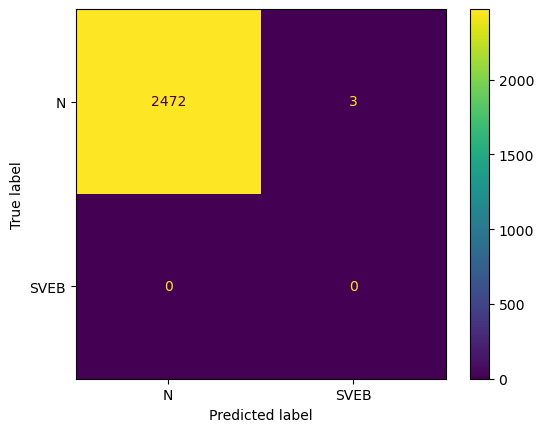

Fold 19:
  Test:  patient=18


C:\Users\matte\anaconda3\envs\DMML\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matte\anaconda3\envs\DMML\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matte\anaconda3\envs\DMML\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matte\anaconda3\envs\DMM

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      1514
         1.0       0.00      0.00      0.00         0
         2.0       0.00      0.00      0.00         3

    accuracy                           0.99      1517
   macro avg       0.33      0.33      0.33      1517
weighted avg       1.00      0.99      0.99      1517

                   0.0  1.0  2.0  accuracy    macro avg  weighted avg
precision     0.998013  0.0  NaN  0.993408     0.332671      0.996040
recall        0.995376  NaN  0.0  0.993408     0.331792      0.993408
f1-score      0.996693  NaN  NaN  0.993408     0.332231      0.994722
support    1514.000000  0.0  3.0  0.993408  1517.000000   1517.000000


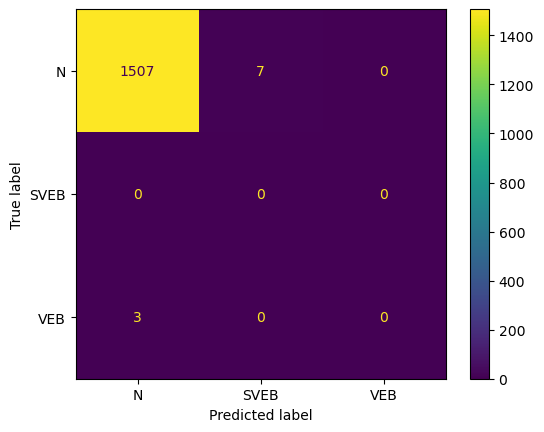

Fold 20:
  Test:  patient=19
              precision    recall  f1-score   support

         0.0       0.97      1.00      0.98      1535
         1.0       0.00      0.00      0.00        31
         2.0       0.92      0.51      0.66        47

    accuracy                           0.97      1613
   macro avg       0.63      0.50      0.55      1613
weighted avg       0.95      0.97      0.96      1613

                   0.0   1.0        2.0  accuracy    macro avg  weighted avg
precision     0.970272   0.0   0.923077  0.965902     0.631116      0.950249
recall        0.999349   0.0   0.510638  0.965902     0.503329      0.965902
f1-score      0.984596   0.0   0.657534  0.965902     0.547377      0.956143
support    1535.000000  31.0  47.000000  0.965902  1613.000000   1613.000000


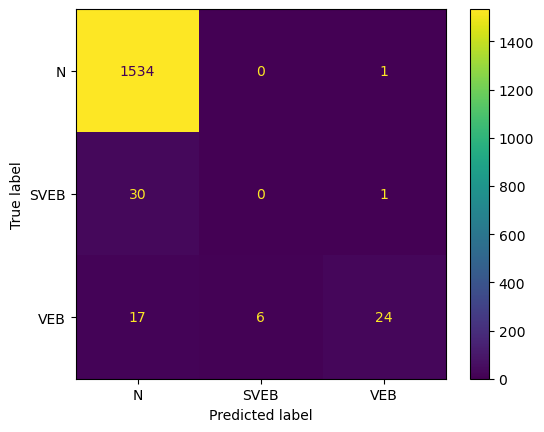

Fold 21:
  Test:  patient=20
              precision    recall  f1-score   support

         0.0       0.95      0.98      0.96      1742
         1.0       0.07      0.10      0.08        30
         2.0       0.98      0.91      0.94       826

    accuracy                           0.94      2598
   macro avg       0.67      0.66      0.66      2598
weighted avg       0.95      0.94      0.95      2598

                   0.0        1.0         2.0  accuracy    macro avg  \
precision     0.952381   0.068182    0.975293  0.944188     0.665285   
recall        0.975890   0.100000    0.907990  0.944188     0.661293   
f1-score      0.963992   0.081081    0.940439  0.944188     0.661837   
support    1742.000000  30.000000  826.000000  0.944188  2598.000000   

           weighted avg  
precision      0.949455  
recall         0.944188  
f1-score       0.946308  
support     2598.000000  


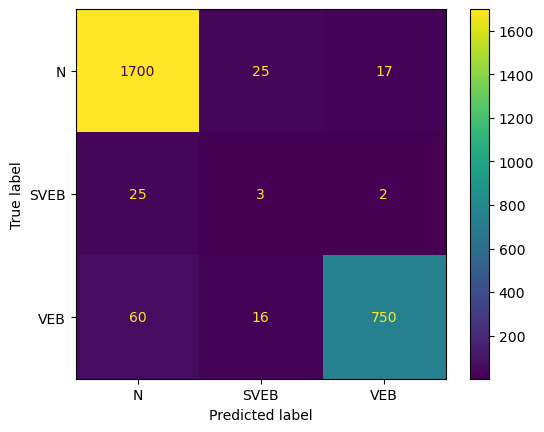

Fold 22:
  Test:  patient=21
              precision    recall  f1-score   support

         0.0       0.88      1.00      0.93      1634
         1.0       0.37      0.12      0.18       128
         2.0       0.02      0.01      0.01       198

    accuracy                           0.84      1960
   macro avg       0.42      0.37      0.37      1960
weighted avg       0.76      0.84      0.79      1960

                   0.0         1.0         2.0  accuracy    macro avg  \
precision     0.876550    0.365854    0.015625  0.837755     0.419343   
recall        0.995104    0.117188    0.005051  0.837755     0.372447   
f1-score      0.932072    0.177515    0.007634  0.837755     0.372407   
support    1634.000000  128.000000  198.000000  0.837755  1960.000000   

           weighted avg  
precision      0.756227  
recall         0.837755  
f1-score       0.789408  
support     1960.000000  


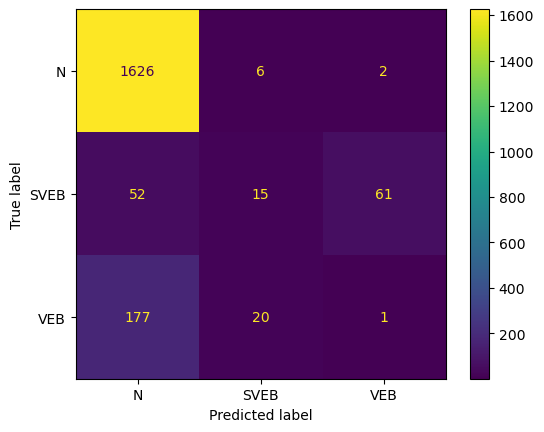

Fold 23:
  Test:  patient=22
              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99      2060
         1.0       0.67      0.33      0.44        55
         2.0       0.39      0.68      0.50        19

    accuracy                           0.98      2134
   macro avg       0.68      0.67      0.64      2134
weighted avg       0.98      0.98      0.97      2134

                   0.0        1.0        2.0  accuracy    macro avg  \
precision     0.989392   0.666667   0.393939  0.976101     0.683333   
recall        0.996117   0.327273   0.684211  0.976101     0.669200   
f1-score      0.992743   0.439024   0.500000  0.976101     0.643922   
support    2060.000000  55.000000  19.000000  0.976101  2134.000000   

           weighted avg  
precision      0.975773  
recall         0.976101  
f1-score       0.974085  
support     2134.000000  


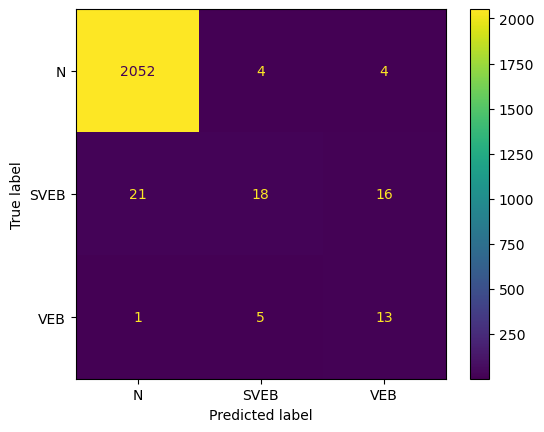

Fold 24:
  Test:  patient=23
              precision    recall  f1-score   support

         0.0       0.98      0.88      0.93      2528
         1.0       0.00      0.00      0.00         2
         2.0       0.60      0.87      0.71       444

    accuracy                           0.88      2974
   macro avg       0.53      0.58      0.55      2974
weighted avg       0.92      0.88      0.89      2974

                   0.0  1.0         2.0  accuracy    macro avg  weighted avg
precision     0.983156  0.0    0.597222  0.875925     0.526793      0.924877
recall        0.877373  0.0    0.871622  0.875925     0.582998      0.875925
f1-score      0.927258  0.0    0.708791  0.875925     0.545350      0.894018
support    2528.000000  2.0  444.000000  0.875925  2974.000000   2974.000000


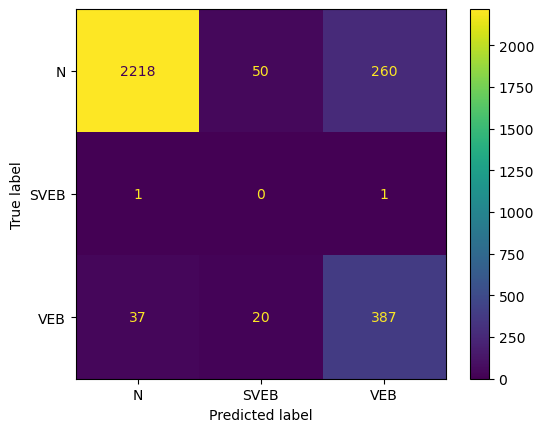

Fold 25:
  Test:  patient=24
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      2570
         1.0       0.43      1.00      0.60         3
         2.0       0.98      0.83      0.90        71

    accuracy                           0.99      2644
   macro avg       0.80      0.94      0.83      2644
weighted avg       1.00      0.99      0.99      2644

                   0.0       1.0        2.0  accuracy    macro avg  \
precision     0.996120  0.428571   0.983333  0.994327     0.802675   
recall        0.998833  1.000000   0.830986  0.994327     0.943273   
f1-score      0.997474  0.600000   0.900763  0.994327     0.832746   
support    2570.000000  3.000000  71.000000  0.994327  2644.000000   

           weighted avg  
precision      0.995132  
recall         0.994327  
f1-score       0.994426  
support     2644.000000  


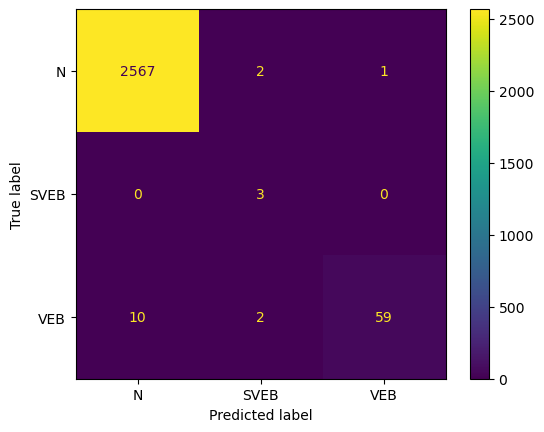

Fold 26:
  Test:  patient=25
              precision    recall  f1-score   support

         0.0       0.63      0.11      0.19      1543
         1.0       0.00      0.00      0.00       106
         2.0       0.07      0.50      0.12       210

    accuracy                           0.15      1859
   macro avg       0.23      0.21      0.10      1859
weighted avg       0.53      0.15      0.17      1859

                   0.0    1.0         2.0  accuracy    macro avg  weighted avg
precision     0.629496    0.0    0.067089  0.151157     0.232195      0.530071
recall        0.113415    0.0    0.504762  0.151157     0.206059      0.151157
f1-score      0.192202    0.0    0.118436  0.151157     0.103546      0.172910
support    1543.000000  106.0  210.000000  0.151157  1859.000000   1859.000000


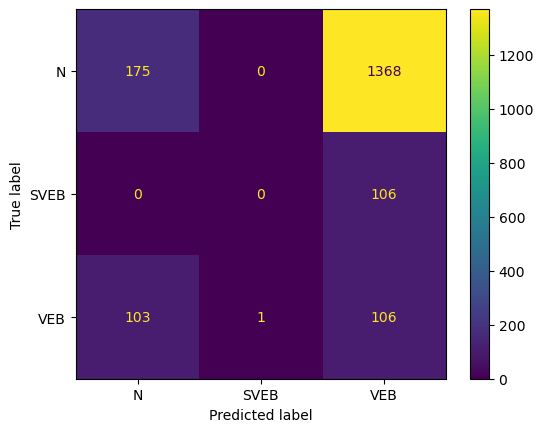

Fold 27:
  Test:  patient=26
              precision    recall  f1-score   support

         0.0       0.70      1.00      0.82      1585
         1.0       0.00      0.00      0.00         2
         2.0       1.00      0.29      0.45       992

    accuracy                           0.73      2579
   macro avg       0.57      0.43      0.42      2579
weighted avg       0.82      0.73      0.68      2579

                   0.0  1.0         2.0  accuracy    macro avg  weighted avg
precision     0.700265  0.0    1.000000  0.725087     0.566755      0.815014
recall        0.999369  0.0    0.288306  0.725087     0.429225      0.725087
f1-score      0.823499  0.0    0.447574  0.725087     0.423691      0.678263
support    1585.000000  2.0  992.000000  0.725087  2579.000000   2579.000000


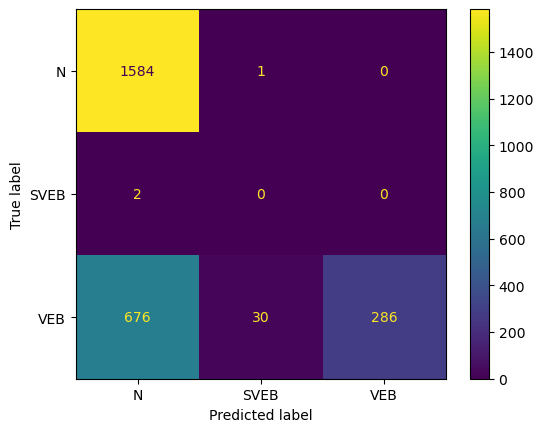

Fold 28:
  Test:  patient=27
              precision    recall  f1-score   support

         0.0       0.90      1.00      0.94      2620
         1.0       1.00      0.05      0.10       383
         2.0       0.02      1.00      0.03         1

    accuracy                           0.88      3004
   macro avg       0.64      0.68      0.36      3004
weighted avg       0.91      0.88      0.84      3004

                   0.0         1.0       2.0  accuracy    macro avg  \
precision     0.895349    1.000000  0.016667  0.878495     0.637339   
recall        0.999237    0.052219  1.000000  0.878495     0.683819   
f1-score      0.944444    0.099256  0.032787  0.878495     0.358829   
support    2620.000000  383.000000  1.000000  0.878495  3004.000000   

           weighted avg  
precision      0.908399  
recall         0.878495  
f1-score       0.836382  
support     3004.000000  


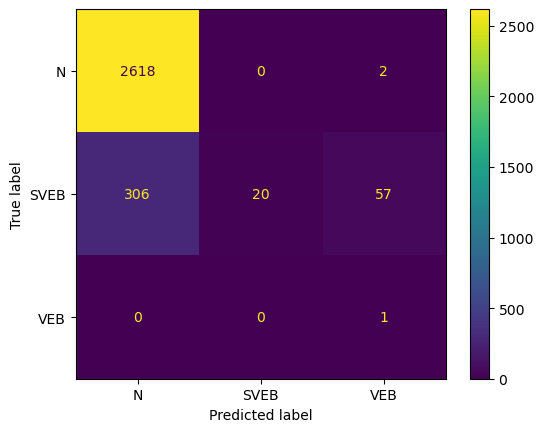

Fold 29:
  Test:  patient=28
              precision    recall  f1-score   support

         0.0       0.97      0.98      0.98      2422
         1.0       0.21      0.64      0.32        22
         2.0       0.91      0.66      0.76       195

    accuracy                           0.95      2639
   macro avg       0.70      0.76      0.69      2639
weighted avg       0.96      0.95      0.96      2639

                   0.0        1.0         2.0  accuracy    macro avg  \
precision     0.974928   0.212121    0.914286  0.952634     0.700445   
recall        0.979356   0.636364    0.656410  0.952634     0.757377   
f1-score      0.977137   0.318182    0.764179  0.952634     0.686499   
support    2422.000000  22.000000  195.000000  0.952634  2639.000000   

           weighted avg  
precision      0.964088  
recall         0.952634  
f1-score       0.955908  
support     2639.000000  


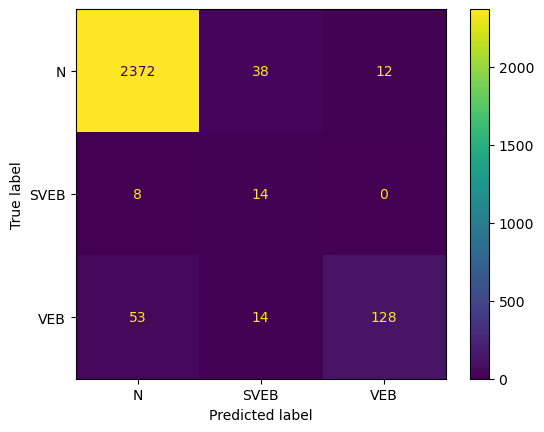

Fold 30:
  Test:  patient=29


C:\Users\matte\anaconda3\envs\DMML\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matte\anaconda3\envs\DMML\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matte\anaconda3\envs\DMML\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matte\anaconda3\envs\DMML\lib\site-packa

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      2747
         1.0       0.00      0.00      0.00         0
         2.0       0.00      0.00      0.00         0

    accuracy                           1.00      2747
   macro avg       0.33      0.33      0.33      2747
weighted avg       1.00      1.00      1.00      2747

                   0.0  1.0  2.0  accuracy    macro avg  weighted avg
precision     1.000000  0.0  0.0  0.997816     0.333333      1.000000
recall        0.997816  NaN  NaN  0.997816     0.332605      0.997816
f1-score      0.998907  NaN  NaN  0.997816     0.332969      0.998907
support    2747.000000  0.0  0.0  0.997816  2747.000000   2747.000000


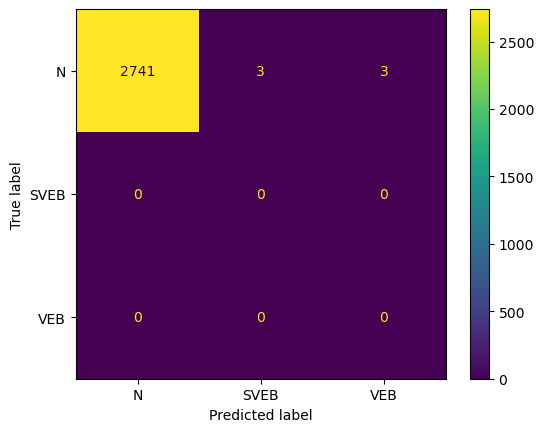

Fold 31:
  Test:  patient=30
              precision    recall  f1-score   support

         0.0       1.00      0.91      0.95      2640
         1.0       0.50      0.04      0.07        28
         2.0       0.46      1.00      0.63       220

    accuracy                           0.91      2888
   macro avg       0.65      0.65      0.55      2888
weighted avg       0.95      0.91      0.92      2888

                   0.0        1.0         2.0  accuracy    macro avg  \
precision     0.999169   0.500000    0.456250  0.908587     0.651806   
recall        0.910606   0.035714    0.995455  0.908587     0.647258   
f1-score      0.952834   0.066667    0.625714  0.908587     0.548405   
support    2640.000000  28.000000  220.000000  0.908587  2888.000000   

           weighted avg  
precision      0.952971  
recall         0.908587  
f1-score       0.919323  
support     2888.000000  


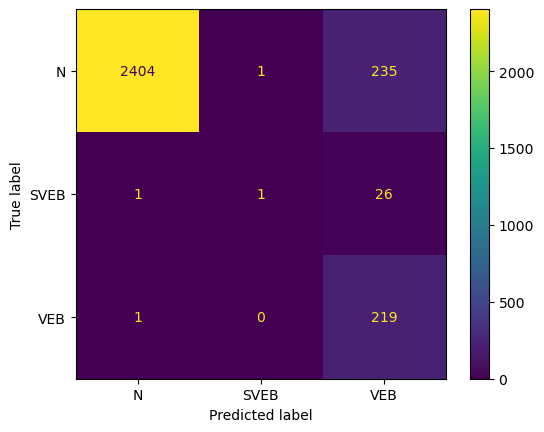

Fold 32:
  Test:  patient=31
              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99      2002
         1.0       0.00      0.00      0.00         0
         2.0       0.93      0.83      0.88       256

    accuracy                           0.97      2258
   macro avg       0.64      0.61      0.62      2258
weighted avg       0.98      0.97      0.98      2258

                   0.0  1.0         2.0  accuracy    macro avg  weighted avg
precision     0.987071  0.0    0.930131  0.973428     0.639067      0.980616
recall        0.991508  NaN    0.832031  0.973428     0.607847      0.973428
f1-score      0.989285  NaN    0.878351  0.973428     0.622545      0.976708
support    2002.000000  0.0  256.000000  0.973428  2258.000000   2258.000000


C:\Users\matte\anaconda3\envs\DMML\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matte\anaconda3\envs\DMML\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matte\anaconda3\envs\DMML\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matte\anaconda3\envs\DMML\lib\site-packa

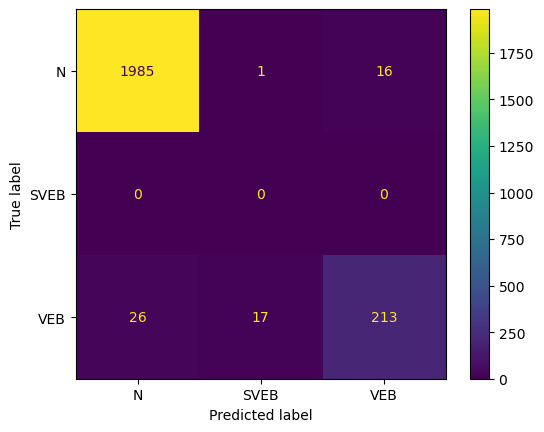

Fold 33:
  Test:  patient=32
              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99      3194
         1.0       0.11      1.00      0.19         3
         2.0       0.99      0.80      0.89       164

    accuracy                           0.98      3361
   macro avg       0.70      0.93      0.69      3361
weighted avg       0.99      0.98      0.99      3361

                   0.0       1.0         2.0  accuracy    macro avg  \
precision     0.991253  0.107143    0.992424  0.983933     0.696940   
recall        0.993425  1.000000    0.798780  0.983933     0.930735   
f1-score      0.992338  0.193548    0.885135  0.983933     0.690340   
support    3194.000000  3.000000  164.000000  0.983933  3361.000000   

           weighted avg  
precision      0.990521  
recall         0.983933  
f1-score       0.986394  
support     3361.000000  


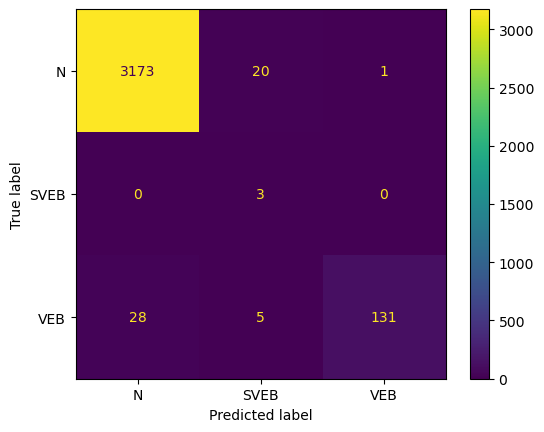

Fold 34:
  Test:  patient=33
              precision    recall  f1-score   support

         0.0       0.99      0.98      0.98      2081
         1.0       0.00      0.00      0.00         7
         2.0       0.51      0.73      0.60        64

    accuracy                           0.96      2152
   macro avg       0.50      0.57      0.53      2152
weighted avg       0.97      0.96      0.97      2152

                   0.0  1.0        2.0  accuracy    macro avg  weighted avg
precision     0.988310  0.0   0.510870  0.964684     0.499726      0.970896
recall        0.975012  0.0   0.734375  0.964684     0.569796      0.964684
f1-score      0.981616  0.0   0.602564  0.964684     0.528060      0.967150
support    2081.000000  7.0  64.000000  0.964684  2152.000000   2152.000000


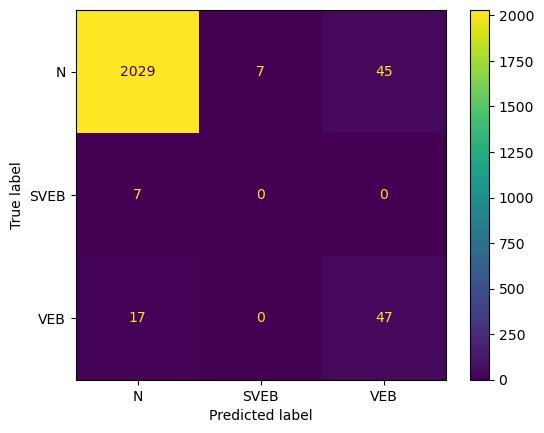

Fold 35:
  Test:  patient=34
              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99      1953
         1.0       0.97      0.79      0.87        94
         2.0       0.00      0.00      0.00         0

    accuracy                           0.99      2047
   macro avg       0.65      0.60      0.62      2047
weighted avg       0.99      0.99      0.99      2047

                   0.0        1.0  2.0  accuracy    macro avg  weighted avg
precision     0.990355   0.973684  0.0  0.989253     0.654680      0.989590
recall        0.998976   0.787234  NaN  0.989253     0.595403      0.989253
f1-score      0.994647   0.870588  NaN  0.989253     0.621745      0.988950
support    1953.000000  94.000000  0.0  0.989253  2047.000000   2047.000000


C:\Users\matte\anaconda3\envs\DMML\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matte\anaconda3\envs\DMML\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matte\anaconda3\envs\DMML\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matte\anaconda3\envs\DMML\lib\site-packa

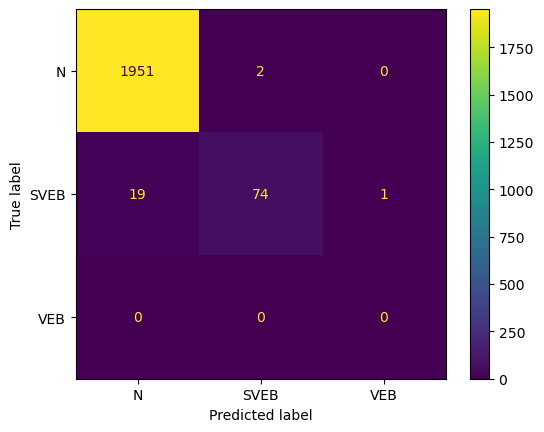

Fold 36:
  Test:  patient=35
              precision    recall  f1-score   support

         0.0       0.98      0.99      0.99      2030
         1.0       0.00      0.00      0.00         0
         2.0       0.99      0.92      0.96       396

    accuracy                           0.98      2426
   macro avg       0.66      0.64      0.65      2426
weighted avg       0.99      0.98      0.98      2426

                   0.0  1.0         2.0  accuracy    macro avg  weighted avg
precision     0.984841  0.0    0.994550  0.980627     0.659797      0.986426
recall        0.992118  NaN    0.921717  0.980627     0.637945      0.980627
f1-score      0.988466  NaN    0.956750  0.980627     0.648405      0.983289
support    2030.000000  0.0  396.000000  0.980627  2426.000000   2426.000000


C:\Users\matte\anaconda3\envs\DMML\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matte\anaconda3\envs\DMML\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matte\anaconda3\envs\DMML\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matte\anaconda3\envs\DMML\lib\site-packa

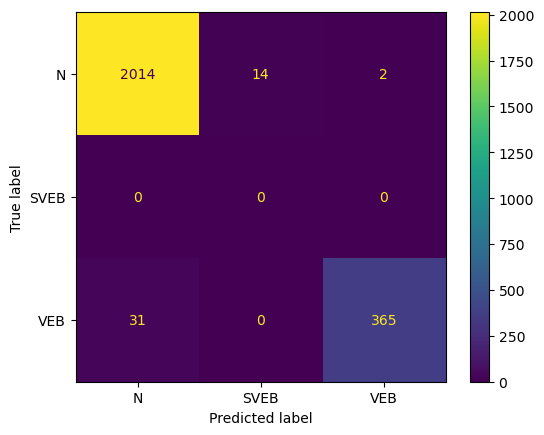

Fold 37:
  Test:  patient=36
              precision    recall  f1-score   support

         0.0       0.94      0.98      0.96      2273
         1.0       0.62      0.29      0.39       209
         2.0       0.00      0.00      0.00         0

    accuracy                           0.93      2482
   macro avg       0.52      0.42      0.45      2482
weighted avg       0.91      0.93      0.91      2482

                   0.0         1.0  2.0  accuracy    macro avg  weighted avg
precision     0.940706    0.625000  0.0  0.925463     0.521902      0.914122
recall        0.984162    0.287081  NaN  0.925463     0.423748      0.925463
f1-score      0.961944    0.393443  NaN  0.925463     0.451795      0.914072
support    2273.000000  209.000000  0.0  0.925463  2482.000000   2482.000000


C:\Users\matte\anaconda3\envs\DMML\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matte\anaconda3\envs\DMML\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matte\anaconda3\envs\DMML\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matte\anaconda3\envs\DMML\lib\site-packa

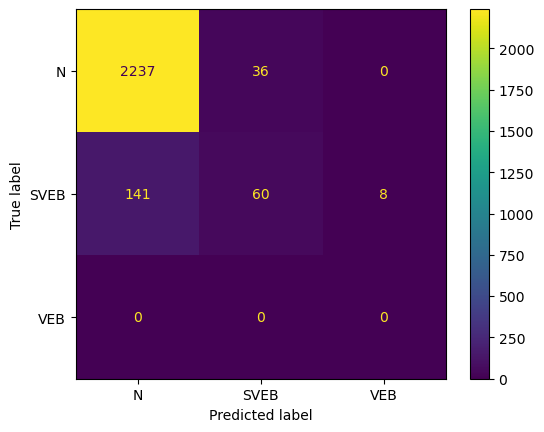

Fold 38:
  Test:  patient=37
              precision    recall  f1-score   support

         0.0       0.91      1.00      0.95      2044
         1.0       0.00      0.00      0.00        73
         2.0       0.97      0.70      0.81       473

    accuracy                           0.92      2590
   macro avg       0.63      0.57      0.59      2590
weighted avg       0.89      0.92      0.90      2590

                   0.0   1.0         2.0  accuracy    macro avg  weighted avg
precision     0.908767   0.0    0.970588   0.91583     0.626452      0.894443
recall        0.999022   0.0    0.697674   0.91583     0.565565      0.915830
f1-score      0.951759   0.0    0.811808   0.91583     0.587856      0.899375
support    2044.000000  73.0  473.000000   0.91583  2590.000000   2590.000000


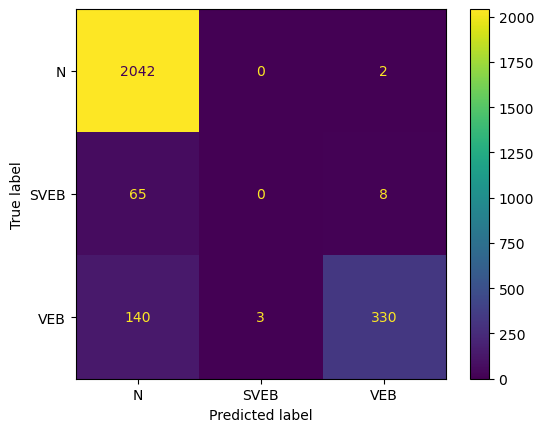

Fold 39:
  Test:  patient=38
              precision    recall  f1-score   support

         0.0       0.94      0.97      0.95      1687
         1.0       0.01      0.33      0.02         3
         2.0       1.00      0.63      0.77       362

    accuracy                           0.91      2052
   macro avg       0.65      0.65      0.58      2052
weighted avg       0.95      0.91      0.92      2052

                   0.0       1.0         2.0  accuracy    macro avg  \
precision     0.939655  0.012048    1.000000  0.908869     0.650568   
recall        0.969176  0.333333    0.632597  0.908869     0.645035   
f1-score      0.954187  0.023256    0.774958  0.908869     0.584134   
support    1687.000000  3.000000  362.000000  0.908869  2052.000000   

           weighted avg  
precision      0.948945  
recall         0.908869  
f1-score       0.921208  
support     2052.000000  


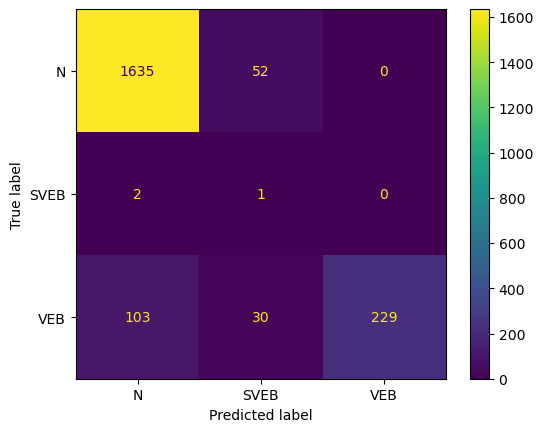

Fold 40:
  Test:  patient=39


C:\Users\matte\anaconda3\envs\DMML\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matte\anaconda3\envs\DMML\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matte\anaconda3\envs\DMML\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matte\anaconda3\envs\DMML\lib\site-packa

              precision    recall  f1-score   support

         0.0       1.00      0.89      0.94      2254
         1.0       0.00      0.00      0.00         0
         2.0       0.01      1.00      0.01         1

    accuracy                           0.89      2255
   macro avg       0.34      0.63      0.32      2255
weighted avg       1.00      0.89      0.94      2255

                   0.0  1.0       2.0  accuracy    macro avg  weighted avg
precision     1.000000  0.0  0.006098  0.888248     0.335366      0.999559
recall        0.888199  NaN  1.000000  0.888248     0.629400      0.888248
f1-score      0.940789  NaN  0.012121  0.888248     0.317637      0.940378
support    2254.000000  0.0  1.000000  0.888248  2255.000000   2255.000000


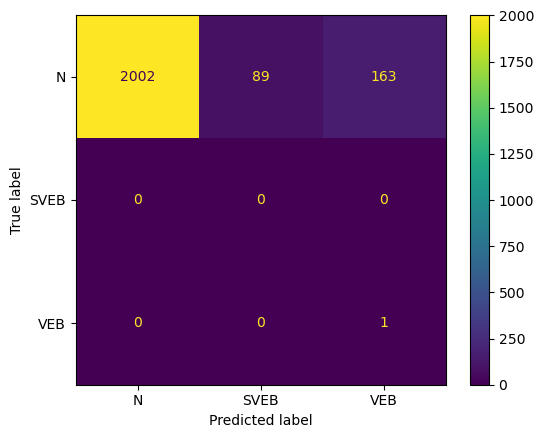

Fold 41:
  Test:  patient=40
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      1567
         1.0       0.50      1.00      0.67         1
         2.0       1.00      0.50      0.67         2

    accuracy                           1.00      1570
   macro avg       0.83      0.83      0.78      1570
weighted avg       1.00      1.00      1.00      1570

                   0.0       1.0       2.0  accuracy    macro avg  \
precision     0.999362  0.500000  1.000000  0.998726     0.833121   
recall        0.999362  1.000000  0.500000  0.998726     0.833121   
f1-score      0.999362  0.666667  0.666667  0.998726     0.777565   
support    1567.000000  1.000000  2.000000  0.998726  1570.000000   

           weighted avg  
precision      0.999045  
recall         0.998726  
f1-score       0.998726  
support     1570.000000  


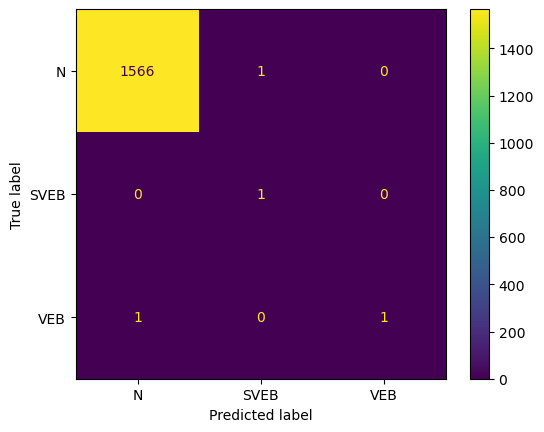

Fold 42:
  Test:  patient=41
              precision    recall  f1-score   support

         0.0       0.22      1.00      0.37       398
         1.0       1.00      0.00      0.00      1381

    accuracy                           0.22      1779
   macro avg       0.61      0.50      0.18      1779
weighted avg       0.83      0.22      0.08      1779

                  0.0          1.0  accuracy    macro avg  weighted avg
precision    0.223973     1.000000  0.224845     0.611986      0.826386
recall       1.000000     0.001448  0.224845     0.500724      0.224845
f1-score     0.365977     0.002892  0.224845     0.184435      0.084122
support    398.000000  1381.000000  0.224845  1779.000000   1779.000000


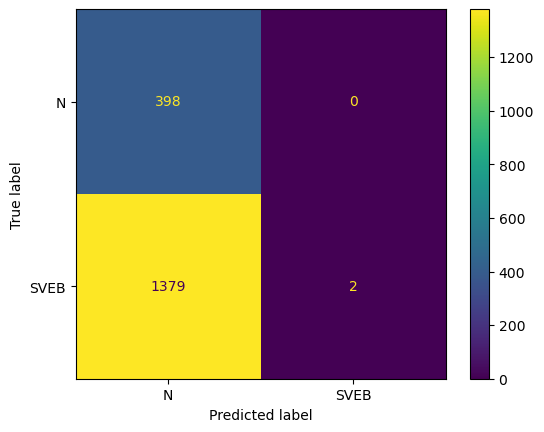

Fold 43:
  Test:  patient=42
              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96      2229
         1.0       0.01      0.71      0.01         7
         2.0       1.00      0.00      0.01       831

    accuracy                           0.73      3067
   macro avg       0.64      0.57      0.33      3067
weighted avg       0.94      0.73      0.70      3067

                   0.0       1.0         2.0  accuracy    macro avg  \
precision     0.924261  0.007576    1.000000  0.727095     0.643946   
recall        0.996411  0.714286    0.004813  0.727095     0.571837   
f1-score      0.958981  0.014993    0.009581  0.727095     0.327851   
support    2229.000000  7.000000  831.000000  0.727095  3067.000000   

           weighted avg  
precision      0.942690  
recall         0.727095  
f1-score       0.699588  
support     3067.000000  


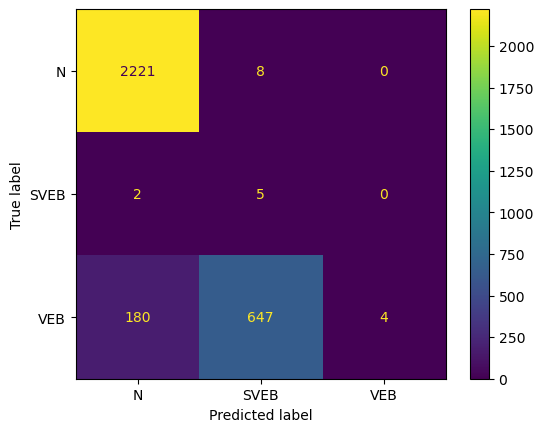

Fold 44:
  Test:  patient=43
              precision    recall  f1-score   support

         0.0       1.00      0.98      0.99      2699
         1.0       0.48      0.90      0.63        50
         2.0       1.00      1.00      1.00         3

    accuracy                           0.98      2752
   macro avg       0.83      0.96      0.87      2752
weighted avg       0.99      0.98      0.98      2752

                   0.0        1.0  2.0  accuracy    macro avg  weighted avg
precision     0.998117   0.483871  1.0  0.980741     0.827329      0.988776
recall        0.982216   0.900000  1.0  0.980741     0.960739      0.980741
f1-score      0.990103   0.629371  1.0  0.980741     0.873158      0.983559
support    2699.000000  50.000000  3.0  0.980741  2752.000000   2752.000000


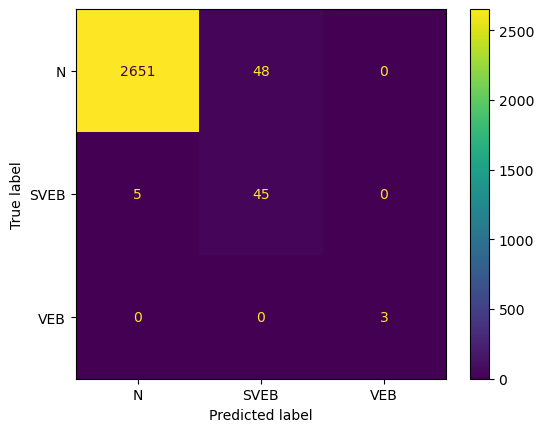

C:\Users\matte\anaconda3\envs\DMML\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\matte\anaconda3\envs\DMML\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [7]:
from sklearn.model_selection import LeaveOneGroupOut
import time
X=df_cardio.drop('type',axis=1)
y=df_cardio['type']
groups=df_cardio['patient']
skf = LeaveOneGroupOut()


start_time=time.time()
df_normal, acc_normal,confusion_matrix_final,list_fscore = cross_valid(pipe_normal, skf, X, y,groups)
end_time=time.time()

In [8]:
df_normal

0.0        1.0         2.0    macro avg  weighted avg
f1-score      0.936992   0.199248    0.555593     0.530120      0.903151
precision     0.944991   0.228096    0.532458     0.572958      0.950571
recall        0.952568   0.321955    0.701675     0.627662      0.902955
support    2047.340909  71.256410  179.717949  2269.795455   2269.795455

In [9]:
print("Time"+str(end_time-start_time))

Time883.647524356842


In [10]:
confusion_matrix_final

array([[86064.,   934.,  3085.],
       [ 2499.,   970.,   354.],
       [ 1692.,   825.,  3448.]])

In [11]:
list_fscore

{'patient0': {'0.0': 0.9933422103861518,
  '2.0': 0.4,
  'macro avg': 0.46444740346205055,
  'weighted avg': 0.9786531104067815},
 'patient1': {'0.0': 0.9989247311827956,
  'macro avg': 0.3329749103942652,
  'weighted avg': 0.9973152928403958},
 'patient2': {'0.0': 0.9995192307692308,
  'macro avg': 0.3331730769230769,
  'weighted avg': 0.9985595387569703},
 'patient3': {'0.0': 0.9851405622489959,
  '2.0': 0.5131578947368421,
  'macro avg': 0.7491492284929191,
  'weighted avg': 0.9775991400479054},
 'patient4': {'0.0': 0.9116222760290557,
  '2.0': 0.6096256684491979,
  'macro avg': 0.7606239722391268,
  'weighted avg': 0.8341108071536726},
 'patient5': {'0.0': 0.9563918757467144,
  '2.0': 0.11904761904761905,
  'macro avg': 0.3584798315981111,
  'weighted avg': 0.9461302735496283},
 'patient6': {'0.0': 0.9638854296388543,
  '2.0': 0.275,
  'macro avg': 0.6194427148194271,
  'weighted avg': 0.9535344425584761},
 'patient7': {'0.0': 0.9620934213744192,
  '2.0': 0.012738853503184714,
  'm

In [14]:
pipe_smote = Pipeline([
        ('sampling', SMOTE(random_state = 123)),
        ('classification', AdaBoostClassifier())
    ])
pipe_smote

Pipeline(steps=[('sampling', SMOTE(random_state=123)),
                ('classification', AdaBoostClassifier())])

Fold 1:
  Test:  patient=0
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      2238
         1.0       0.74      0.94      0.83        33
         2.0       0.33      1.00      0.50         1

    accuracy                           0.99      2272
   macro avg       0.69      0.98      0.77      2272
weighted avg       1.00      0.99      0.99      2272

                   0.0        1.0       2.0  accuracy    macro avg  \
precision     1.000000   0.738095  0.333333  0.994278     0.690476   
recall        0.995085   0.939394  1.000000  0.994278     0.978160   
f1-score      0.997536   0.826667  0.500000  0.994278     0.774734   
support    2238.000000  33.000000  1.000000  0.994278  2272.000000   

           weighted avg  
precision      0.995902  
recall         0.994278  
f1-score       0.994836  
support     2272.000000  


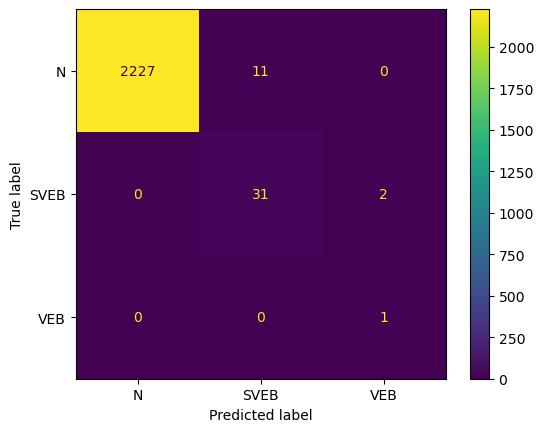

Fold 2:
  Test:  patient=1
              precision    recall  f1-score   support

         0.0       1.00      0.98      0.99      1859
         1.0       0.03      0.33      0.06         3
         2.0       0.00      0.00      0.00         0

    accuracy                           0.98      1862
   macro avg       0.34      0.44      0.35      1862
weighted avg       1.00      0.98      0.99      1862

                   0.0       1.0  2.0  accuracy    macro avg  weighted avg
precision     0.999452  0.032258  0.0  0.980129     0.343903      0.997894
recall        0.981173  0.333333  NaN  0.980129     0.438169      0.980129
f1-score      0.990228  0.058824  NaN  0.980129     0.349684      0.988727
support    1859.000000  3.000000  0.0  0.980129  1862.000000   1862.000000


C:\Users\matte\anaconda3\envs\DMML\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matte\anaconda3\envs\DMML\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matte\anaconda3\envs\DMML\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matte\anaconda3\envs\DMML\lib\site-packa

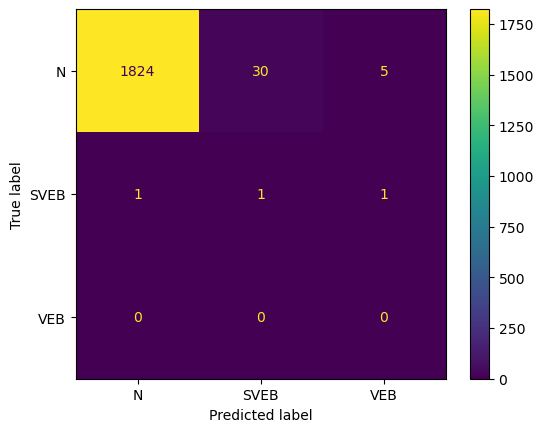

Fold 3:
  Test:  patient=2


C:\Users\matte\anaconda3\envs\DMML\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matte\anaconda3\envs\DMML\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matte\anaconda3\envs\DMML\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matte\anaconda3\envs\DMML\lib\site-packa

              precision    recall  f1-score   support

         0.0       1.00      0.99      1.00      2081
         1.0       0.08      0.50      0.13         2
         2.0       0.00      0.00      0.00         0

    accuracy                           0.99      2083
   macro avg       0.36      0.50      0.38      2083
weighted avg       1.00      0.99      0.99      2083

                   0.0       1.0  2.0  accuracy    macro avg  weighted avg
precision     1.000000  0.076923  0.0  0.990398     0.358974      0.999114
recall        0.990870  0.500000  NaN  0.990398     0.496957      0.990398
f1-score      0.995414  0.133333  NaN  0.990398     0.376249      0.994586
support    2081.000000  2.000000  0.0  0.990398  2083.000000   2083.000000


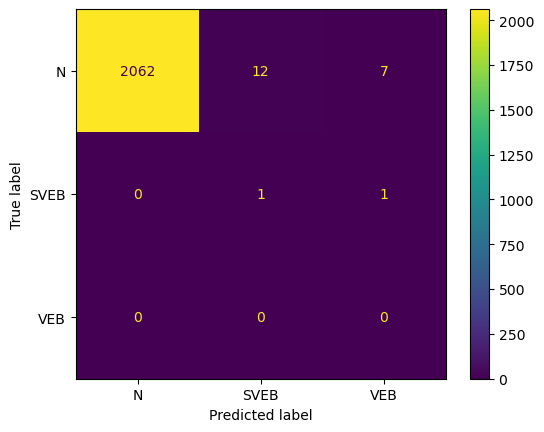

Fold 4:
  Test:  patient=3
              precision    recall  f1-score   support

         0.0       1.00      0.92      0.96      2525
         1.0       0.00      0.00      0.00         0
         2.0       0.18      1.00      0.30        41

    accuracy                           0.92      2566
   macro avg       0.39      0.64      0.42      2566
weighted avg       0.99      0.92      0.95      2566

                   0.0  1.0        2.0  accuracy    macro avg  weighted avg
precision     1.000000  0.0   0.177489  0.922837     0.392496      0.986858
recall        0.921584  NaN   1.000000  0.922837     0.640528      0.922837
f1-score      0.959192  NaN   0.301471  0.922837     0.420221      0.948683
support    2525.000000  0.0  41.000000  0.922837  2566.000000   2566.000000


C:\Users\matte\anaconda3\envs\DMML\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matte\anaconda3\envs\DMML\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matte\anaconda3\envs\DMML\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matte\anaconda3\envs\DMML\lib\site-packa

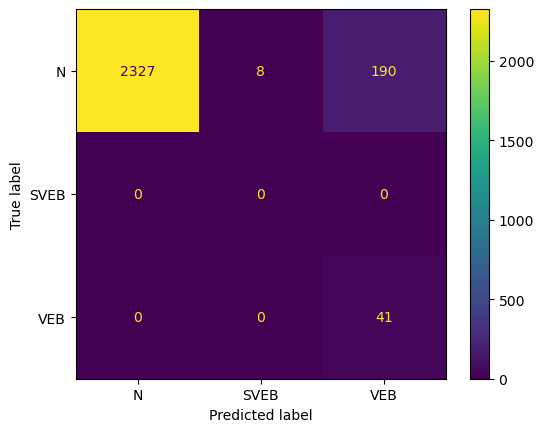

Fold 5:
  Test:  patient=4
              precision    recall  f1-score   support

         0.0       0.90      1.00      0.95      1506
         1.0       0.00      0.00      0.00         0
         2.0       1.00      0.66      0.80       520

    accuracy                           0.91      2026
   macro avg       0.63      0.55      0.58      2026
weighted avg       0.93      0.91      0.91      2026

                   0.0  1.0         2.0  accuracy    macro avg  weighted avg
precision     0.901796  0.0    1.000000  0.913623     0.633932      0.927002
recall        1.000000  NaN    0.663462  0.913623     0.554487      0.913623
f1-score      0.948363  NaN    0.797688  0.913623     0.582017      0.909690
support    1506.000000  0.0  520.000000  0.913623  2026.000000   2026.000000


C:\Users\matte\anaconda3\envs\DMML\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matte\anaconda3\envs\DMML\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matte\anaconda3\envs\DMML\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matte\anaconda3\envs\DMML\lib\site-packa

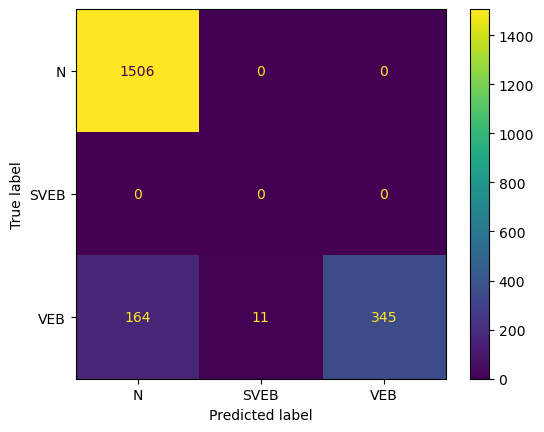

Fold 6:
  Test:  patient=5
              precision    recall  f1-score   support

         0.0       1.00      0.80      0.89      1739
         1.0       0.00      0.00      0.00         4
         2.0       0.03      0.65      0.06        17

    accuracy                           0.80      1760
   macro avg       0.34      0.48      0.32      1760
weighted avg       0.99      0.80      0.88      1760

                   0.0  1.0        2.0  accuracy    macro avg  weighted avg
precision     0.999281  0.0   0.030387  0.796023     0.343223      0.987651
recall        0.799310  0.0   0.647059  0.796023     0.482123      0.796023
f1-score      0.888179  0.0   0.058047  0.796023     0.315409      0.878142
support    1739.000000  4.0  17.000000  0.796023  1760.000000   1760.000000


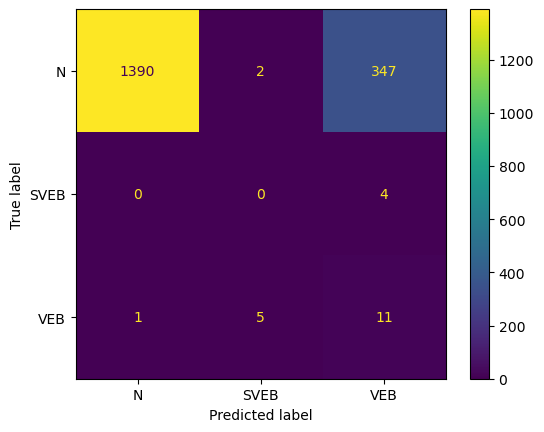

Fold 7:
  Test:  patient=6
              precision    recall  f1-score   support

         0.0       1.00      0.69      0.81      2491
         1.0       0.00      0.00      0.00         0
         2.0       0.04      0.89      0.08        38

    accuracy                           0.69      2529
   macro avg       0.35      0.53      0.30      2529
weighted avg       0.99      0.69      0.80      2529

                   0.0  1.0        2.0  accuracy    macro avg  weighted avg
precision     0.999416  0.0   0.042875  0.689996     0.347430      0.985043
recall        0.686873  NaN   0.894737  0.689996     0.527203      0.689996
f1-score      0.814180  NaN   0.081829  0.689996     0.298670      0.803176
support    2491.000000  0.0  38.000000  0.689996  2529.000000   2529.000000


C:\Users\matte\anaconda3\envs\DMML\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matte\anaconda3\envs\DMML\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matte\anaconda3\envs\DMML\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matte\anaconda3\envs\DMML\lib\site-packa

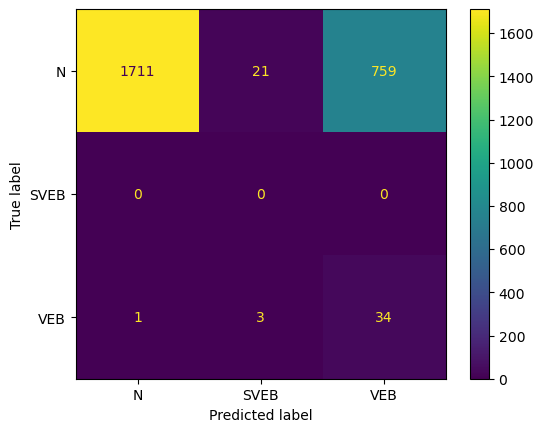

Fold 8:
  Test:  patient=7
              precision    recall  f1-score   support

         0.0       1.00      0.33      0.49      2122
         1.0       0.00      0.00      0.00         0
         2.0       0.00      1.00      0.00         1

    accuracy                           0.33      2123
   macro avg       0.33      0.44      0.16      2123
weighted avg       1.00      0.33      0.49      2123

                   0.0  1.0       2.0  accuracy    macro avg  weighted avg
precision     1.000000  0.0  0.000702  0.325483     0.333567      0.999529
recall        0.325165  NaN  1.000000  0.325483     0.441722      0.325483
f1-score      0.490754  NaN  0.001403  0.325483     0.164052      0.490523
support    2122.000000  0.0  1.000000  0.325483  2123.000000   2123.000000


C:\Users\matte\anaconda3\envs\DMML\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matte\anaconda3\envs\DMML\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matte\anaconda3\envs\DMML\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matte\anaconda3\envs\DMML\lib\site-packa

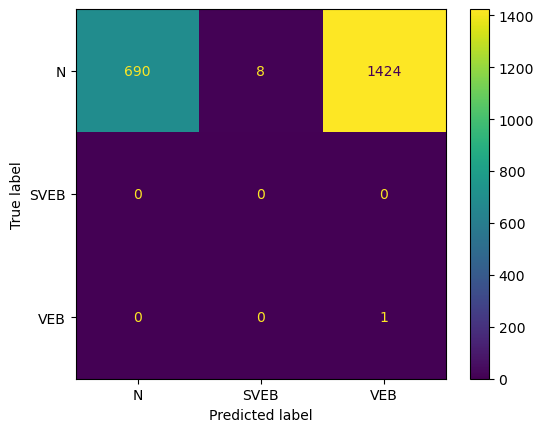

Fold 9:
  Test:  patient=8
              precision    recall  f1-score   support

         0.0       1.00      0.89      0.94      2536
         1.0       0.01      1.00      0.01         2
         2.0       0.00      0.00      0.00         0

    accuracy                           0.89      2538
   macro avg       0.34      0.63      0.32      2538
weighted avg       1.00      0.89      0.94      2538

                   0.0       1.0  2.0  accuracy    macro avg  weighted avg
precision     1.000000  0.006897  0.0  0.885737     0.335632      0.999217
recall        0.885647  1.000000  NaN  0.885737     0.628549      0.885737
f1-score      0.939356  0.013699  NaN  0.885737     0.317685      0.938626
support    2536.000000  2.000000  0.0  0.885737  2538.000000   2538.000000


C:\Users\matte\anaconda3\envs\DMML\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matte\anaconda3\envs\DMML\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matte\anaconda3\envs\DMML\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matte\anaconda3\envs\DMML\lib\site-packa

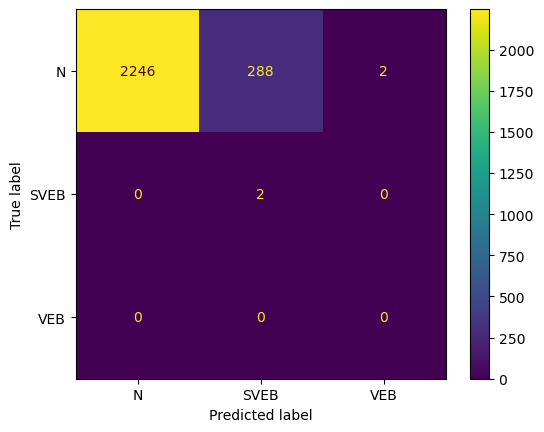

Fold 10:
  Test:  patient=9


C:\Users\matte\anaconda3\envs\DMML\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matte\anaconda3\envs\DMML\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matte\anaconda3\envs\DMML\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matte\anaconda3\envs\DMML\lib\site-packa

              precision    recall  f1-score   support

         0.0       1.00      0.92      0.96      1788
         1.0       0.00      0.00      0.00         6
         2.0       0.00      0.00      0.00         0

    accuracy                           0.92      1794
   macro avg       0.33      0.31      0.32      1794
weighted avg       1.00      0.92      0.96      1794

                   0.0  1.0  2.0  accuracy    macro avg  weighted avg
precision     0.999394  0.0  0.0  0.918618     0.333131      0.996051
recall        0.921700  0.0  NaN  0.918618     0.307233      0.918618
f1-score      0.958976  0.0  NaN  0.918618     0.319659      0.955769
support    1788.000000  6.0  0.0  0.918618  1794.000000   1794.000000


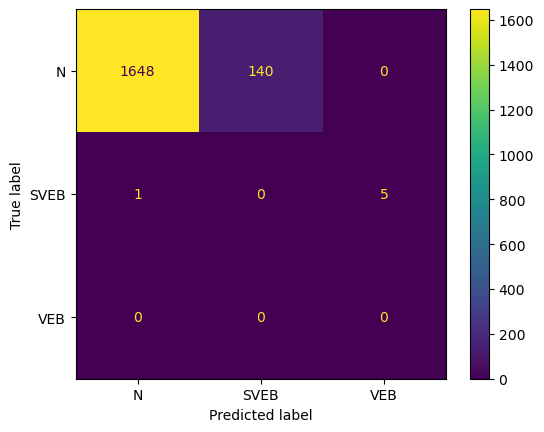

Fold 11:
  Test:  patient=10
              precision    recall  f1-score   support

         0.0       0.99      0.93      0.96      1819
         1.0       0.09      0.25      0.13        12
         2.0       0.23      0.77      0.35        43

    accuracy                           0.92      1874
   macro avg       0.44      0.65      0.48      1874
weighted avg       0.97      0.92      0.94      1874

                   0.0        1.0        2.0  accuracy    macro avg  \
precision     0.994107   0.090909   0.229167  0.919424     0.438061   
recall        0.927433   0.250000   0.767442  0.919424     0.648292   
f1-score      0.959613   0.133333   0.352941  0.919424     0.481963   
support    1819.000000  12.000000  43.000000  0.919424  1874.000000   

           weighted avg  
precision      0.970772  
recall         0.919424  
f1-score       0.940402  
support     1874.000000  


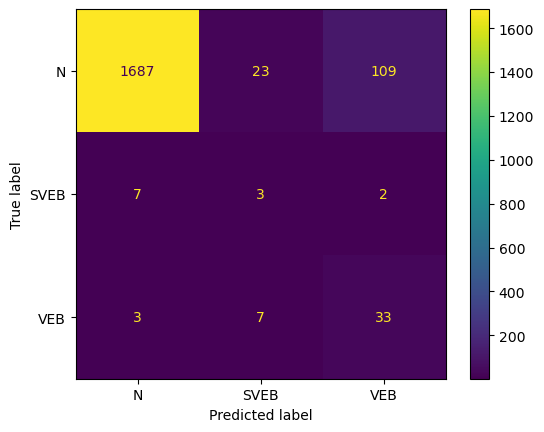

Fold 12:
  Test:  patient=11
              precision    recall  f1-score   support

         0.0       1.00      0.98      0.99      1952
         1.0       0.00      0.00      0.00         0

    accuracy                           0.98      1952
   macro avg       0.50      0.49      0.50      1952
weighted avg       1.00      0.98      0.99      1952

                   0.0  1.0  accuracy    macro avg  weighted avg
precision     1.000000  0.0  0.983607     0.500000      1.000000
recall        0.983607  NaN  0.983607     0.491803      0.983607
f1-score      0.991736  NaN  0.983607     0.495868      0.991736
support    1952.000000  0.0  0.983607  1952.000000   1952.000000


C:\Users\matte\anaconda3\envs\DMML\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matte\anaconda3\envs\DMML\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matte\anaconda3\envs\DMML\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matte\anaconda3\envs\DMML\lib\site-packa

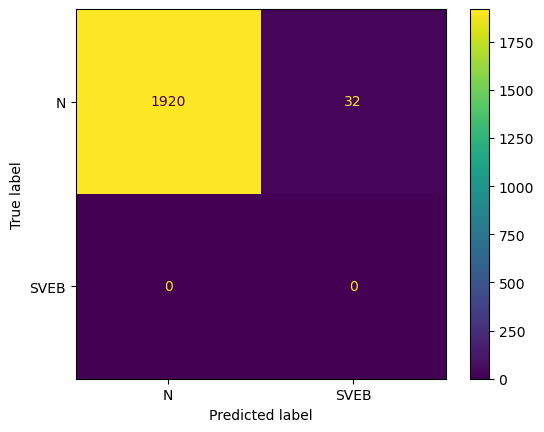

Fold 13:
  Test:  patient=12
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      2301
         1.0       0.10      1.00      0.18         1
         2.0       0.98      0.94      0.96       109

    accuracy                           0.99      2411
   macro avg       0.69      0.98      0.71      2411
weighted avg       1.00      0.99      1.00      2411

                   0.0       1.0         2.0  accuracy    macro avg  \
precision     0.999129  0.100000    0.980952  0.994608     0.693360   
recall        0.996958  1.000000    0.944954  0.994608     0.980637   
f1-score      0.998042  0.181818    0.962617  0.994608     0.714159   
support    2301.000000  1.000000  109.000000  0.994608  2411.000000   

           weighted avg  
precision      0.997934  
recall         0.994608  
f1-score       0.996102  
support     2411.000000  


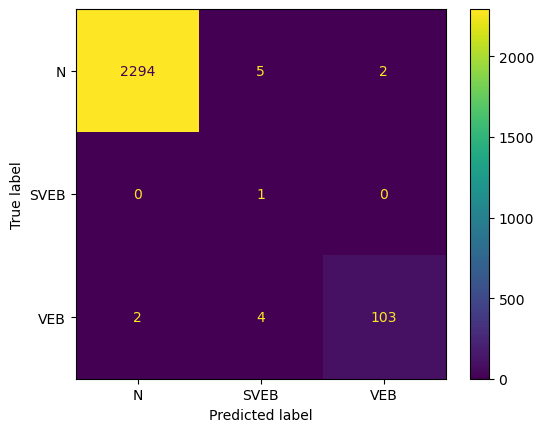

Fold 14:
  Test:  patient=13
              precision    recall  f1-score   support

         0.0       1.00      0.89      0.94      1533
         1.0       0.01      1.00      0.01         1
         2.0       0.00      0.00      0.00         0

    accuracy                           0.89      1534
   macro avg       0.34      0.63      0.32      1534
weighted avg       1.00      0.89      0.94      1534

                   0.0       1.0  2.0  accuracy    macro avg  weighted avg
precision     1.000000  0.006098  0.0  0.892438     0.335366      0.999352
recall        0.892368  1.000000  NaN  0.892438     0.630789      0.892438
f1-score      0.943123  0.012121  NaN  0.892438     0.318415      0.942516
support    1533.000000  1.000000  0.0  0.892438  1534.000000   1534.000000


C:\Users\matte\anaconda3\envs\DMML\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matte\anaconda3\envs\DMML\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matte\anaconda3\envs\DMML\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matte\anaconda3\envs\DMML\lib\site-packa

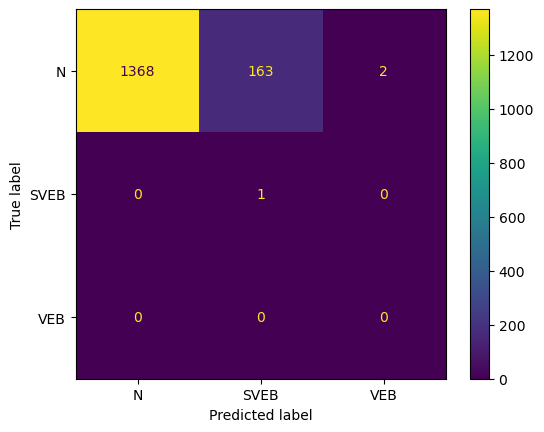

Fold 15:
  Test:  patient=14
              precision    recall  f1-score   support

         0.0       0.99      0.69      0.81      2165
         1.0       0.69      0.23      0.34        96
         2.0       0.02      0.75      0.03        16

    accuracy                           0.67      2277
   macro avg       0.56      0.56      0.40      2277
weighted avg       0.97      0.67      0.79      2277

                   0.0        1.0        2.0  accuracy    macro avg  \
precision     0.986111   0.687500   0.016371  0.669741     0.563327   
recall        0.688684   0.229167   0.750000  0.669741     0.555950   
f1-score      0.810987   0.343750   0.032043  0.669741     0.395593   
support    2165.000000  96.000000  16.000000  0.669741  2277.000000   

           weighted avg  
precision      0.966707  
recall         0.669741  
f1-score       0.785815  
support     2277.000000  


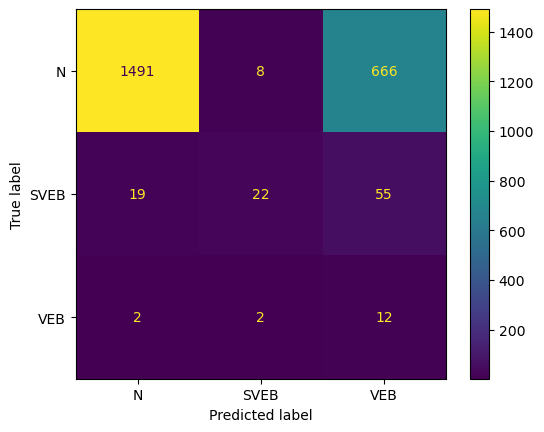

Fold 16:
  Test:  patient=15
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      1542
         1.0       0.00      0.00      0.00         0
         2.0       1.00      1.00      1.00       444

    accuracy                           1.00      1986
   macro avg       0.67      0.66      0.67      1986
weighted avg       1.00      1.00      1.00      1986

                   0.0  1.0         2.0  accuracy    macro avg  weighted avg
precision     1.000000  0.0    1.000000  0.995972     0.666667      1.000000
recall        0.995460  NaN    0.997748  0.995972     0.664403      0.995972
f1-score      0.997725  NaN    0.998873  0.995972     0.665533      0.997982
support    1542.000000  0.0  444.000000  0.995972  1986.000000   1986.000000


C:\Users\matte\anaconda3\envs\DMML\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matte\anaconda3\envs\DMML\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matte\anaconda3\envs\DMML\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matte\anaconda3\envs\DMML\lib\site-packa

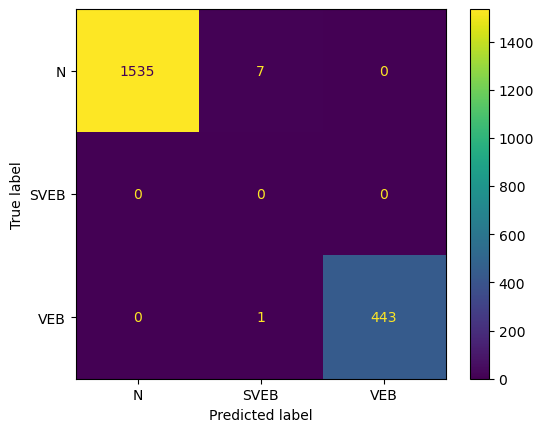

Fold 17:
  Test:  patient=16
              precision    recall  f1-score   support

         0.0       1.00      0.81      0.89      1860
         1.0       0.00      1.00      0.01         1
         2.0       0.00      0.00      0.00         1

    accuracy                           0.81      1862
   macro avg       0.33      0.60      0.30      1862
weighted avg       1.00      0.81      0.89      1862

                   0.0       1.0  2.0  accuracy    macro avg  weighted avg
precision     1.000000  0.002793  0.0  0.807734     0.334264      0.998927
recall        0.808065  1.000000  0.0  0.807734     0.602688      0.807734
f1-score      0.893845  0.005571  0.0  0.807734     0.299805      0.892888
support    1860.000000  1.000000  1.0  0.807734  1862.000000   1862.000000


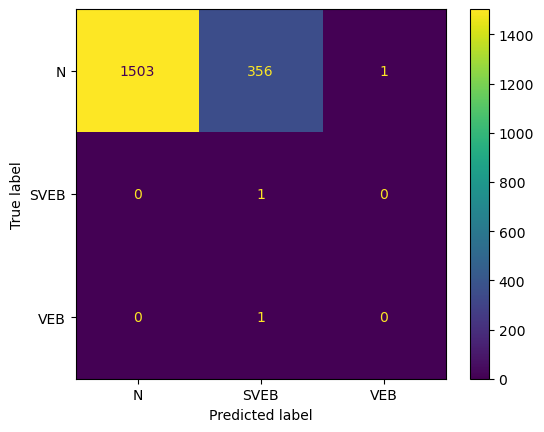

Fold 18:
  Test:  patient=17


C:\Users\matte\anaconda3\envs\DMML\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matte\anaconda3\envs\DMML\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matte\anaconda3\envs\DMML\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matte\anaconda3\envs\DMML\lib\site-packa

              precision    recall  f1-score   support

         0.0       1.00      0.69      0.82      2475
         1.0       0.00      0.00      0.00         0
         2.0       0.00      0.00      0.00         0

    accuracy                           0.69      2475
   macro avg       0.33      0.23      0.27      2475
weighted avg       1.00      0.69      0.82      2475

                   0.0  1.0  2.0  accuracy    macro avg  weighted avg
precision     1.000000  0.0  0.0  0.688081     0.333333      1.000000
recall        0.688081  NaN  NaN  0.688081     0.229360      0.688081
f1-score      0.815223  NaN  NaN  0.688081     0.271741      0.815223
support    2475.000000  0.0  0.0  0.688081  2475.000000   2475.000000


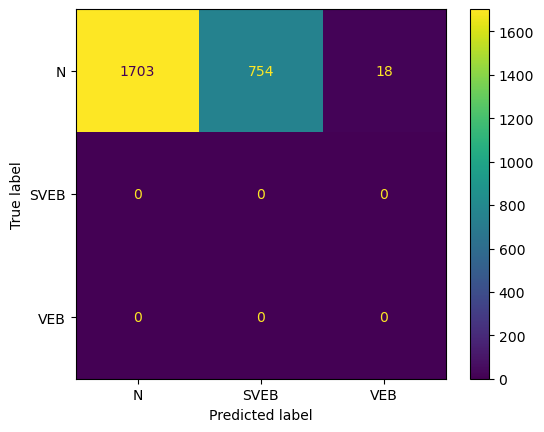

Fold 19:
  Test:  patient=18


C:\Users\matte\anaconda3\envs\DMML\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matte\anaconda3\envs\DMML\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matte\anaconda3\envs\DMML\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matte\anaconda3\envs\DMM

              precision    recall  f1-score   support

         0.0       1.00      0.88      0.94      1514
         1.0       0.00      0.00      0.00         0
         2.0       0.00      0.00      0.00         3

    accuracy                           0.88      1517
   macro avg       0.33      0.29      0.31      1517
weighted avg       1.00      0.88      0.94      1517

                   0.0  1.0  2.0  accuracy    macro avg  weighted avg
precision     1.000000  0.0  NaN  0.882004     0.333333      0.998022
recall        0.883752  NaN  0.0  0.882004     0.294584      0.882004
f1-score      0.938289  NaN  NaN  0.882004     0.312763      0.936433
support    1514.000000  0.0  3.0  0.882004  1517.000000   1517.000000


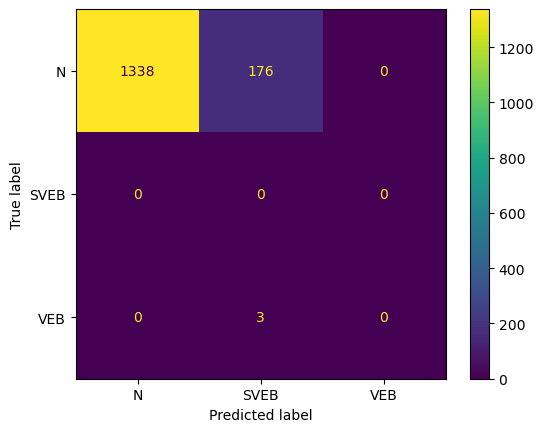

Fold 20:
  Test:  patient=19
              precision    recall  f1-score   support

         0.0       0.98      0.41      0.58      1535
         1.0       0.00      0.00      0.00        31
         2.0       0.03      0.64      0.06        47

    accuracy                           0.41      1613
   macro avg       0.34      0.35      0.21      1613
weighted avg       0.93      0.41      0.55      1613

                   0.0   1.0        2.0  accuracy    macro avg  weighted avg
precision     0.979719   0.0   0.031381  0.407936     0.337033      0.933257
recall        0.409121   0.0   0.638298  0.407936     0.349139      0.407936
f1-score      0.577206   0.0   0.059821  0.407936     0.212342      0.551037
support    1535.000000  31.0  47.000000  0.407936  1613.000000   1613.000000


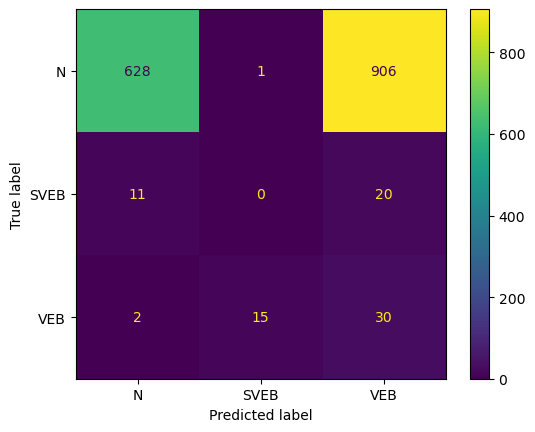

Fold 21:
  Test:  patient=20
              precision    recall  f1-score   support

         0.0       0.99      0.86      0.92      1742
         1.0       0.07      0.63      0.13        30
         2.0       0.96      0.95      0.95       826

    accuracy                           0.88      2598
   macro avg       0.67      0.81      0.67      2598
weighted avg       0.97      0.88      0.92      2598

                   0.0        1.0         2.0  accuracy    macro avg  \
precision     0.986129   0.071161    0.958384  0.883372     0.671892   
recall        0.857061   0.633333    0.947942  0.883372     0.812779   
f1-score      0.917076   0.127946    0.953135  0.883372     0.666052   
support    1742.000000  30.000000  826.000000  0.883372  2598.000000   

           weighted avg  
precision      0.966743  
recall         0.883372  
f1-score       0.919428  
support     2598.000000  


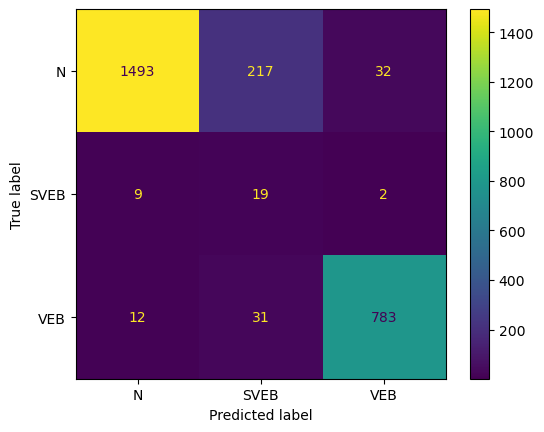

Fold 22:
  Test:  patient=21
              precision    recall  f1-score   support

         0.0       0.91      0.89      0.90      1634
         1.0       0.24      0.48      0.32       128
         2.0       0.48      0.24      0.32       198

    accuracy                           0.80      1960
   macro avg       0.54      0.53      0.51      1960
weighted avg       0.82      0.80      0.80      1960

                   0.0         1.0         2.0  accuracy    macro avg  \
precision     0.905296    0.236434    0.484536  0.796429     0.542089   
recall        0.889229    0.476562    0.237374  0.796429     0.534388   
f1-score      0.897190    0.316062    0.318644  0.796429     0.510632   
support    1634.000000  128.000000  198.000000  0.796429  1960.000000   

           weighted avg  
precision      0.819110  
recall         0.796429  
f1-score       0.800794  
support     1960.000000  


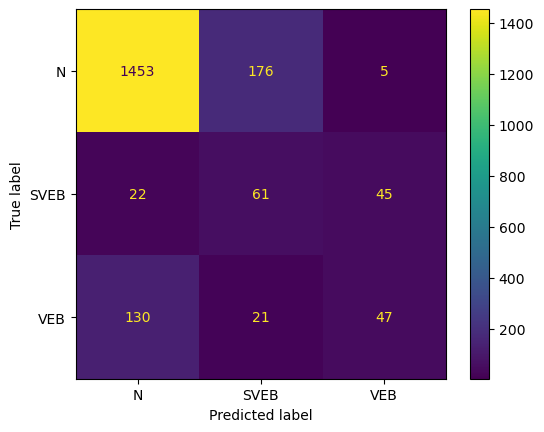

Fold 23:
  Test:  patient=22
              precision    recall  f1-score   support

         0.0       1.00      0.79      0.88      2060
         1.0       0.07      0.62      0.13        55
         2.0       0.42      0.68      0.52        19

    accuracy                           0.78      2134
   macro avg       0.50      0.70      0.51      2134
weighted avg       0.97      0.78      0.86      2134

                   0.0        1.0        2.0  accuracy    macro avg  \
precision     0.996308   0.071130   0.419355  0.780694     0.495597   
recall        0.785922   0.618182   0.684211  0.780694     0.696105   
f1-score      0.878697   0.127580   0.520000  0.780694     0.508759   
support    2060.000000  55.000000  19.000000  0.780694  2134.000000   

           weighted avg  
precision      0.967326  
recall         0.780694  
f1-score       0.856145  
support     2134.000000  


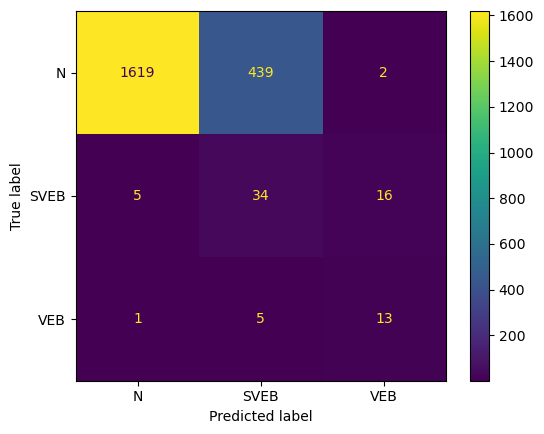

Fold 24:
  Test:  patient=23
              precision    recall  f1-score   support

         0.0       1.00      0.56      0.72      2528
         1.0       0.00      0.00      0.00         2
         2.0       0.34      0.95      0.50       444

    accuracy                           0.62      2974
   macro avg       0.44      0.50      0.40      2974
weighted avg       0.90      0.62      0.68      2974

                   0.0  1.0         2.0  accuracy    macro avg  weighted avg
precision     0.997189  0.0    0.336269  0.618359     0.444486      0.897847
recall        0.561313  0.0    0.945946  0.618359     0.502420      0.618359
f1-score      0.718299  0.0    0.496161  0.618359     0.404820      0.684652
support    2528.000000  2.0  444.000000  0.618359  2974.000000   2974.000000


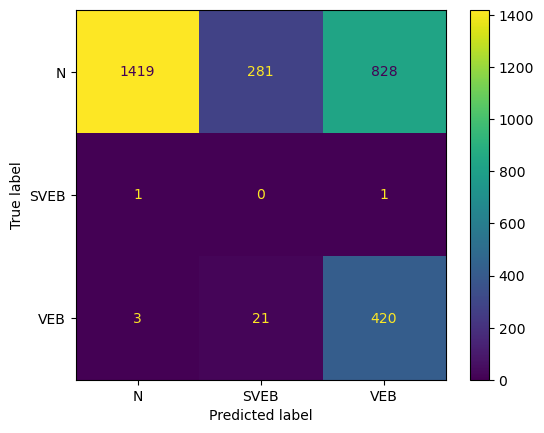

Fold 25:
  Test:  patient=24
              precision    recall  f1-score   support

         0.0       1.00      0.92      0.96      2570
         1.0       0.01      1.00      0.03         3
         2.0       0.98      0.86      0.92        71

    accuracy                           0.92      2644
   macro avg       0.67      0.93      0.63      2644
weighted avg       1.00      0.92      0.95      2644

                   0.0       1.0        2.0  accuracy    macro avg  \
precision     0.997884  0.013699   0.983871  0.916036     0.665151   
recall        0.917510  1.000000   0.859155  0.916036     0.925555   
f1-score      0.956011  0.027027   0.917293  0.916036     0.633444   
support    2570.000000  3.000000  71.000000  0.916036  2644.000000   

           weighted avg  
precision      0.996391  
recall         0.916036  
f1-score       0.953917  
support     2644.000000  


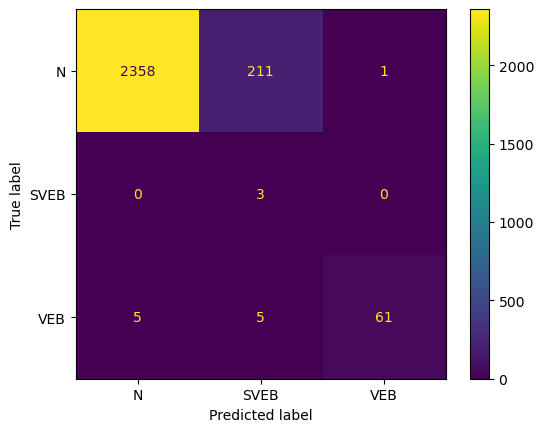

Fold 26:
  Test:  patient=25
              precision    recall  f1-score   support

         0.0       0.52      0.05      0.10      1543
         1.0       0.00      0.00      0.00       106
         2.0       0.07      0.60      0.13       210

    accuracy                           0.11      1859
   macro avg       0.20      0.22      0.08      1859
weighted avg       0.44      0.11      0.10      1859

                   0.0    1.0         2.0  accuracy    macro avg  weighted avg
precision     0.518519    0.0    0.074052  0.112426     0.197524      0.438744
recall        0.054439    0.0    0.595238  0.112426     0.216559      0.112426
f1-score      0.098534    0.0    0.131718  0.112426     0.076750      0.096664
support    1543.000000  106.0  210.000000  0.112426  1859.000000   1859.000000


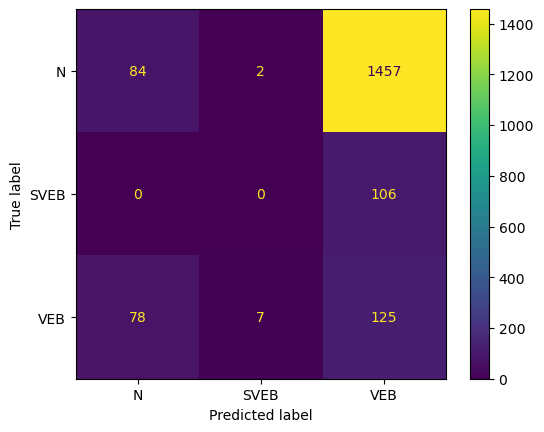

Fold 27:
  Test:  patient=26
              precision    recall  f1-score   support

         0.0       0.84      0.96      0.89      1585
         1.0       0.00      0.00      0.00         2
         2.0       0.99      0.53      0.69       992

    accuracy                           0.79      2579
   macro avg       0.61      0.49      0.53      2579
weighted avg       0.90      0.79      0.81      2579

                   0.0  1.0         2.0  accuracy    macro avg  weighted avg
precision     0.838211  0.0    0.992381  0.790617     0.610197      0.896862
recall        0.957729  0.0    0.525202  0.790617     0.494310      0.790617
f1-score      0.893993  0.0    0.686882  0.790617     0.526958      0.813635
support    1585.000000  2.0  992.000000  0.790617  2579.000000   2579.000000


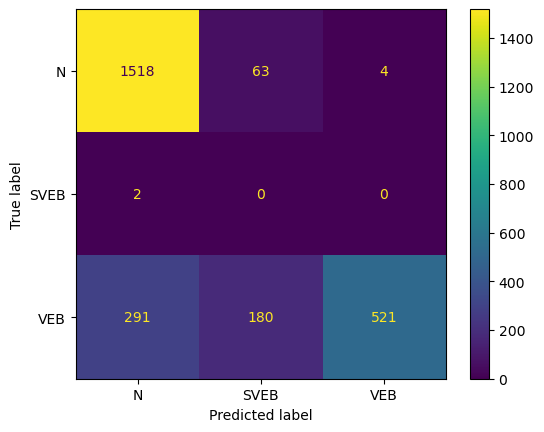

Fold 28:
  Test:  patient=27
              precision    recall  f1-score   support

         0.0       0.99      0.98      0.98      2620
         1.0       0.87      0.78      0.82       383
         2.0       0.01      1.00      0.03         1

    accuracy                           0.95      3004
   macro avg       0.62      0.92      0.61      3004
weighted avg       0.98      0.95      0.96      3004

                   0.0         1.0       2.0  accuracy    macro avg  \
precision     0.991486    0.869186  0.013158   0.95273     0.624610   
recall        0.977863    0.780679  1.000000   0.95273     0.919514   
f1-score      0.984627    0.822558  0.025974   0.95273     0.611053   
support    2620.000000  383.000000  1.000000   0.95273  3004.000000   

           weighted avg  
precision      0.975568  
recall         0.952730  
f1-score       0.963645  
support     3004.000000  


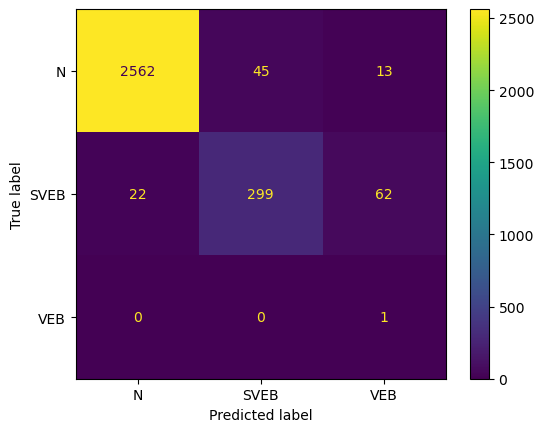

Fold 29:
  Test:  patient=28
              precision    recall  f1-score   support

         0.0       0.99      0.79      0.88      2422
         1.0       0.04      1.00      0.07        22
         2.0       0.50      0.34      0.40       195

    accuracy                           0.76      2639
   macro avg       0.51      0.71      0.45      2639
weighted avg       0.95      0.76      0.84      2639

                   0.0        1.0         2.0  accuracy    macro avg  \
precision     0.990181   0.038462    0.500000  0.759379     0.509547   
recall        0.791082   1.000000    0.338462  0.759379     0.709848   
f1-score      0.879504   0.074074    0.403670  0.759379     0.452416   
support    2422.000000  22.000000  195.000000  0.759379  2639.000000   

           weighted avg  
precision      0.946027  
recall         0.759379  
f1-score       0.837630  
support     2639.000000  


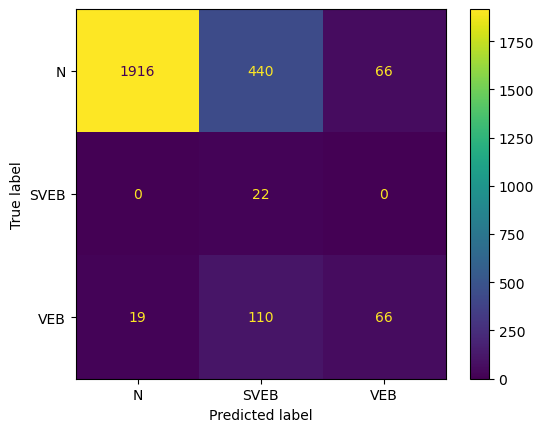

Fold 30:
  Test:  patient=29
              precision    recall  f1-score   support

         0.0       1.00      0.94      0.97      2747
         1.0       0.00      0.00      0.00         0
         2.0       0.00      0.00      0.00         0

    accuracy                           0.94      2747
   macro avg       0.33      0.31      0.32      2747
weighted avg       1.00      0.94      0.97      2747

                   0.0  1.0  2.0  accuracy    macro avg  weighted avg
precision     1.000000  0.0  0.0  0.936294     0.333333      1.000000
recall        0.936294  NaN  NaN  0.936294     0.312098      0.936294
f1-score      0.967099  NaN  NaN  0.936294     0.322366      0.967099
support    2747.000000  0.0  0.0  0.936294  2747.000000   2747.000000


C:\Users\matte\anaconda3\envs\DMML\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matte\anaconda3\envs\DMML\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matte\anaconda3\envs\DMML\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matte\anaconda3\envs\DMML\lib\site-packa

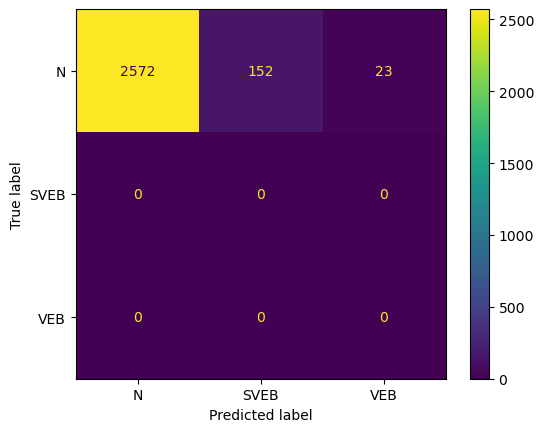

Fold 31:
  Test:  patient=30
              precision    recall  f1-score   support

         0.0       1.00      0.55      0.71      2640
         1.0       0.38      0.11      0.17        28
         2.0       0.15      1.00      0.26       220

    accuracy                           0.58      2888
   macro avg       0.51      0.55      0.38      2888
weighted avg       0.93      0.58      0.67      2888

                   0.0        1.0         2.0  accuracy    macro avg  \
precision     1.000000   0.375000    0.151978  0.575139     0.508993   
recall        0.545076   0.107143    0.995455  0.575139     0.549224   
f1-score      0.705565   0.166667    0.263697  0.575139     0.378643   
support    2640.000000  28.000000  220.000000  0.575139  2888.000000   

           weighted avg  
precision      0.929340  
recall         0.575139  
f1-score       0.666680  
support     2888.000000  


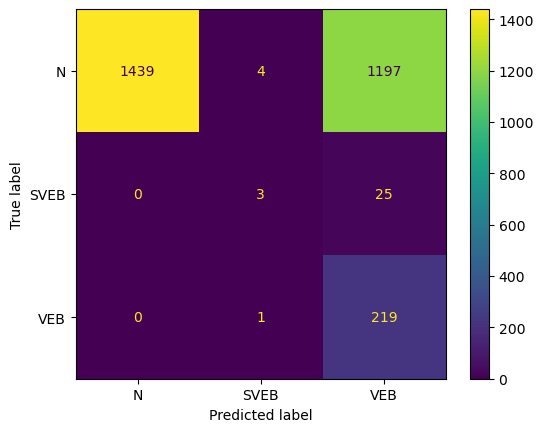

Fold 32:
  Test:  patient=31


C:\Users\matte\anaconda3\envs\DMML\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matte\anaconda3\envs\DMML\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matte\anaconda3\envs\DMML\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matte\anaconda3\envs\DMML\lib\site-packa

              precision    recall  f1-score   support

         0.0       1.00      0.98      0.99      2002
         1.0       0.00      0.00      0.00         0
         2.0       0.87      0.87      0.87       256

    accuracy                           0.97      2258
   macro avg       0.62      0.62      0.62      2258
weighted avg       0.98      0.97      0.98      2258

                   0.0  1.0         2.0  accuracy    macro avg  weighted avg
precision     0.997457  0.0    0.874016  0.966785     0.623824      0.983462
recall        0.979520  NaN    0.867188  0.966785     0.615569      0.966785
f1-score      0.988407  NaN    0.870588  0.966785     0.619665      0.975050
support    2002.000000  0.0  256.000000  0.966785  2258.000000   2258.000000


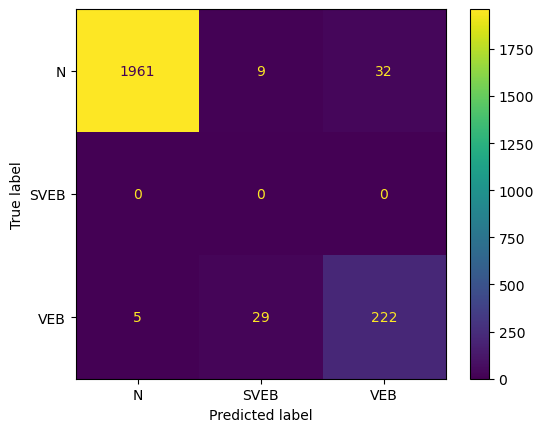

Fold 33:
  Test:  patient=32
              precision    recall  f1-score   support

         0.0       1.00      0.81      0.90      3194
         1.0       0.00      0.67      0.01         3
         2.0       0.96      0.81      0.88       164

    accuracy                           0.81      3361
   macro avg       0.65      0.76      0.59      3361
weighted avg       0.99      0.81      0.90      3361

                   0.0       1.0         2.0  accuracy    macro avg  \
precision     0.996935  0.003263    0.963768  0.814341     0.654655   
recall        0.814652  0.666667    0.810976  0.814341     0.764098   
f1-score      0.896623  0.006494    0.880795  0.814341     0.594637   
support    3194.000000  3.000000  164.000000  0.814341  3361.000000   

           weighted avg  
precision      0.994430  
recall         0.814341  
f1-score       0.895056  
support     3361.000000  


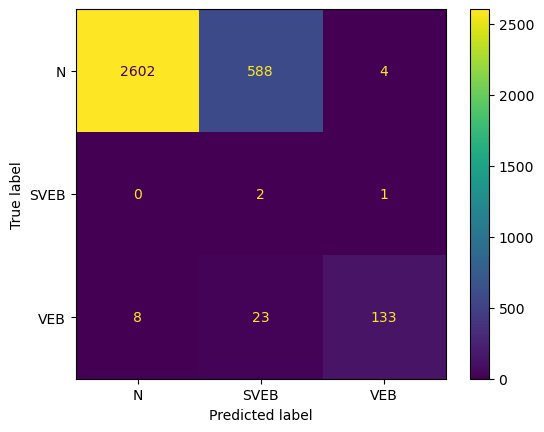

Fold 34:
  Test:  patient=33
              precision    recall  f1-score   support

         0.0       0.99      0.82      0.90      2081
         1.0       0.01      0.14      0.02         7
         2.0       0.14      0.77      0.23        64

    accuracy                           0.81      2152
   macro avg       0.38      0.58      0.38      2152
weighted avg       0.96      0.81      0.87      2152

                   0.0       1.0        2.0  accuracy    macro avg  \
precision     0.992415  0.012048   0.138028  0.813662     0.380831   
recall        0.817395  0.142857   0.765625  0.813662     0.575293   
f1-score      0.896443  0.022222   0.233890  0.813662     0.384185   
support    2081.000000  7.000000  64.000000  0.813662  2152.000000   

           weighted avg  
precision      0.963817  
recall         0.813662  
f1-score       0.873895  
support     2152.000000  


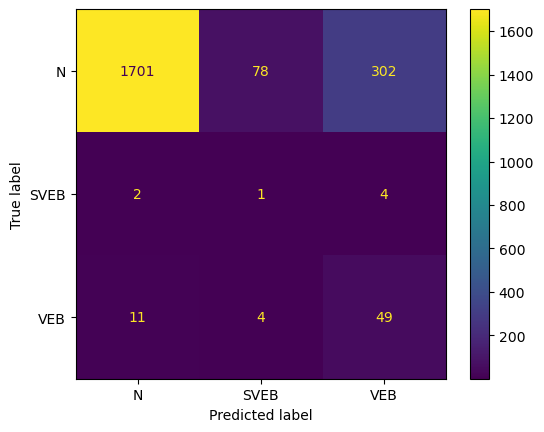

Fold 35:
  Test:  patient=34
              precision    recall  f1-score   support

         0.0       1.00      0.99      0.99      1953
         1.0       0.82      0.99      0.89        94

    accuracy                           0.99      2047
   macro avg       0.91      0.99      0.94      2047
weighted avg       0.99      0.99      0.99      2047

                   0.0        1.0  accuracy    macro avg  weighted avg
precision     0.999483   0.815789  0.989253     0.907636      0.991047
recall        0.989247   0.989362  0.989253     0.989305      0.989253
f1-score      0.994339   0.894231  0.989253     0.944285      0.989742
support    1953.000000  94.000000  0.989253  2047.000000   2047.000000


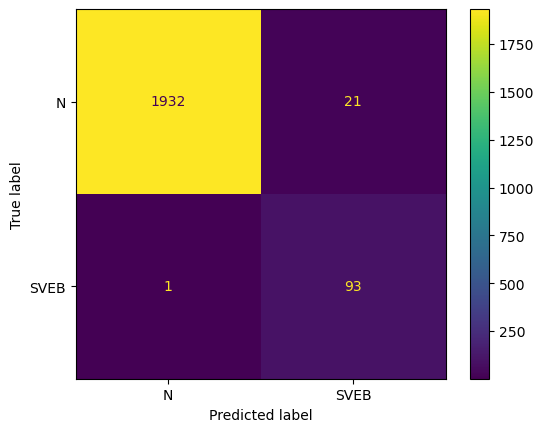

Fold 36:
  Test:  patient=35
              precision    recall  f1-score   support

         0.0       1.00      0.77      0.87      2030
         1.0       0.00      0.00      0.00         0
         2.0       0.99      0.99      0.99       396

    accuracy                           0.81      2426
   macro avg       0.66      0.59      0.62      2426
weighted avg       1.00      0.81      0.89      2426

                   0.0  1.0         2.0  accuracy    macro avg  weighted avg
precision     0.998729  0.0    0.992424  0.809975     0.663718      0.997700
recall        0.774384  NaN    0.992424  0.809975     0.588936      0.809975
f1-score      0.872364  NaN    0.992424  0.809975     0.621596      0.891962
support    2030.000000  0.0  396.000000  0.809975  2426.000000   2426.000000


C:\Users\matte\anaconda3\envs\DMML\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matte\anaconda3\envs\DMML\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matte\anaconda3\envs\DMML\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matte\anaconda3\envs\DMML\lib\site-packa

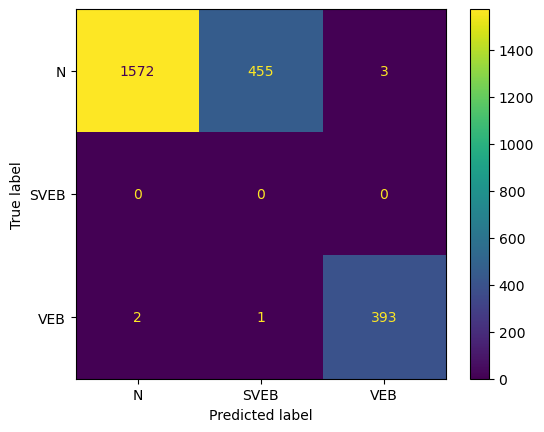

Fold 37:
  Test:  patient=36
              precision    recall  f1-score   support

         0.0       0.99      0.70      0.82      2273
         1.0       0.22      0.88      0.36       209
         2.0       0.00      0.00      0.00         0

    accuracy                           0.71      2482
   macro avg       0.40      0.52      0.39      2482
weighted avg       0.92      0.71      0.78      2482

                   0.0         1.0  2.0  accuracy    macro avg  weighted avg
precision     0.988169    0.223990  0.0  0.713135     0.404053      0.923821
recall        0.698196    0.875598  NaN  0.713135     0.524598      0.713135
f1-score      0.818252    0.356725  NaN  0.713135     0.391659      0.779389
support    2273.000000  209.000000  0.0  0.713135  2482.000000   2482.000000


C:\Users\matte\anaconda3\envs\DMML\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matte\anaconda3\envs\DMML\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matte\anaconda3\envs\DMML\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matte\anaconda3\envs\DMML\lib\site-packa

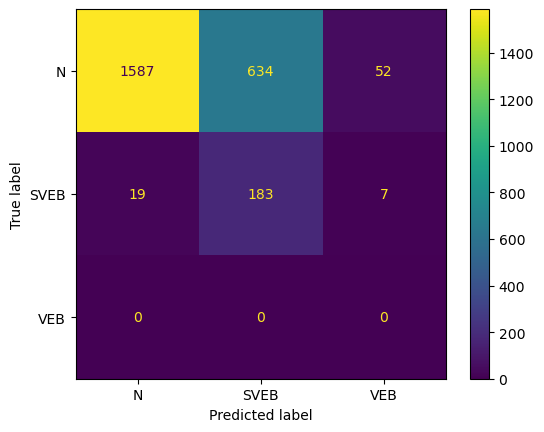

Fold 38:
  Test:  patient=37
              precision    recall  f1-score   support

         0.0       0.96      0.98      0.97      2044
         1.0       0.15      0.32      0.21        73
         2.0       0.83      0.63      0.71       473

    accuracy                           0.89      2590
   macro avg       0.65      0.64      0.63      2590
weighted avg       0.91      0.89      0.90      2590

                   0.0        1.0         2.0  accuracy    macro avg  \
precision     0.959674   0.153333    0.829132  0.894981     0.647380   
recall        0.977984   0.315068    0.625793  0.894981     0.639615   
f1-score      0.968742   0.206278    0.713253  0.894981     0.629424   
support    2044.000000  73.000000  473.000000  0.894981  2590.000000   

           weighted avg  
precision      0.913106  
recall         0.894981  
f1-score       0.900593  
support     2590.000000  


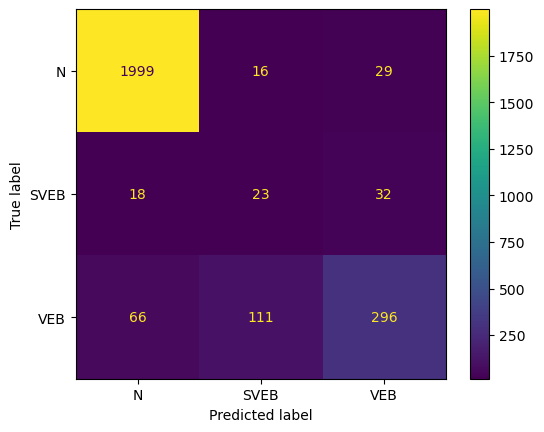

Fold 39:
  Test:  patient=38
              precision    recall  f1-score   support

         0.0       1.00      0.91      0.95      1687
         1.0       0.02      1.00      0.03         3
         2.0       1.00      0.84      0.91       362

    accuracy                           0.90      2052
   macro avg       0.67      0.92      0.63      2052
weighted avg       0.99      0.90      0.94      2052

                   0.0       1.0         2.0  accuracy    macro avg  \
precision     0.995481  0.015228    0.996732  0.901559     0.669147   
recall        0.914049  1.000000    0.842541  0.901559     0.918863   
f1-score      0.953028  0.030000    0.913174  0.901559     0.632067   
support    1687.000000  3.000000  362.000000  0.901559  2052.000000   

           weighted avg  
precision      0.994269  
recall         0.901559  
f1-score       0.944648  
support     2052.000000  


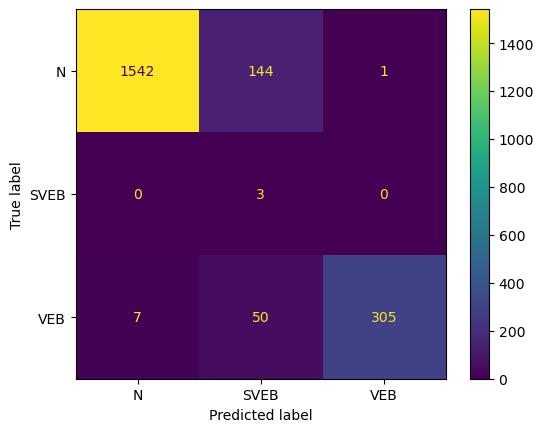

Fold 40:
  Test:  patient=39
              precision    recall  f1-score   support

         0.0       1.00      0.78      0.88      2254
         1.0       0.00      0.00      0.00         0
         2.0       0.00      1.00      0.01         1

    accuracy                           0.78      2255
   macro avg       0.33      0.59      0.30      2255
weighted avg       1.00      0.78      0.88      2255

                   0.0  1.0       2.0  accuracy    macro avg  weighted avg
precision     1.000000  0.0  0.004255  0.781818     0.334752      0.999558
recall        0.781721  NaN  1.000000  0.781818     0.593907      0.781818
f1-score      0.877490  NaN  0.008475  0.781818     0.295322      0.877105
support    2254.000000  0.0  1.000000  0.781818  2255.000000   2255.000000


C:\Users\matte\anaconda3\envs\DMML\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matte\anaconda3\envs\DMML\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matte\anaconda3\envs\DMML\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matte\anaconda3\envs\DMML\lib\site-packa

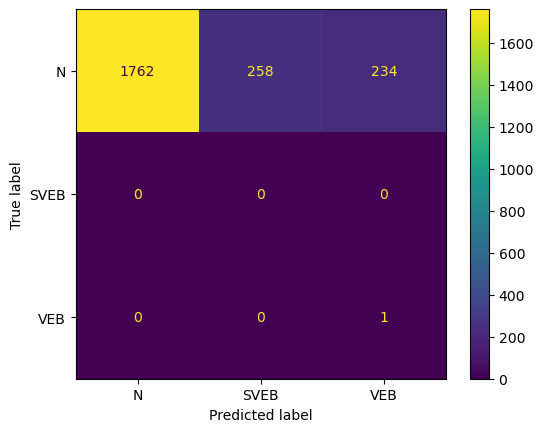

Fold 41:
  Test:  patient=40
              precision    recall  f1-score   support

         0.0       1.00      0.72      0.84      1567
         1.0       0.00      1.00      0.00         1
         2.0       0.00      0.00      0.00         2

    accuracy                           0.72      1570
   macro avg       0.33      0.57      0.28      1570
weighted avg       1.00      0.72      0.84      1570

                   0.0       1.0  2.0  accuracy    macro avg  weighted avg
precision     1.000000  0.002299  NaN  0.723567     0.334100      0.998091
recall        0.724314  1.000000  0.0  0.723567     0.574771      0.723567
f1-score      0.840118  0.004587  NaN  0.723567     0.281569      0.838516
support    1567.000000  1.000000  2.0  0.723567  1570.000000   1570.000000


C:\Users\matte\anaconda3\envs\DMML\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matte\anaconda3\envs\DMML\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matte\anaconda3\envs\DMML\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matte\anaconda3\

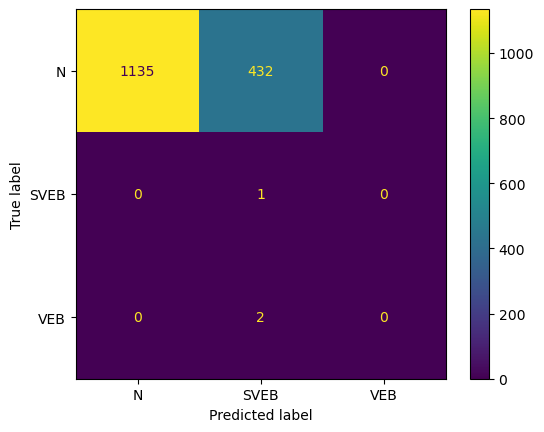

Fold 42:
  Test:  patient=41
              precision    recall  f1-score   support

         0.0       0.24      0.99      0.39       398
         1.0       0.98      0.09      0.16      1381

    accuracy                           0.29      1779
   macro avg       0.61      0.54      0.27      1779
weighted avg       0.82      0.29      0.21      1779

                  0.0          1.0  accuracy    macro avg  weighted avg
precision    0.239275     0.983871  0.291175     0.611573      0.817289
recall       0.994975     0.088342  0.291175     0.541658      0.291175
f1-score     0.385777     0.162126  0.291175     0.273952      0.212162
support    398.000000  1381.000000  0.291175  1779.000000   1779.000000


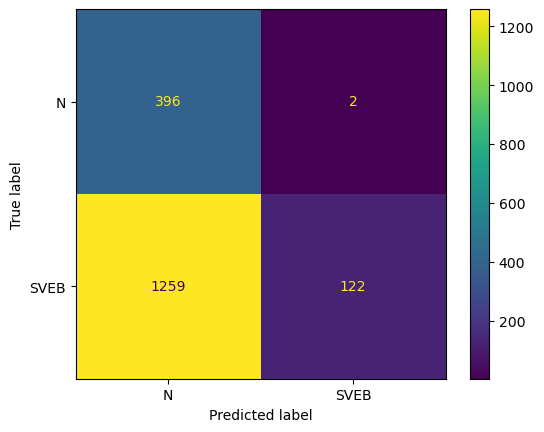

Fold 43:
  Test:  patient=42
              precision    recall  f1-score   support

         0.0       0.97      0.98      0.98      2229
         1.0       0.02      1.00      0.05         7
         2.0       1.00      0.61      0.76       831

    accuracy                           0.88      3067
   macro avg       0.66      0.86      0.59      3067
weighted avg       0.98      0.88      0.91      3067

                   0.0       1.0         2.0  accuracy    macro avg  \
precision     0.969040  0.023411    1.000000  0.881969     0.664151   
recall        0.982952  1.000000    0.610108  0.881969     0.864353   
f1-score      0.975947  0.045752    0.757848  0.881969     0.593182   
support    2229.000000  7.000000  831.000000  0.881969  3067.000000   

           weighted avg  
precision      0.975270  
recall         0.881969  
f1-score       0.914730  
support     3067.000000  


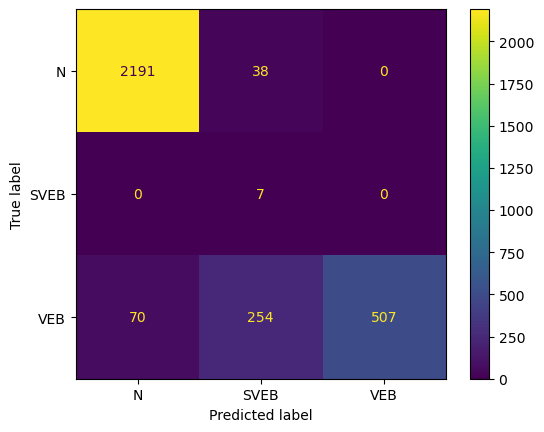

Fold 44:
  Test:  patient=43
              precision    recall  f1-score   support

         0.0       1.00      0.81      0.89      2699
         1.0       0.08      0.90      0.15        50
         2.0       0.00      0.00      0.00         3

    accuracy                           0.81      2752
   macro avg       0.36      0.57      0.35      2752
weighted avg       0.98      0.81      0.88      2752

                   0.0        1.0  2.0  accuracy    macro avg  weighted avg
precision     0.997720   0.080501  NaN   0.81141     0.359407      0.979968
recall        0.810671   0.900000  0.0   0.81141     0.570224      0.811410
f1-score      0.894522   0.147783  NaN   0.81141     0.347435      0.879979
support    2699.000000  50.000000  3.0   0.81141  2752.000000   2752.000000


C:\Users\matte\anaconda3\envs\DMML\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matte\anaconda3\envs\DMML\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matte\anaconda3\envs\DMML\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matte\anaconda3\

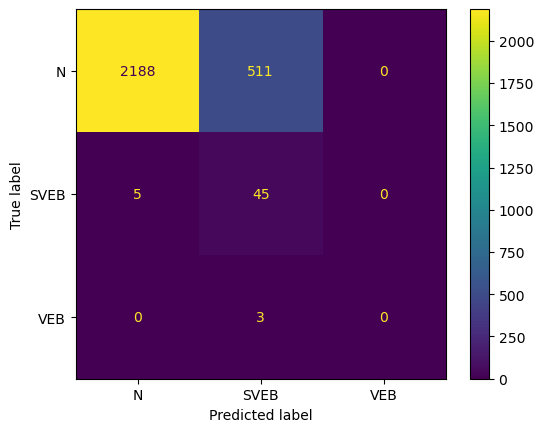

C:\Users\matte\anaconda3\envs\DMML\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\matte\anaconda3\envs\DMML\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [15]:
X=df_cardio.drop('type',axis=1)
y=df_cardio['type']
groups=df_cardio['patient']
skf = LeaveOneGroupOut()


start_time=time.time()
df_smote, acc_smote,confusion_matrix_final,list_fscore_smote = cross_valid(pipe_smote, skf, X, y,groups)
end_time=time.time()

In [16]:
df_smote

0.0        1.0         2.0    macro avg  weighted avg
f1-score      0.867423   0.163976    0.474478     0.449714      0.847409
precision     0.959409   0.130234    0.383026     0.488776      0.956932
recall        0.825330   0.557678    0.695374     0.599472      0.799404
support    2047.340909  63.159091  170.951220  2269.795455   2269.795455

In [17]:
print("Time"+str(end_time-start_time))

Time3156.3790078163147


In [18]:
confusion_matrix_final

array([[74099.,  7261.,  8723.],
       [ 1404.,   984.,   391.],
       [  883.,   910.,  5216.]])

In [19]:
list_fscore_smote

{'patient0': {'0.0': 0.9975363941769316,
  '1.0': 0.8266666666666667,
  '2.0': 0.5,
  'macro avg': 0.7747343536145328,
  'weighted avg': 0.9948355854612558},
 'patient1': {'0.0': 0.990228013029316,
  '1.0': 0.0588235294117647,
  'macro avg': 0.34968384748036024,
  'weighted avg': 0.9887273613371287},
 'patient2': {'0.0': 0.9954139512430605,
  '1.0': 0.13333333333333336,
  'macro avg': 0.376249094858798,
  'weighted avg': 0.9945862214130946},
 'patient3': {'0.0': 0.9591920857378401,
  '2.0': 0.3014705882352941,
  'macro avg': 0.42022089132437807,
  'weighted avg': 0.9486828957933332},
 'patient4': {'0.0': 0.9483627204030226,
  '2.0': 0.7976878612716763,
  'macro avg': 0.582016860558233,
  'weighted avg': 0.9096900023633878},
 'patient5': {'0.0': 0.8881789137380192,
  '1.0': 0.0,
  '2.0': 0.05804749340369393,
  'macro avg': 0.31540880238057106,
  'weighted avg': 0.8781420104422036},
 'patient6': {'0.0': 0.8141803473709255,
  '2.0': 0.08182912154031288,
  'macro avg': 0.2986698229704128,


In [21]:
pipe_smote_PCA = Pipeline([
        ('sampling', SMOTE(random_state = 123)),
        ('scaler', StandardScaler()),  
        ("pca", PCA()),
        ('classification', AdaBoostClassifier())
    ])
pipe_smote_PCA

Pipeline(steps=[('sampling', SMOTE(random_state=123)),
                ('scaler', StandardScaler()), ('pca', PCA()),
                ('classification', AdaBoostClassifier())])

Fold 1:
  Test:  patient=0
              precision    recall  f1-score   support

         0.0       1.00      0.97      0.99      2238
         1.0       0.38      0.85      0.53        33
         2.0       0.06      1.00      0.12         1

    accuracy                           0.97      2272
   macro avg       0.48      0.94      0.54      2272
weighted avg       0.99      0.97      0.98      2272

                   0.0        1.0       2.0  accuracy    macro avg  \
precision     0.999542   0.383562  0.062500  0.973151     0.481868   
recall        0.974978   0.848485  1.000000  0.973151     0.941154   
f1-score      0.987107   0.528302  0.117647  0.973151     0.544352   
support    2238.000000  33.000000  1.000000  0.973151  2272.000000   

           weighted avg  
precision      0.990183  
recall         0.973151  
f1-score       0.980060  
support     2272.000000  


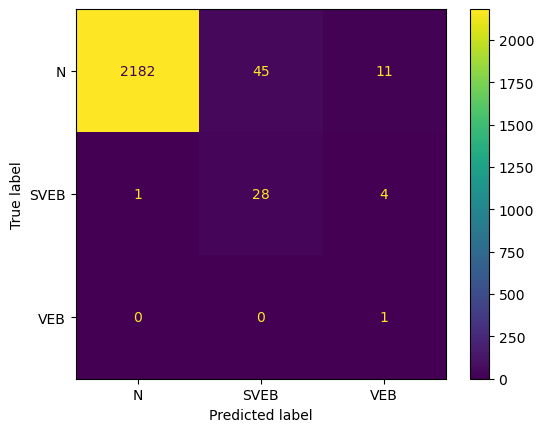

Fold 2:
  Test:  patient=1
              precision    recall  f1-score   support

         0.0       1.00      0.99      1.00      1859
         1.0       0.12      0.67      0.21         3

    accuracy                           0.99      1862
   macro avg       0.56      0.83      0.60      1862
weighted avg       1.00      0.99      0.99      1862

                   0.0       1.0  accuracy    macro avg  weighted avg
precision     0.999458  0.125000  0.991944     0.562229      0.998049
recall        0.992469  0.666667  0.991944     0.829568      0.991944
f1-score      0.995951  0.210526  0.991944     0.603239      0.994686
support    1859.000000  3.000000  0.991944  1862.000000   1862.000000


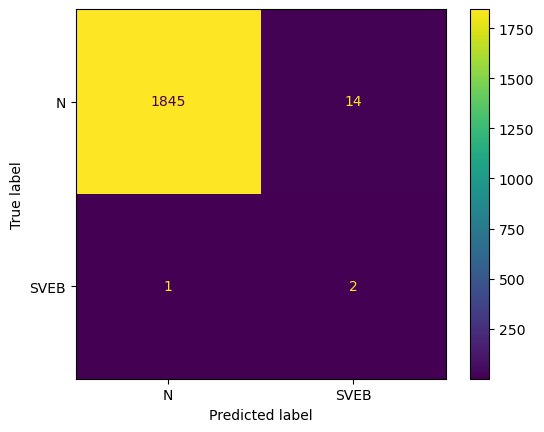

Fold 3:
  Test:  patient=2
              precision    recall  f1-score   support

         0.0       1.00      0.96      0.98      2081
         1.0       0.05      0.50      0.09         2
         2.0       0.00      0.00      0.00         0

    accuracy                           0.96      2083
   macro avg       0.35      0.49      0.36      2083
weighted avg       1.00      0.96      0.98      2083

                   0.0       1.0  2.0  accuracy    macro avg  weighted avg
precision     0.999501  0.050000  0.0  0.962074     0.349834      0.998589
recall        0.962518  0.500000  NaN  0.962074     0.487506      0.962074
f1-score      0.980661  0.090909  NaN  0.962074     0.357190      0.979807
support    2081.000000  2.000000  0.0  0.962074  2083.000000   2083.000000


C:\Users\matte\anaconda3\envs\DMML\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matte\anaconda3\envs\DMML\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matte\anaconda3\envs\DMML\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matte\anaconda3\envs\DMML\lib\site-packa

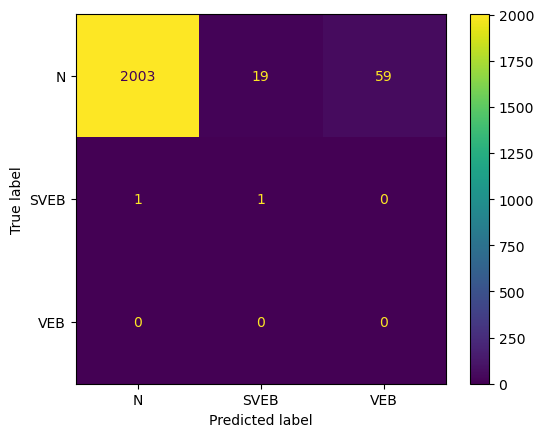

Fold 4:
  Test:  patient=3


C:\Users\matte\anaconda3\envs\DMML\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matte\anaconda3\envs\DMML\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matte\anaconda3\envs\DMML\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matte\anaconda3\envs\DMML\lib\site-packa

              precision    recall  f1-score   support

         0.0       0.99      0.67      0.80      2525
         1.0       0.00      0.00      0.00         0
         2.0       0.02      0.46      0.05        41

    accuracy                           0.67      2566
   macro avg       0.34      0.38      0.28      2566
weighted avg       0.98      0.67      0.79      2566

                   0.0  1.0        2.0  accuracy    macro avg  weighted avg
precision     0.990692  0.0   0.023810  0.671083     0.338167      0.975243
recall        0.674455  NaN   0.463415  0.671083     0.379290      0.671083
f1-score      0.802545  NaN   0.045292  0.671083     0.282612      0.790445
support    2525.000000  0.0  41.000000  0.671083  2566.000000   2566.000000


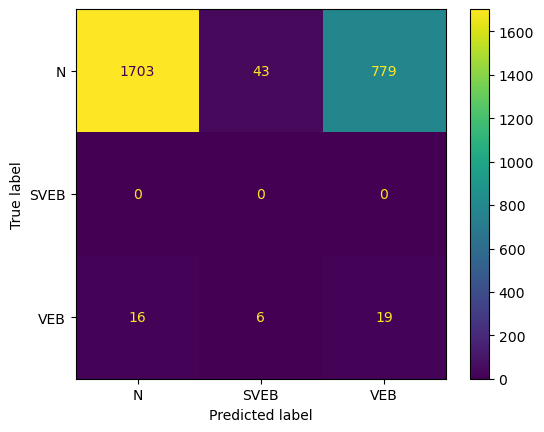

Fold 5:
  Test:  patient=4


C:\Users\matte\anaconda3\envs\DMML\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matte\anaconda3\envs\DMML\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matte\anaconda3\envs\DMML\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matte\anaconda3\envs\DMML\lib\site-packa

              precision    recall  f1-score   support

         0.0       0.95      0.99      0.97      1506
         1.0       0.00      0.00      0.00         0
         2.0       1.00      0.81      0.89       520

    accuracy                           0.94      2026
   macro avg       0.65      0.60      0.62      2026
weighted avg       0.97      0.94      0.95      2026

                   0.0  1.0         2.0  accuracy    macro avg  weighted avg
precision     0.954399  0.0    1.000000  0.940276     0.651466      0.966103
recall        0.986720  NaN    0.805769  0.940276     0.597496      0.940276
f1-score      0.970291  NaN    0.892439  0.940276     0.620910      0.950309
support    1506.000000  0.0  520.000000  0.940276  2026.000000   2026.000000


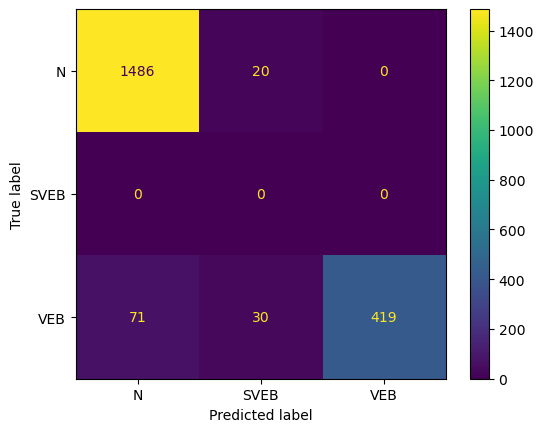

Fold 6:
  Test:  patient=5
              precision    recall  f1-score   support

         0.0       0.98      0.25      0.40      1739
         1.0       0.10      0.50      0.16         4
         2.0       0.01      0.47      0.01        17

    accuracy                           0.25      1760
   macro avg       0.36      0.41      0.19      1760
weighted avg       0.97      0.25      0.39      1760

                   0.0       1.0        2.0  accuracy    macro avg  \
precision     0.984091  0.095238   0.006159  0.251705     0.361829   
recall        0.248994  0.500000   0.470588  0.251705     0.406527   
f1-score      0.397430  0.160000   0.012158  0.251705     0.189863   
support    1739.000000  4.000000  17.000000  0.251705  1760.000000   

           weighted avg  
precision      0.972625  
recall         0.251705  
f1-score       0.393169  
support     1760.000000  


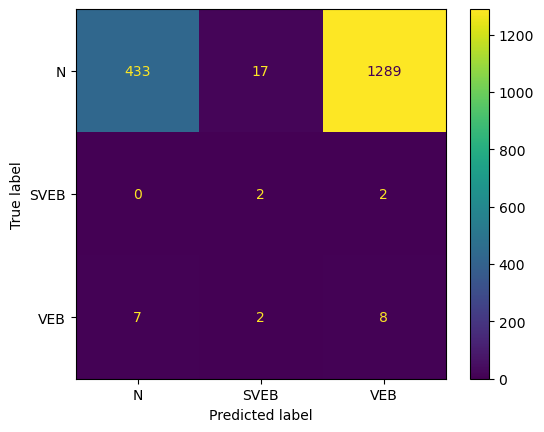

Fold 7:
  Test:  patient=6
              precision    recall  f1-score   support

         0.0       1.00      0.95      0.97      2491
         1.0       0.00      0.00      0.00         0
         2.0       0.26      0.92      0.40        38

    accuracy                           0.95      2529
   macro avg       0.42      0.62      0.46      2529
weighted avg       0.99      0.95      0.97      2529

                   0.0  1.0        2.0  accuracy    macro avg  weighted avg
precision     0.999578  0.0   0.259259  0.950178     0.419612      0.988454
recall        0.950622  NaN   0.921053  0.950178     0.623892      0.950178
f1-score      0.974486  NaN   0.404624  0.950178     0.459703      0.965923
support    2491.000000  0.0  38.000000  0.950178  2529.000000   2529.000000


C:\Users\matte\anaconda3\envs\DMML\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matte\anaconda3\envs\DMML\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matte\anaconda3\envs\DMML\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matte\anaconda3\envs\DMML\lib\site-packa

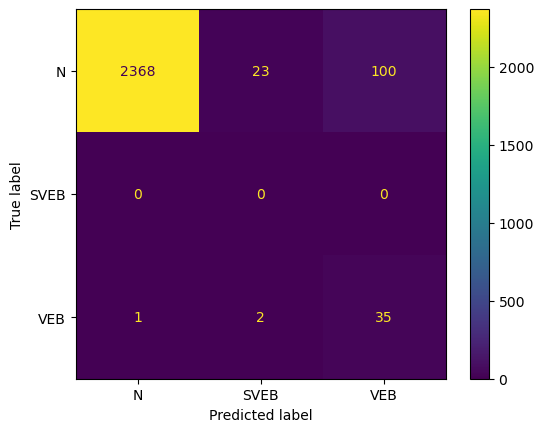

Fold 8:
  Test:  patient=7


C:\Users\matte\anaconda3\envs\DMML\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matte\anaconda3\envs\DMML\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matte\anaconda3\envs\DMML\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matte\anaconda3\envs\DMML\lib\site-packa

              precision    recall  f1-score   support

         0.0       1.00      0.39      0.56      2122
         1.0       0.00      0.00      0.00         0
         2.0       0.00      1.00      0.00         1

    accuracy                           0.39      2123
   macro avg       0.33      0.46      0.19      2123
weighted avg       1.00      0.39      0.56      2123

                   0.0  1.0       2.0  accuracy    macro avg  weighted avg
precision     1.000000  0.0  0.000786  0.391427     0.333595      0.999529
recall        0.391140  NaN  1.000000  0.391427     0.463713      0.391427
f1-score      0.562331  NaN  0.001571  0.391427     0.187967      0.562066
support    2122.000000  0.0  1.000000  0.391427  2123.000000   2123.000000


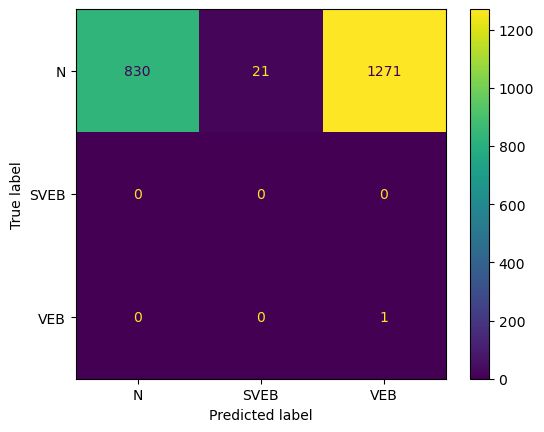

Fold 9:
  Test:  patient=8


C:\Users\matte\anaconda3\envs\DMML\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matte\anaconda3\envs\DMML\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matte\anaconda3\envs\DMML\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matte\anaconda3\envs\DMML\lib\site-packa

              precision    recall  f1-score   support

         0.0       1.00      0.85      0.92      2536
         1.0       0.01      1.00      0.02         2
         2.0       0.00      0.00      0.00         0

    accuracy                           0.85      2538
   macro avg       0.34      0.62      0.31      2538
weighted avg       1.00      0.85      0.92      2538

                   0.0       1.0  2.0  accuracy    macro avg  weighted avg
precision     1.000000  0.008439  0.0  0.851852     0.336146      0.999219
recall        0.851735  1.000000  NaN  0.851852     0.617245      0.851852
f1-score      0.919932  0.016736  NaN  0.851852     0.312223      0.919220
support    2536.000000  2.000000  0.0  0.851852  2538.000000   2538.000000


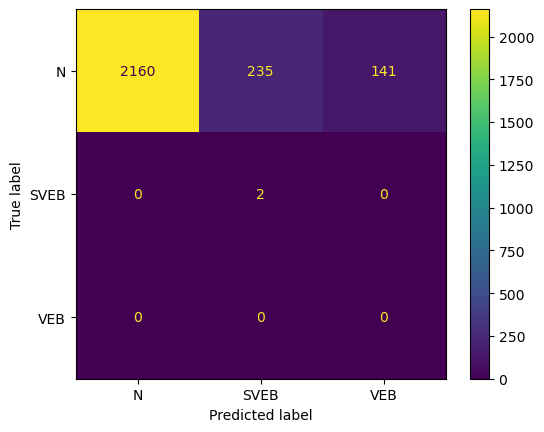

Fold 10:
  Test:  patient=9
              precision    recall  f1-score   support

         0.0       1.00      0.91      0.95      1788
         1.0       0.01      0.17      0.01         6
         2.0       0.00      0.00      0.00         0

    accuracy                           0.91      1794
   macro avg       0.33      0.36      0.32      1794
weighted avg       1.00      0.91      0.95      1794

                   0.0       1.0  2.0  accuracy    macro avg  weighted avg
precision     0.998769  0.006024  0.0   0.90524     0.334931      0.995449
recall        0.907718  0.166667  NaN   0.90524     0.358128      0.905240
f1-score      0.951069  0.011628  NaN   0.90524     0.320899      0.947927
support    1788.000000  6.000000  0.0   0.90524  1794.000000   1794.000000


C:\Users\matte\anaconda3\envs\DMML\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matte\anaconda3\envs\DMML\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matte\anaconda3\envs\DMML\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matte\anaconda3\envs\DMML\lib\site-packa

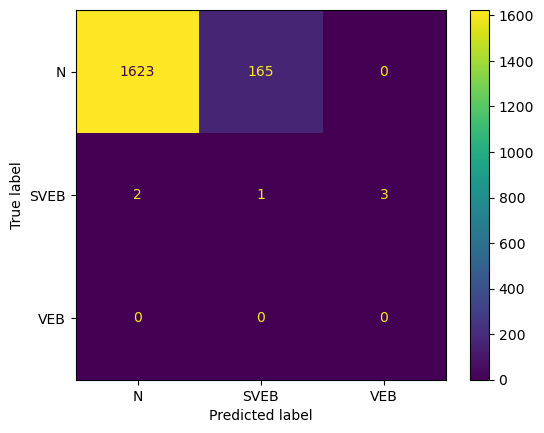

Fold 11:
  Test:  patient=10


C:\Users\matte\anaconda3\envs\DMML\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matte\anaconda3\envs\DMML\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matte\anaconda3\envs\DMML\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matte\anaconda3\

              precision    recall  f1-score   support

         0.0       0.99      0.46      0.63      1819
         1.0       0.00      0.00      0.00        12
         2.0       0.04      0.86      0.07        43

    accuracy                           0.47      1874
   macro avg       0.34      0.44      0.23      1874
weighted avg       0.96      0.47      0.61      1874

                   0.0   1.0        2.0  accuracy    macro avg  weighted avg
precision     0.990588   NaN   0.036133   0.46905     0.342240      0.962345
recall        0.462892   0.0   0.860465   0.46905     0.441119      0.469050
f1-score      0.630948   NaN   0.069353   0.46905     0.233434      0.614022
support    1819.000000  12.0  43.000000   0.46905  1874.000000   1874.000000


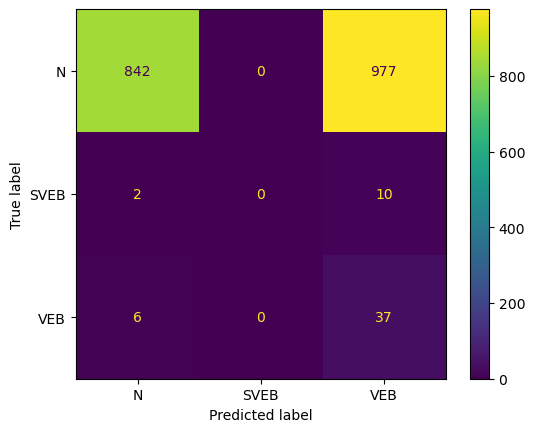

Fold 12:
  Test:  patient=11


C:\Users\matte\anaconda3\envs\DMML\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matte\anaconda3\envs\DMML\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matte\anaconda3\envs\DMML\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matte\anaconda3\envs\DMML\lib\site-packa

              precision    recall  f1-score   support

         0.0       1.00      0.88      0.94      1952
         1.0       0.00      0.00      0.00         0
         2.0       0.00      0.00      0.00         0

    accuracy                           0.88      1952
   macro avg       0.33      0.29      0.31      1952
weighted avg       1.00      0.88      0.94      1952

                   0.0  1.0  2.0  accuracy    macro avg  weighted avg
precision     1.000000  0.0  0.0  0.884221     0.333333      1.000000
recall        0.884221  NaN  NaN  0.884221     0.294740      0.884221
f1-score      0.938554  NaN  NaN  0.884221     0.312851      0.938554
support    1952.000000  0.0  0.0  0.884221  1952.000000   1952.000000


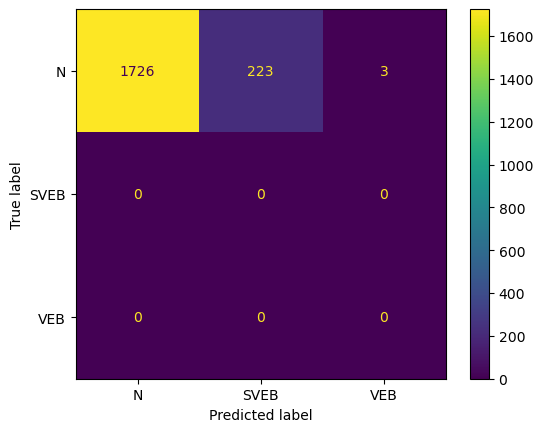

Fold 13:
  Test:  patient=12
              precision    recall  f1-score   support

         0.0       1.00      0.99      1.00      2301
         1.0       0.10      1.00      0.18         1
         2.0       0.95      0.97      0.96       109

    accuracy                           0.99      2411
   macro avg       0.68      0.99      0.71      2411
weighted avg       1.00      0.99      0.99      2411

                   0.0       1.0         2.0  accuracy    macro avg  \
precision     0.999127  0.100000    0.954955  0.993364     0.684694   
recall        0.994350  1.000000    0.972477  0.993364     0.988942   
f1-score      0.996733  0.181818    0.963636  0.993364     0.714062   
support    2301.000000  1.000000  109.000000  0.993364  2411.000000   

           weighted avg  
precision      0.996757  
recall         0.993364  
f1-score       0.994898  
support     2411.000000  


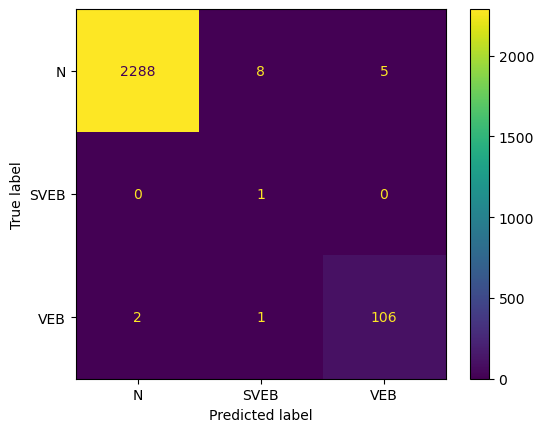

Fold 14:
  Test:  patient=13


C:\Users\matte\anaconda3\envs\DMML\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matte\anaconda3\envs\DMML\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matte\anaconda3\envs\DMML\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matte\anaconda3\envs\DMML\lib\site-packa

              precision    recall  f1-score   support

         0.0       1.00      0.96      0.98      1533
         1.0       0.00      0.00      0.00         1
         2.0       0.00      0.00      0.00         0

    accuracy                           0.96      1534
   macro avg       0.33      0.32      0.33      1534
weighted avg       1.00      0.96      0.98      1534

                   0.0  1.0  2.0  accuracy    macro avg  weighted avg
precision     1.000000  0.0  0.0  0.962842     0.333333      0.999348
recall        0.963470  0.0  NaN  0.962842     0.321157      0.962842
f1-score      0.981395  0.0  NaN  0.962842     0.327132      0.980756
support    1533.000000  1.0  0.0  0.962842  1534.000000   1534.000000


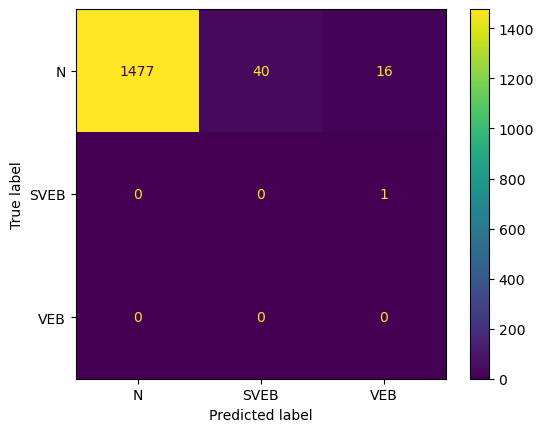

Fold 15:
  Test:  patient=14
              precision    recall  f1-score   support

         0.0       0.99      0.91      0.94      2165
         1.0       0.83      0.26      0.40        96
         2.0       0.05      0.88      0.10        16

    accuracy                           0.88      2277
   macro avg       0.62      0.68      0.48      2277
weighted avg       0.97      0.88      0.92      2277

                   0.0        1.0        2.0  accuracy    macro avg  \
precision     0.985930   0.833333   0.054475  0.878788     0.624579   
recall        0.906236   0.260417   0.875000  0.878788     0.680551   
f1-score      0.944404   0.396825   0.102564  0.878788     0.481265   
support    2165.000000  96.000000  16.000000  0.878788  2277.000000   

           weighted avg  
precision      0.972951  
recall         0.878788  
f1-score       0.915403  
support     2277.000000  


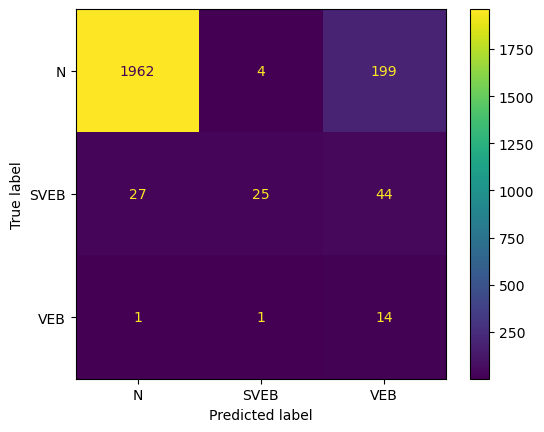

Fold 16:
  Test:  patient=15
              precision    recall  f1-score   support

         0.0       0.95      1.00      0.97      1542
         1.0       0.00      0.00      0.00         0
         2.0       1.00      0.80      0.89       444

    accuracy                           0.95      1986
   macro avg       0.65      0.60      0.62      1986
weighted avg       0.96      0.95      0.95      1986

                   0.0  1.0         2.0  accuracy    macro avg  weighted avg
precision     0.945913  0.0    1.000000  0.953676     0.648638      0.958005
recall        0.998054  NaN    0.799550  0.953676     0.599201      0.953676
f1-score      0.971284  NaN    0.888611  0.953676     0.619965      0.952801
support    1542.000000  0.0  444.000000  0.953676  1986.000000   1986.000000


C:\Users\matte\anaconda3\envs\DMML\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matte\anaconda3\envs\DMML\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matte\anaconda3\envs\DMML\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matte\anaconda3\envs\DMML\lib\site-packa

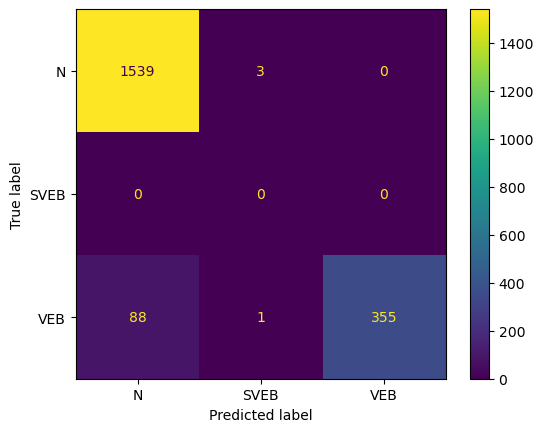

Fold 17:
  Test:  patient=16
              precision    recall  f1-score   support

         0.0       1.00      0.84      0.91      1860
         1.0       0.00      1.00      0.01         1
         2.0       0.04      1.00      0.07         1

    accuracy                           0.84      1862
   macro avg       0.35      0.95      0.33      1862
weighted avg       1.00      0.84      0.91      1862

                   0.0       1.0       2.0  accuracy    macro avg  \
precision     1.000000  0.003717  0.038462  0.842642     0.347393   
recall        0.842473  1.000000  1.000000  0.842642     0.947491   
f1-score      0.914502  0.007407  0.074074  0.842642     0.331995   
support    1860.000000  1.000000  1.000000  0.842642  1862.000000   

           weighted avg  
precision      0.998949  
recall         0.842642  
f1-score       0.913564  
support     1862.000000  


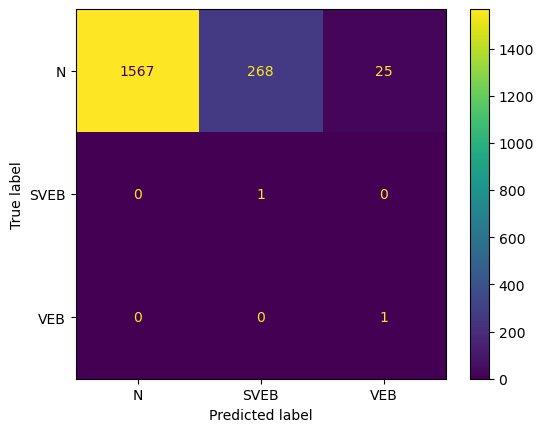

Fold 18:
  Test:  patient=17
              precision    recall  f1-score   support

         0.0       1.00      0.95      0.98      2475
         1.0       0.00      0.00      0.00         0
         2.0       0.00      0.00      0.00         0

    accuracy                           0.95      2475
   macro avg       0.33      0.32      0.33      2475
weighted avg       1.00      0.95      0.98      2475

                   0.0  1.0  2.0  accuracy    macro avg  weighted avg
precision     1.000000  0.0  0.0  0.953939     0.333333      1.000000
recall        0.953939  NaN  NaN  0.953939     0.317980      0.953939
f1-score      0.976427  NaN  NaN  0.953939     0.325476      0.976427
support    2475.000000  0.0  0.0  0.953939  2475.000000   2475.000000


C:\Users\matte\anaconda3\envs\DMML\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matte\anaconda3\envs\DMML\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matte\anaconda3\envs\DMML\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matte\anaconda3\envs\DMML\lib\site-packa

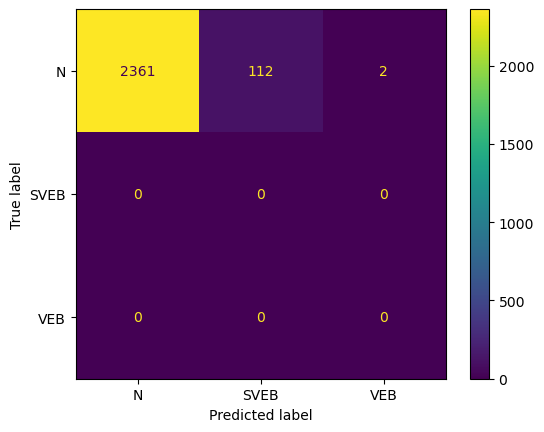

Fold 19:
  Test:  patient=18
              precision    recall  f1-score   support

         0.0       1.00      0.97      0.99      1514
         1.0       0.00      0.00      0.00         0
         2.0       0.00      0.00      0.00         3

    accuracy                           0.97      1517
   macro avg       0.33      0.32      0.33      1517
weighted avg       1.00      0.97      0.98      1517

                   0.0  1.0  2.0  accuracy    macro avg  weighted avg
precision     1.000000  0.0  NaN  0.969677     0.333333      0.998022
recall        0.971598  NaN  0.0  0.969677     0.323866      0.969677
f1-score      0.985595  NaN  NaN  0.969677     0.328532      0.983646
support    1514.000000  0.0  3.0  0.969677  1517.000000   1517.000000


C:\Users\matte\anaconda3\envs\DMML\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matte\anaconda3\envs\DMML\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matte\anaconda3\envs\DMML\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matte\anaconda3\envs\DMM

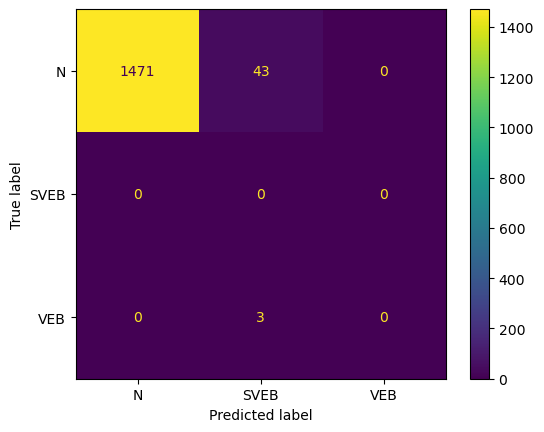

Fold 20:
  Test:  patient=19
              precision    recall  f1-score   support

         0.0       0.98      0.76      0.86      1535
         1.0       0.00      0.00      0.00        31
         2.0       0.09      0.74      0.15        47

    accuracy                           0.75      1613
   macro avg       0.36      0.50      0.34      1613
weighted avg       0.94      0.75      0.82      1613

                   0.0   1.0        2.0  accuracy    macro avg  weighted avg
precision     0.980721   0.0   0.085575  0.747055     0.355432      0.935790
recall        0.762215   0.0   0.744681  0.747055     0.502299      0.747055
f1-score      0.857771   0.0   0.153509  0.747055     0.337093      0.820765
support    1535.000000  31.0  47.000000  0.747055  1613.000000   1613.000000


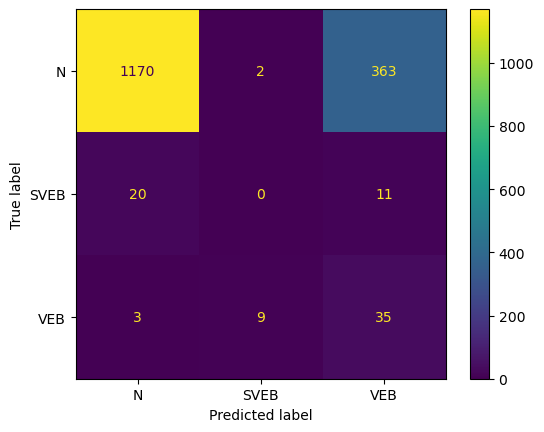

Fold 21:
  Test:  patient=20
              precision    recall  f1-score   support

         0.0       0.97      0.85      0.91      1742
         1.0       0.04      0.20      0.06        30
         2.0       0.86      0.94      0.90       826

    accuracy                           0.87      2598
   macro avg       0.62      0.67      0.62      2598
weighted avg       0.92      0.87      0.89      2598

                   0.0        1.0         2.0  accuracy    macro avg  \
precision     0.969261   0.038217    0.855263  0.872979     0.620914   
recall        0.850746   0.200000    0.944310  0.872979     0.665019   
f1-score      0.906145   0.064171    0.897583  0.872979     0.622633   
support    1742.000000  30.000000  826.000000  0.872979  2598.000000   

           weighted avg  
precision      0.922266  
recall         0.872979  
f1-score       0.893700  
support     2598.000000  


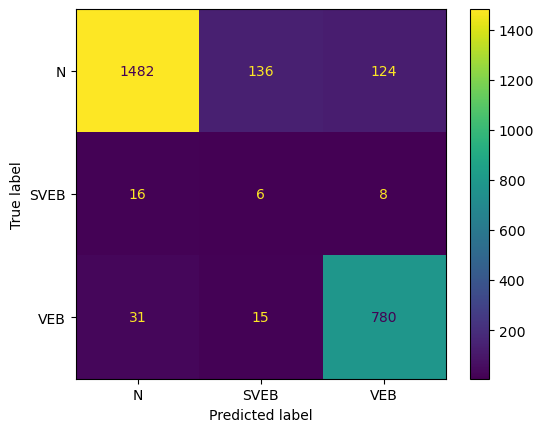

Fold 22:
  Test:  patient=21
              precision    recall  f1-score   support

         0.0       0.94      0.69      0.80      1634
         1.0       0.09      0.42      0.15       128
         2.0       0.50      0.47      0.48       198

    accuracy                           0.65      1960
   macro avg       0.51      0.53      0.48      1960
weighted avg       0.84      0.65      0.72      1960

                   0.0         1.0         2.0  accuracy    macro avg  \
precision     0.943333    0.094241    0.497326  0.652551     0.511633   
recall        0.692778    0.421875    0.469697  0.652551     0.528117   
f1-score      0.798871    0.154066    0.483117  0.652551     0.478684   
support    1634.000000  128.000000  198.000000  0.652551  1960.000000   

           weighted avg  
precision      0.842827  
recall         0.652551  
f1-score       0.724864  
support     1960.000000  


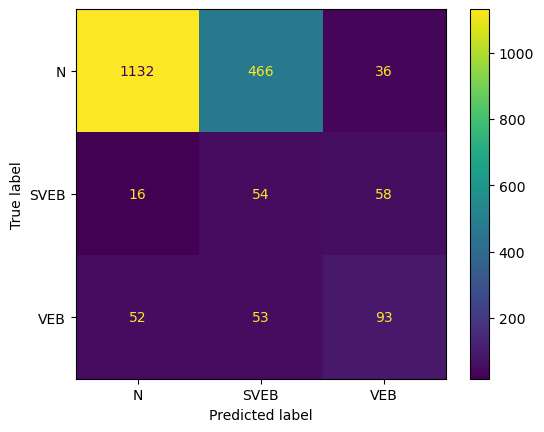

Fold 23:
  Test:  patient=22
              precision    recall  f1-score   support

         0.0       0.99      0.67      0.80      2060
         1.0       0.04      0.44      0.07        55
         2.0       0.24      0.84      0.38        19

    accuracy                           0.66      2134
   macro avg       0.42      0.65      0.41      2134
weighted avg       0.96      0.66      0.78      2134

                   0.0        1.0        2.0  accuracy    macro avg  \
precision     0.992780   0.035139   0.242424  0.663074     0.423448   
recall        0.667476   0.436364   0.842105  0.663074     0.648648   
f1-score      0.798258   0.065041   0.376471  0.663074     0.413257   
support    2060.000000  55.000000  19.000000  0.663074  2134.000000   

           weighted avg  
precision      0.961418  
recall         0.663074  
f1-score       0.775606  
support     2134.000000  


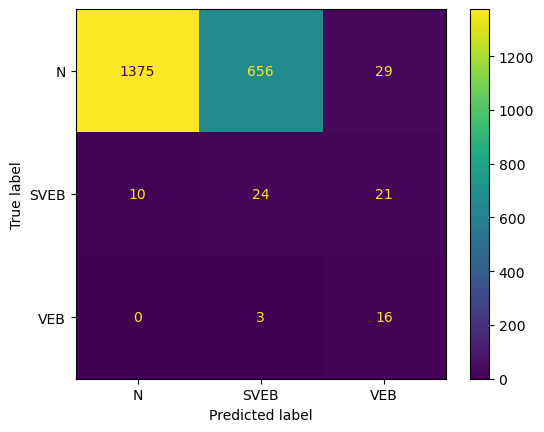

Fold 24:
  Test:  patient=23
              precision    recall  f1-score   support

         0.0       0.98      0.65      0.78      2528
         1.0       0.01      0.50      0.01         2
         2.0       0.35      0.90      0.51       444

    accuracy                           0.69      2974
   macro avg       0.45      0.68      0.43      2974
weighted avg       0.89      0.69      0.74      2974

                   0.0       1.0         2.0  accuracy    macro avg  \
precision     0.980986  0.006211    0.353097  0.689644     0.446765   
recall        0.653085  0.500000    0.898649  0.689644     0.683911   
f1-score      0.784137  0.012270    0.506989  0.689644     0.434465   
support    2528.000000  2.000000  444.000000  0.689644  2974.000000   

           weighted avg  
precision      0.886591  
recall         0.689644  
f1-score       0.742241  
support     2974.000000  


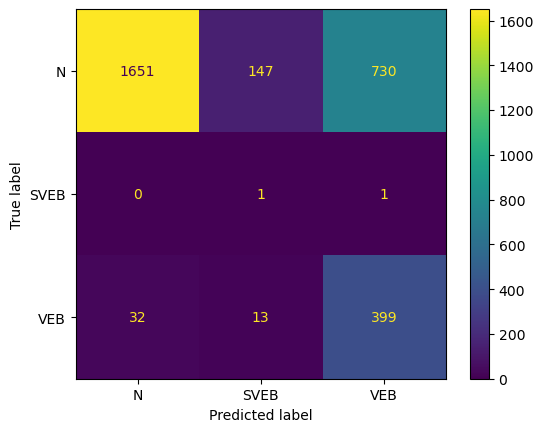

Fold 25:
  Test:  patient=24
              precision    recall  f1-score   support

         0.0       1.00      0.86      0.93      2570
         1.0       0.01      1.00      0.02         3
         2.0       1.00      0.79      0.88        71

    accuracy                           0.86      2644
   macro avg       0.67      0.88      0.61      2644
weighted avg       1.00      0.86      0.92      2644

                   0.0       1.0        2.0  accuracy    macro avg  \
precision     0.997301  0.008219   1.000000  0.860817     0.668507   
recall        0.862646  1.000000   0.788732  0.860817     0.883793   
f1-score      0.925099  0.016304   0.881890  0.860817     0.607764   
support    2570.000000  3.000000  71.000000  0.860817  2644.000000   

           weighted avg  
precision      0.996251  
recall         0.860817  
f1-score       0.922908  
support     2644.000000  


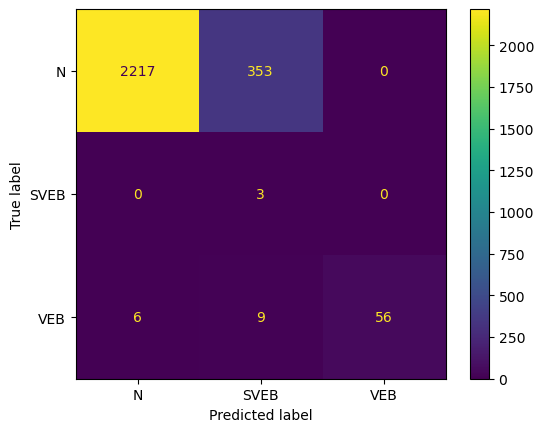

Fold 26:
  Test:  patient=25
              precision    recall  f1-score   support

         0.0       0.76      0.14      0.23      1543
         1.0       0.00      0.00      0.00       106
         2.0       0.08      0.60      0.14       210

    accuracy                           0.18      1859
   macro avg       0.28      0.25      0.13      1859
weighted avg       0.64      0.18      0.21      1859

                   0.0    1.0         2.0  accuracy    macro avg  weighted avg
precision     0.758865    0.0    0.081567  0.183432     0.280144      0.639085
recall        0.138691    0.0    0.604762  0.183432     0.247818      0.183432
f1-score      0.234521    0.0    0.143746  0.183432     0.126089      0.210894
support    1543.000000  106.0  210.000000  0.183432  1859.000000   1859.000000


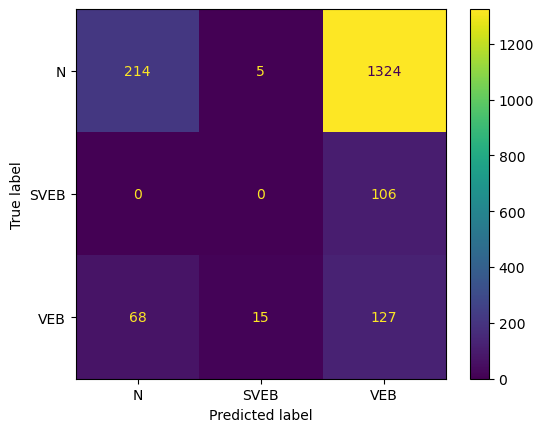

Fold 27:
  Test:  patient=26
              precision    recall  f1-score   support

         0.0       0.86      0.89      0.88      1585
         1.0       0.00      0.50      0.01         2
         2.0       0.97      0.55      0.70       992

    accuracy                           0.76      2579
   macro avg       0.61      0.65      0.53      2579
weighted avg       0.91      0.76      0.81      2579

                   0.0       1.0         2.0  accuracy    macro avg  \
precision     0.863720  0.002558    0.974955   0.75727     0.613744   
recall        0.887697  0.500000    0.549395   0.75727     0.645697   
f1-score      0.875544  0.005089    0.702772   0.75727     0.527802   
support    1585.000000  2.000000  992.000000   0.75727  2579.000000   

           weighted avg  
precision      0.905838  
recall         0.757270  
f1-score       0.808414  
support     2579.000000  


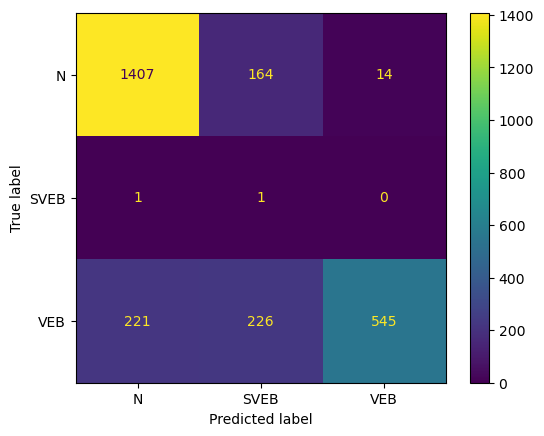

Fold 28:
  Test:  patient=27
              precision    recall  f1-score   support

         0.0       0.93      0.89      0.91      2620
         1.0       0.41      0.47      0.44       383
         2.0       0.03      1.00      0.06         1

    accuracy                           0.84      3004
   macro avg       0.45      0.79      0.47      3004
weighted avg       0.86      0.84      0.85      3004

                   0.0         1.0       2.0  accuracy    macro avg  \
precision     0.925119    0.406742  0.028571  0.837883     0.453477   
recall        0.891221    0.472585  1.000000  0.837883     0.787935   
f1-score      0.907854    0.437198  0.055556  0.837883     0.466869   
support    2620.000000  383.000000  1.000000  0.837883  3004.000000   

           weighted avg  
precision      0.858729  
recall         0.837883  
f1-score       0.847563  
support     3004.000000  


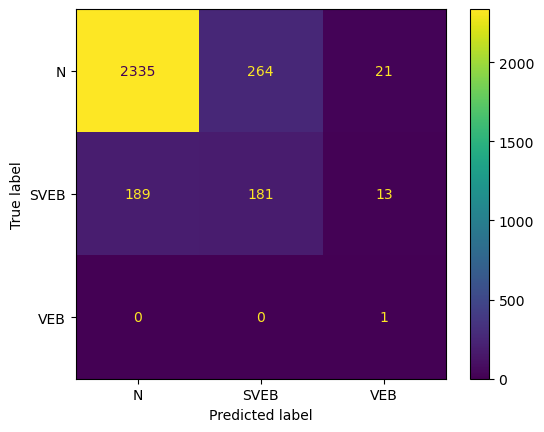

Fold 29:
  Test:  patient=28
              precision    recall  f1-score   support

         0.0       0.99      0.85      0.91      2422
         1.0       0.05      0.91      0.10        22
         2.0       0.37      0.32      0.34       195

    accuracy                           0.81      2639
   macro avg       0.47      0.69      0.45      2639
weighted avg       0.93      0.81      0.87      2639

                   0.0        1.0         2.0  accuracy    macro avg  \
precision     0.987088   0.052632    0.369048  0.813187     0.469589   
recall        0.852188   0.909091    0.317949  0.813187     0.693076   
f1-score      0.914691   0.099502    0.341598  0.813187     0.451930   
support    2422.000000  22.000000  195.000000  0.813187  2639.000000   

           weighted avg  
precision      0.933629  
recall         0.813187  
f1-score       0.865548  
support     2639.000000  


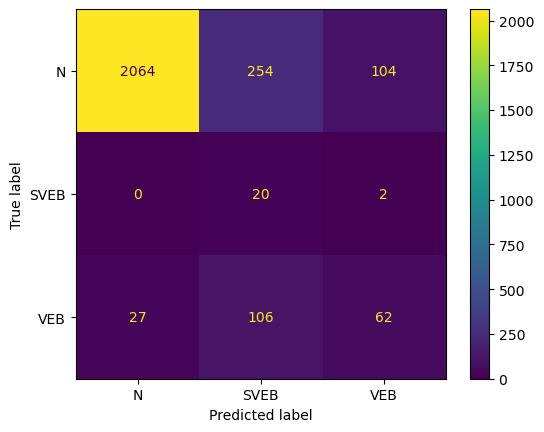

Fold 30:
  Test:  patient=29
              precision    recall  f1-score   support

         0.0       1.00      0.61      0.76      2747
         1.0       0.00      0.00      0.00         0
         2.0       0.00      0.00      0.00         0

    accuracy                           0.61      2747
   macro avg       0.33      0.20      0.25      2747
weighted avg       1.00      0.61      0.76      2747

                   0.0  1.0  2.0  accuracy    macro avg  weighted avg
precision     1.000000  0.0  0.0   0.60648     0.333333      1.000000
recall        0.606480  NaN  NaN   0.60648     0.202160      0.606480
f1-score      0.755042  NaN  NaN   0.60648     0.251681      0.755042
support    2747.000000  0.0  0.0   0.60648  2747.000000   2747.000000


C:\Users\matte\anaconda3\envs\DMML\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matte\anaconda3\envs\DMML\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matte\anaconda3\envs\DMML\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matte\anaconda3\envs\DMML\lib\site-packa

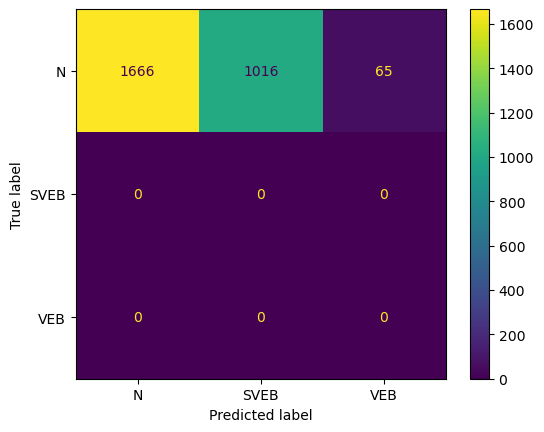

Fold 31:
  Test:  patient=30
              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99      2640
         1.0       0.09      0.07      0.08        28
         2.0       0.88      0.95      0.91       220

    accuracy                           0.98      2888
   macro avg       0.65      0.67      0.66      2888
weighted avg       0.98      0.98      0.98      2888

                   0.0        1.0         2.0  accuracy    macro avg  \
precision     0.993153   0.086957    0.881356  0.976801     0.653822   
recall        0.989015   0.071429    0.945455  0.976801     0.668633   
f1-score      0.991080   0.078431    0.912281  0.976801     0.660597   
support    2640.000000  28.000000  220.000000  0.976801  2888.000000   

           weighted avg  
precision      0.975851  
recall         0.976801  
f1-score       0.976229  
support     2888.000000  


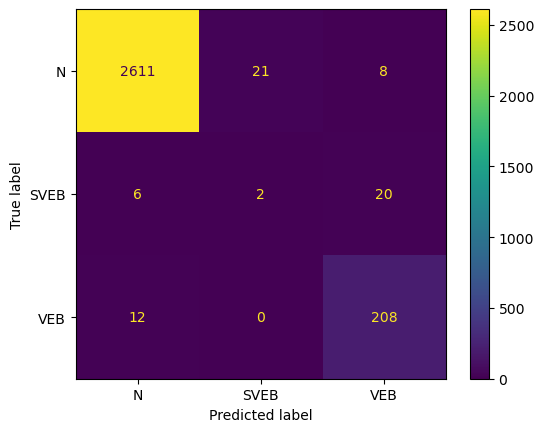

Fold 32:
  Test:  patient=31
              precision    recall  f1-score   support

         0.0       0.99      0.78      0.87      2002
         1.0       0.00      0.00      0.00         0
         2.0       0.43      0.88      0.58       256

    accuracy                           0.79      2258
   macro avg       0.47      0.55      0.48      2258
weighted avg       0.92      0.79      0.84      2258

                   0.0  1.0         2.0  accuracy    macro avg  weighted avg
precision     0.987318  0.0    0.434951  0.788751     0.474090      0.924693
recall        0.777722  NaN    0.875000  0.788751     0.550907      0.788751
f1-score      0.870075  NaN    0.581064  0.788751     0.483713      0.837309
support    2002.000000  0.0  256.000000  0.788751  2258.000000   2258.000000


C:\Users\matte\anaconda3\envs\DMML\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matte\anaconda3\envs\DMML\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matte\anaconda3\envs\DMML\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matte\anaconda3\envs\DMML\lib\site-packa

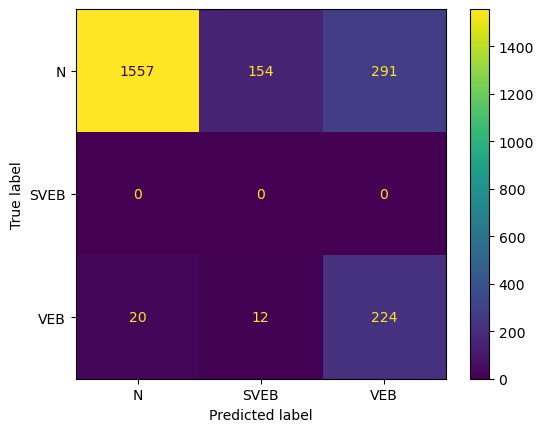

Fold 33:
  Test:  patient=32
              precision    recall  f1-score   support

         0.0       0.98      0.44      0.61      3194
         1.0       0.00      1.00      0.00         3
         2.0       0.93      0.77      0.84       164

    accuracy                           0.46      3361
   macro avg       0.64      0.74      0.48      3361
weighted avg       0.98      0.46      0.62      3361

                   0.0       1.0         2.0  accuracy    macro avg  \
precision     0.983916  0.001671    0.926471  0.457007     0.637353   
recall        0.440513  1.000000    0.768293  0.457007     0.736269   
f1-score      0.608564  0.003337    0.840000  0.457007     0.483967   
support    3194.000000  3.000000  164.000000  0.457007  3361.000000   

           weighted avg  
precision      0.980236  
recall         0.457007  
f1-score       0.619317  
support     3361.000000  


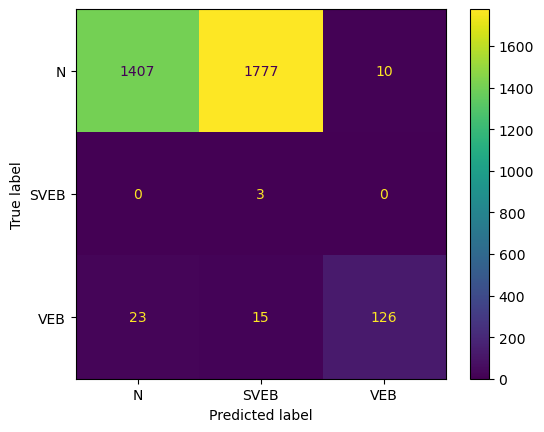

Fold 34:
  Test:  patient=33
              precision    recall  f1-score   support

         0.0       1.00      0.92      0.96      2081
         1.0       0.00      0.00      0.00         7
         2.0       0.33      0.89      0.48        64

    accuracy                           0.91      2152
   macro avg       0.44      0.60      0.48      2152
weighted avg       0.97      0.91      0.94      2152

                   0.0  1.0        2.0  accuracy    macro avg  weighted avg
precision     0.995313  0.0   0.327586  0.914498     0.440966      0.972217
recall        0.918309  0.0   0.890625  0.914498     0.602978      0.914498
f1-score      0.955261  0.0   0.478992  0.914498     0.478084      0.937990
support    2081.000000  7.0  64.000000  0.914498  2152.000000   2152.000000


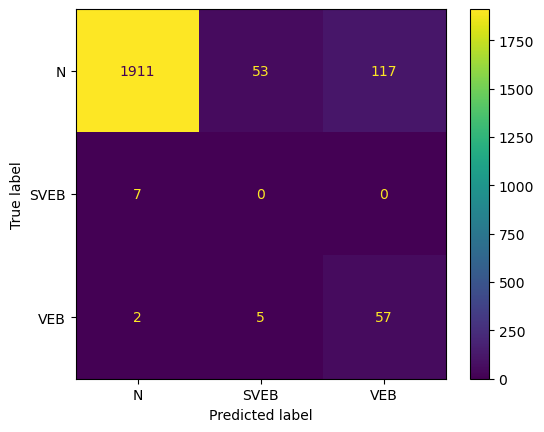

Fold 35:
  Test:  patient=34
              precision    recall  f1-score   support

         0.0       0.99      0.43      0.60      1953
         1.0       0.07      0.87      0.13        94
         2.0       0.00      0.00      0.00         0

    accuracy                           0.45      2047
   macro avg       0.35      0.43      0.24      2047
weighted avg       0.95      0.45      0.58      2047

                   0.0        1.0  2.0  accuracy    macro avg  weighted avg
precision     0.988290   0.068908  0.0  0.452369     0.352399      0.946072
recall        0.432156   0.872340  NaN  0.452369     0.434832      0.452369
f1-score      0.601354   0.127726  NaN  0.452369     0.243027      0.579604
support    1953.000000  94.000000  0.0  0.452369  2047.000000   2047.000000


C:\Users\matte\anaconda3\envs\DMML\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matte\anaconda3\envs\DMML\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matte\anaconda3\envs\DMML\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matte\anaconda3\envs\DMML\lib\site-packa

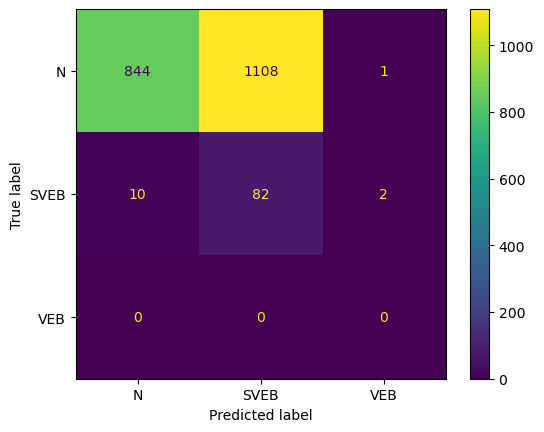

Fold 36:
  Test:  patient=35


C:\Users\matte\anaconda3\envs\DMML\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matte\anaconda3\envs\DMML\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matte\anaconda3\envs\DMML\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matte\anaconda3\envs\DMML\lib\site-packa

              precision    recall  f1-score   support

         0.0       1.00      0.82      0.90      2030
         1.0       0.00      0.00      0.00         0
         2.0       0.84      0.94      0.89       396

    accuracy                           0.84      2426
   macro avg       0.61      0.59      0.60      2426
weighted avg       0.97      0.84      0.90      2426

                   0.0  1.0         2.0  accuracy    macro avg  weighted avg
precision     0.998807  0.0    0.836323  0.843776     0.611710      0.972284
recall        0.824631  NaN    0.941919  0.843776     0.588850      0.843776
f1-score      0.903400  NaN    0.885986  0.843776     0.596462      0.900557
support    2030.000000  0.0  396.000000  0.843776  2426.000000   2426.000000


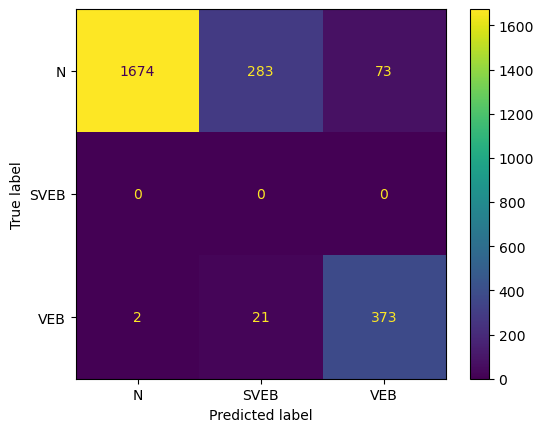

Fold 37:
  Test:  patient=36
              precision    recall  f1-score   support

         0.0       0.99      0.41      0.58      2273
         1.0       0.17      0.91      0.29       209
         2.0       0.00      0.00      0.00         0

    accuracy                           0.45      2482
   macro avg       0.39      0.44      0.29      2482
weighted avg       0.92      0.45      0.55      2482

                   0.0         1.0  2.0  accuracy    macro avg  weighted avg
precision     0.989362    0.171147  0.0  0.451652     0.386836      0.920463
recall        0.409151    0.913876  NaN  0.451652     0.441009      0.451652
f1-score      0.578898    0.288302  NaN  0.451652     0.289067      0.554428
support    2273.000000  209.000000  0.0  0.451652  2482.000000   2482.000000


C:\Users\matte\anaconda3\envs\DMML\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matte\anaconda3\envs\DMML\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matte\anaconda3\envs\DMML\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matte\anaconda3\envs\DMML\lib\site-packa

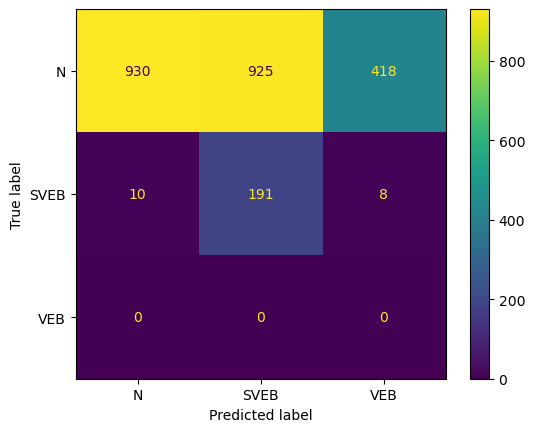

Fold 38:
  Test:  patient=37
              precision    recall  f1-score   support

         0.0       0.95      0.82      0.88      2044
         1.0       0.13      0.52      0.21        73
         2.0       0.70      0.80      0.75       473

    accuracy                           0.81      2590
   macro avg       0.60      0.71      0.61      2590
weighted avg       0.88      0.81      0.84      2590

                   0.0        1.0         2.0  accuracy    macro avg  \
precision     0.949604   0.132867    0.702602  0.808108     0.595024   
recall        0.820450   0.520548    0.799154  0.808108     0.713384   
f1-score      0.880315   0.211699    0.747774  0.808108     0.613263   
support    2044.000000  73.000000  473.000000  0.808108  2590.000000   

           weighted avg  
precision      0.881475  
recall         0.808108  
f1-score       0.837265  
support     2590.000000  


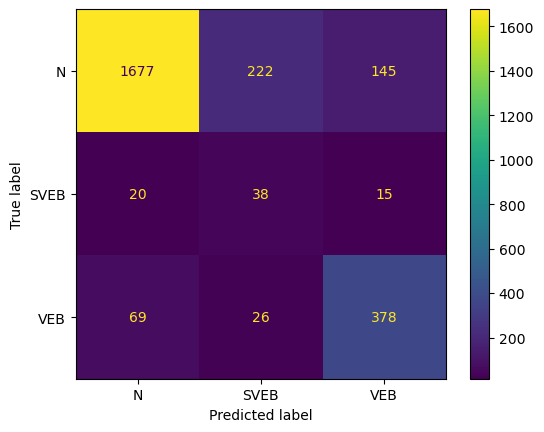

Fold 39:
  Test:  patient=38
              precision    recall  f1-score   support

         0.0       0.54      0.09      0.16      1687
         1.0       0.02      0.67      0.03         3
         2.0       0.10      0.46      0.16       362

    accuracy                           0.16      2052
   macro avg       0.22      0.40      0.12      2052
weighted avg       0.46      0.16      0.16      2052

                   0.0       1.0         2.0  accuracy    macro avg  \
precision     0.536082  0.017544    0.100182  0.157407     0.217936   
recall        0.092472  0.666667    0.455801  0.157407     0.404980   
f1-score      0.157735  0.034188    0.164261  0.157407     0.118728   
support    1687.000000  3.000000  362.000000  0.157407  2052.000000   

           weighted avg  
precision      0.458426  
recall         0.157407  
f1-score       0.158706  
support     2052.000000  


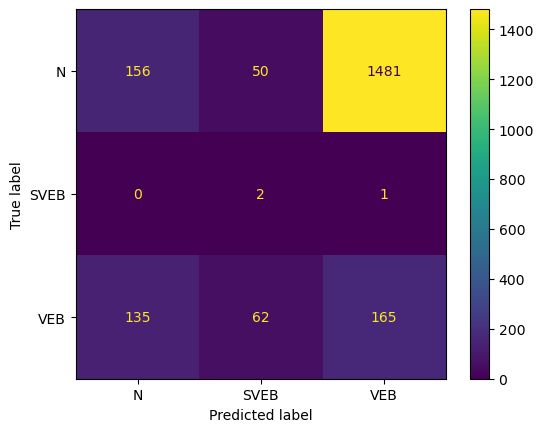

Fold 40:
  Test:  patient=39
              precision    recall  f1-score   support

         0.0       1.00      0.70      0.83      2254
         1.0       0.00      0.00      0.00         0
         2.0       0.00      1.00      0.01         1

    accuracy                           0.70      2255
   macro avg       0.33      0.57      0.28      2255
weighted avg       1.00      0.70      0.83      2255

                   0.0  1.0       2.0  accuracy    macro avg  weighted avg
precision     1.000000  0.0  0.003922  0.704213     0.334641      0.999558
recall        0.704082  NaN  1.000000  0.704213     0.568027      0.704213
f1-score      0.826347  NaN  0.007812  0.704213     0.278053      0.825984
support    2254.000000  0.0  1.000000  0.704213  2255.000000   2255.000000


C:\Users\matte\anaconda3\envs\DMML\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matte\anaconda3\envs\DMML\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matte\anaconda3\envs\DMML\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matte\anaconda3\envs\DMML\lib\site-packa

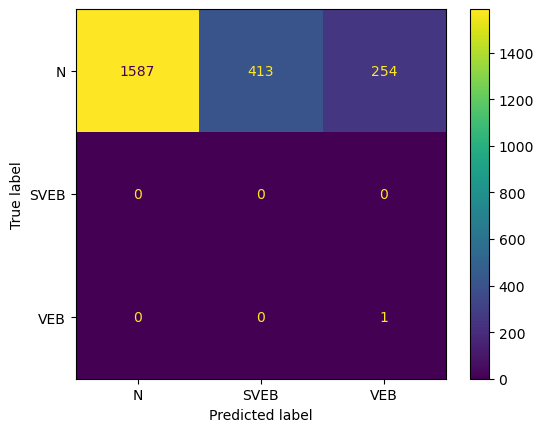

Fold 41:
  Test:  patient=40
              precision    recall  f1-score   support

         0.0       1.00      0.78      0.88      1567
         1.0       0.00      1.00      0.01         1
         2.0       0.00      0.00      0.00         2

    accuracy                           0.78      1570
   macro avg       0.33      0.59      0.30      1570
weighted avg       1.00      0.78      0.88      1570

                   0.0       1.0  2.0  accuracy    macro avg  weighted avg
precision     1.000000  0.003155  0.0  0.782803     0.334385      0.998091
recall        0.783663  1.000000  0.0  0.782803     0.594554      0.782803
f1-score      0.878712  0.006289  0.0  0.782803     0.295000      0.877037
support    1567.000000  1.000000  2.0  0.782803  1570.000000   1570.000000


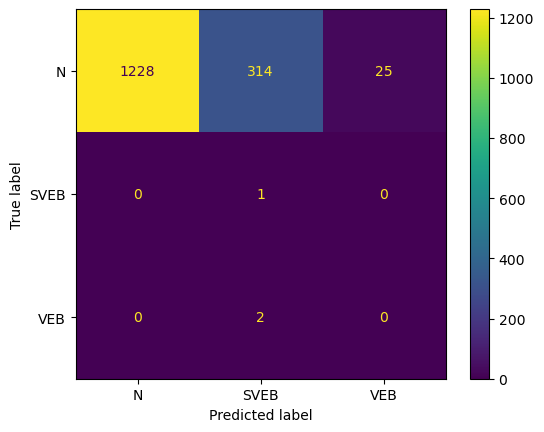

Fold 42:
  Test:  patient=41


C:\Users\matte\anaconda3\envs\DMML\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matte\anaconda3\envs\DMML\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matte\anaconda3\envs\DMML\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matte\anaconda3\envs\DMML\lib\site-packa

              precision    recall  f1-score   support

         0.0       0.33      0.96      0.49       398
         1.0       0.99      0.40      0.57      1381
         2.0       0.00      0.00      0.00         0

    accuracy                           0.53      1779
   macro avg       0.44      0.45      0.35      1779
weighted avg       0.84      0.53      0.55      1779

                  0.0          1.0  2.0  accuracy    macro avg  weighted avg
precision    0.329594     0.987478  0.0  0.525014     0.439024      0.840295
recall       0.959799     0.399710  NaN  0.525014     0.453170      0.525014
f1-score     0.490687     0.569072  NaN  0.525014     0.353253      0.551536
support    398.000000  1381.000000  0.0  0.525014  1779.000000   1779.000000


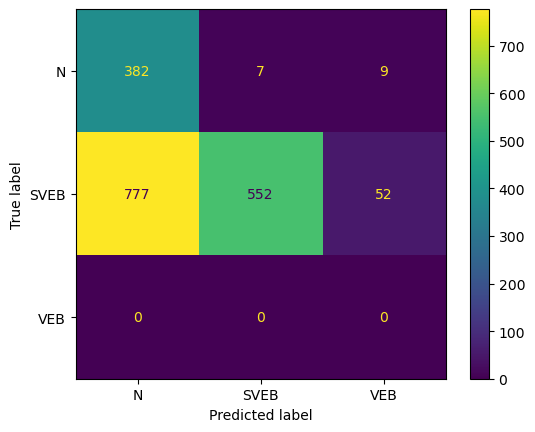

Fold 43:
  Test:  patient=42
              precision    recall  f1-score   support

         0.0       0.98      0.71      0.83      2229
         1.0       0.02      0.29      0.04         7
         2.0       0.55      0.90      0.68       831

    accuracy                           0.76      3067
   macro avg       0.52      0.63      0.52      3067
weighted avg       0.86      0.76      0.79      3067

                   0.0       1.0         2.0  accuracy    macro avg  \
precision     0.983313  0.022989    0.550661  0.763939     0.518987   
recall        0.713773  0.285714    0.902527  0.763939     0.634005   
f1-score      0.827138  0.042553    0.683995  0.763939     0.517895   
support    2229.000000  7.000000  831.000000  0.763939  3067.000000   

           weighted avg  
precision      0.863894  
recall         0.763939  
f1-score       0.786563  
support     3067.000000  


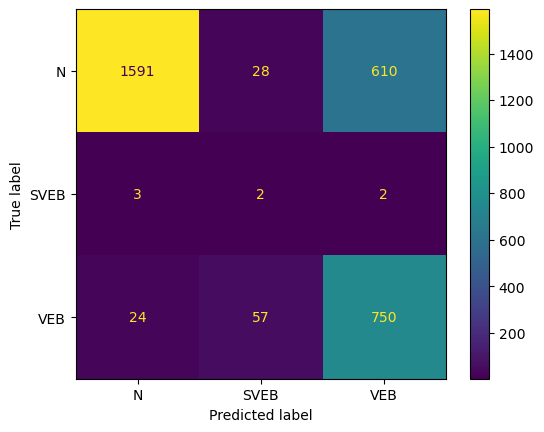

Fold 44:
  Test:  patient=43
              precision    recall  f1-score   support

         0.0       0.99      0.88      0.93      2699
         1.0       0.06      0.36      0.10        50
         2.0       0.21      1.00      0.35         3

    accuracy                           0.87      2752
   macro avg       0.42      0.75      0.46      2752
weighted avg       0.97      0.87      0.92      2752

                   0.0        1.0       2.0  accuracy    macro avg  \
precision     0.986755   0.055901  0.214286   0.87391     0.418980   
recall        0.883290   0.360000  1.000000   0.87391     0.747763   
f1-score      0.932160   0.096774  0.352941   0.87391     0.460625   
support    2699.000000  50.000000  3.000000   0.87391  2752.000000   

           weighted avg  
precision      0.969001  
recall         0.873910  
f1-score       0.916351  
support     2752.000000  


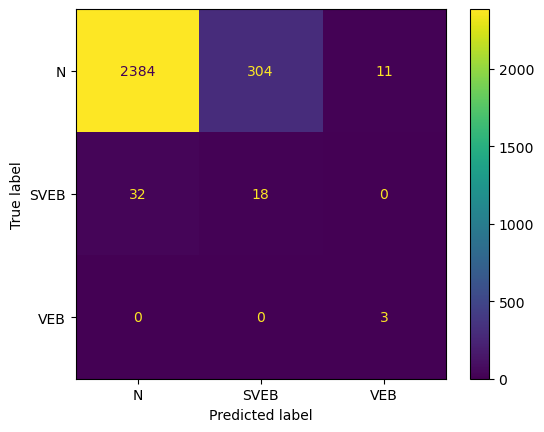

C:\Users\matte\anaconda3\envs\DMML\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\matte\anaconda3\envs\DMML\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [23]:
X=df_cardio.drop('type',axis=1)
y=df_cardio['type']
groups=df_cardio['patient']
skf = LeaveOneGroupOut()


start_time=time.time()
df_smote_PCA, acc_smote_PCA,confusion_matrix_final_smote,list_fscore_PCA = cross_valid(pipe_smote_PCA, skf, X, y,groups)
end_time=time.time()

In [24]:
df_smote_PCA

0.0        1.0         2.0    macro avg  weighted avg
f1-score      0.821393   0.126328    0.430322     0.412356      0.806366
precision     0.953824   0.088323    0.307207     0.448720      0.939882
recall        0.762110   0.514764    0.754769     0.573805      0.749585
support    2047.340909  63.159091  163.000000  2269.795455   2269.795455

In [26]:
confusion_matrix_final_smote

array([[68518., 10425., 11140.],
       [ 1151.,  1244.,   384.],
       [  919.,   695.,  5395.]])

In [27]:
list_fscore_PCA

{'patient0': {'0.0': 0.987106989368921,
  '1.0': 0.5283018867924528,
  '2.0': 0.11764705882352941,
  'macro avg': 0.5443519783283012,
  'weighted avg': 0.9800603219765052},
 'patient1': {'0.0': 0.9959514170040487,
  '1.0': 0.21052631578947367,
  'macro avg': 0.6032388663967612,
  'weighted avg': 0.9946859630278705},
 'patient2': {'0.0': 0.9806609547123624,
  '1.0': 0.09090909090909091,
  'macro avg': 0.35719001520715105,
  'weighted avg': 0.979806656235355},
 'patient3': {'0.0': 0.8025447690857681,
  '2.0': 0.04529201430274136,
  'macro avg': 0.28261226112950316,
  'weighted avg': 0.7904452511800377},
 'patient4': {'0.0': 0.9702905648057459,
  '2.0': 0.8924387646432375,
  'macro avg': 0.6209097764829945,
  'weighted avg': 0.9503088589397516},
 'patient5': {'0.0': 0.3974300137677834,
  '1.0': 0.16,
  '2.0': 0.012158054711246199,
  'macro avg': 0.18986268949300988,
  'weighted avg': 0.3931690232228787},
 'patient6': {'0.0': 0.974485596707819,
  '2.0': 0.40462427745664736,
  'macro avg': 

In [28]:
from sklearn.feature_selection import SelectKBest, mutual_info_classif
pipe_select_30 = Pipeline([
        ('f_classif', SelectKBest(mutual_info_classif, k=30)),
        ('sampling', SMOTE(random_state = 123)),
        ('classification', AdaBoostClassifier())
    ])
pipe_select_30

Pipeline(steps=[('f_classif',
                 SelectKBest(k=30,
                             score_func=<function mutual_info_classif at 0x000001E34C3003A0>)),
                ('sampling', SMOTE(random_state=123)),
                ('classification', AdaBoostClassifier())])

Fold 1:
  Test:  patient=0
              precision    recall  f1-score   support

         0.0       1.00      0.99      1.00      2238
         1.0       0.73      0.91      0.81        33
         2.0       0.14      1.00      0.25         1

    accuracy                           0.99      2272
   macro avg       0.62      0.97      0.69      2272
weighted avg       1.00      0.99      0.99      2272

                   0.0        1.0       2.0  accuracy    macro avg  \
precision     1.000000   0.731707  0.142857  0.992518     0.624855   
recall        0.993744   0.909091  1.000000  0.992518     0.967612   
f1-score      0.996862   0.810811  0.250000  0.992518     0.685891   
support    2238.000000  33.000000  1.000000  0.992518  2272.000000   

           weighted avg  
precision      0.995726  
recall         0.992518  
f1-score       0.993831  
support     2272.000000  


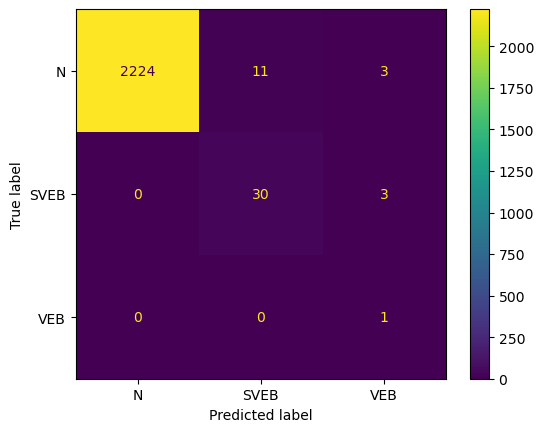

Fold 2:
  Test:  patient=1


C:\Users\matte\anaconda3\envs\DMML\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matte\anaconda3\envs\DMML\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matte\anaconda3\envs\DMML\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matte\anaconda3\envs\DMML\lib\site-packa

              precision    recall  f1-score   support

         0.0       1.00      0.97      0.98      1859
         1.0       0.00      0.00      0.00         3
         2.0       0.00      0.00      0.00         0

    accuracy                           0.97      1862
   macro avg       0.33      0.32      0.33      1862
weighted avg       1.00      0.97      0.98      1862

                   0.0  1.0  2.0  accuracy    macro avg  weighted avg
precision     0.999446  0.0  0.0  0.968314     0.333149      0.997835
recall        0.969876  0.0  NaN  0.968314     0.323292      0.968314
f1-score      0.984439  0.0  NaN  0.968314     0.328146      0.982853
support    1859.000000  3.0  0.0  0.968314  1862.000000   1862.000000


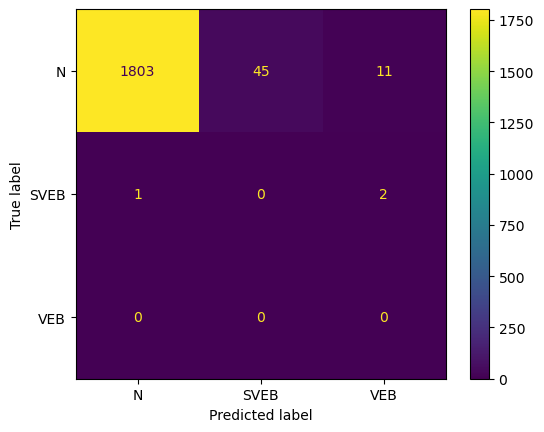

Fold 3:
  Test:  patient=2
              precision    recall  f1-score   support

         0.0       1.00      0.99      1.00      2081
         1.0       0.00      0.00      0.00         2
         2.0       0.00      0.00      0.00         0

    accuracy                           0.99      2083
   macro avg       0.33      0.33      0.33      2083
weighted avg       1.00      0.99      0.99      2083

                   0.0  1.0  2.0  accuracy    macro avg  weighted avg
precision     1.000000  0.0  0.0  0.989918     0.333333      0.999040
recall        0.990870  0.0  NaN  0.989918     0.330290      0.989918
f1-score      0.995414  0.0  NaN  0.989918     0.331805      0.994458
support    2081.000000  2.0  0.0  0.989918  2083.000000   2083.000000


C:\Users\matte\anaconda3\envs\DMML\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matte\anaconda3\envs\DMML\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matte\anaconda3\envs\DMML\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matte\anaconda3\envs\DMML\lib\site-packa

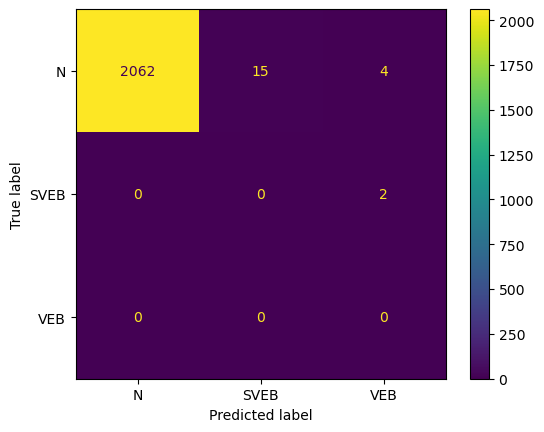

Fold 4:
  Test:  patient=3
              precision    recall  f1-score   support

         0.0       1.00      0.97      0.99      2525
         1.0       0.00      0.00      0.00         0
         2.0       0.27      0.66      0.38        41

    accuracy                           0.97      2566
   macro avg       0.42      0.54      0.46      2566
weighted avg       0.99      0.97      0.98      2566

                   0.0  1.0        2.0  accuracy    macro avg  weighted avg
precision     1.000000  0.0   0.270000  0.966095     0.423333      0.988336
recall        0.971089  NaN   0.658537  0.966095     0.543209      0.966095
f1-score      0.985333  NaN   0.382979  0.966095     0.456104      0.975708
support    2525.000000  0.0  41.000000  0.966095  2566.000000   2566.000000


C:\Users\matte\anaconda3\envs\DMML\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matte\anaconda3\envs\DMML\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matte\anaconda3\envs\DMML\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matte\anaconda3\envs\DMML\lib\site-packa

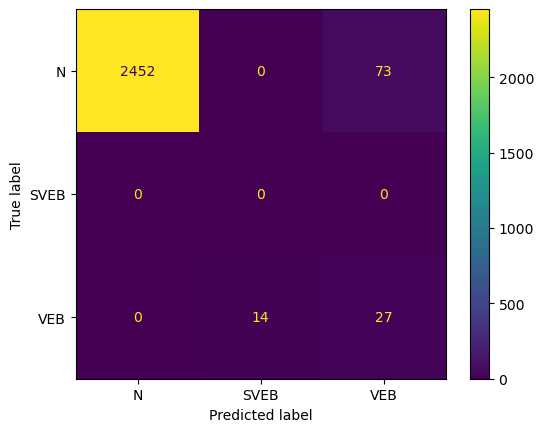

Fold 5:
  Test:  patient=4
              precision    recall  f1-score   support

         0.0       0.89      1.00      0.94      1506
         1.0       0.00      0.00      0.00         0
         2.0       1.00      0.63      0.77       520

    accuracy                           0.91      2026
   macro avg       0.63      0.54      0.57      2026
weighted avg       0.92      0.91      0.90      2026

                   0.0  1.0         2.0  accuracy    macro avg  weighted avg
precision     0.890597  0.0    1.000000  0.905232     0.630199      0.918677
recall        1.000000  NaN    0.630769  0.905232     0.543590      0.905232
f1-score      0.942133  NaN    0.773585  0.905232     0.571906      0.898873
support    1506.000000  0.0  520.000000  0.905232  2026.000000   2026.000000


C:\Users\matte\anaconda3\envs\DMML\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matte\anaconda3\envs\DMML\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matte\anaconda3\envs\DMML\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matte\anaconda3\envs\DMML\lib\site-packa

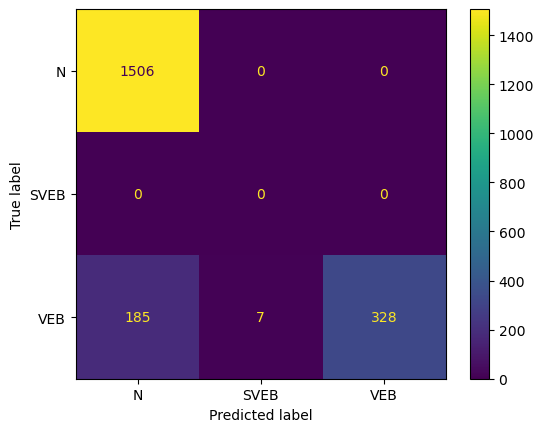

Fold 6:
  Test:  patient=5
              precision    recall  f1-score   support

         0.0       1.00      0.75      0.86      1739
         1.0       0.00      0.00      0.00         4
         2.0       0.02      0.47      0.03        17

    accuracy                           0.75      1760
   macro avg       0.34      0.41      0.30      1760
weighted avg       0.99      0.75      0.85      1760

                   0.0  1.0        2.0  accuracy    macro avg  weighted avg
precision     0.999235  0.0   0.018018  0.746591     0.339084      0.987486
recall        0.751006  0.0   0.470588  0.746591     0.407198      0.746591
f1-score      0.857518  0.0   0.034707  0.746591     0.297408      0.847622
support    1739.000000  4.0  17.000000  0.746591  1760.000000   1760.000000


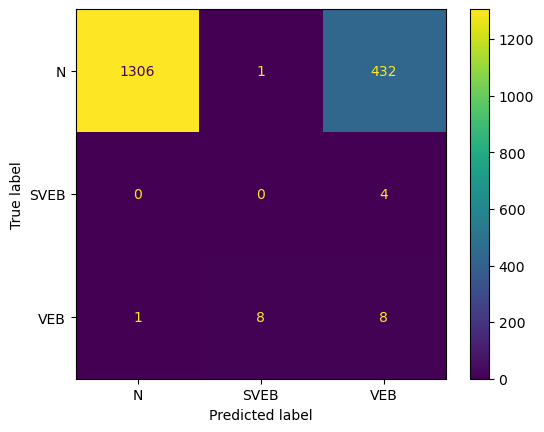

Fold 7:
  Test:  patient=6
              precision    recall  f1-score   support

         0.0       1.00      0.35      0.52      2491
         1.0       0.00      0.00      0.00         0
         2.0       0.02      0.92      0.04        38

    accuracy                           0.36      2529
   macro avg       0.34      0.42      0.19      2529
weighted avg       0.98      0.36      0.51      2529

                   0.0  1.0        2.0  accuracy    macro avg  weighted avg
precision     0.998847  0.0   0.021084  0.356267     0.339977      0.984155
recall        0.347652  NaN   0.921053  0.356267     0.422901      0.356267
f1-score      0.515783  NaN   0.041225  0.356267     0.185669      0.508653
support    2491.000000  0.0  38.000000  0.356267  2529.000000   2529.000000


C:\Users\matte\anaconda3\envs\DMML\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matte\anaconda3\envs\DMML\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matte\anaconda3\envs\DMML\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matte\anaconda3\envs\DMML\lib\site-packa

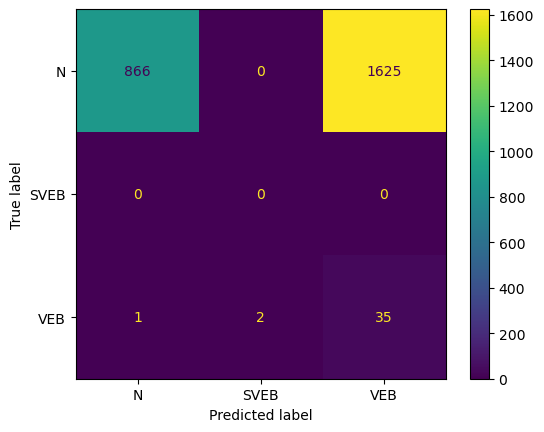

Fold 8:
  Test:  patient=7
              precision    recall  f1-score   support

         0.0       1.00      0.31      0.48      2122
         1.0       0.00      0.00      0.00         0
         2.0       0.00      1.00      0.00         1

    accuracy                           0.32      2123
   macro avg       0.33      0.44      0.16      2123
weighted avg       1.00      0.32      0.48      2123

                   0.0  1.0       2.0  accuracy    macro avg  weighted avg
precision     1.000000  0.0  0.000692   0.31512     0.333564      0.999529
recall        0.314797  NaN  1.000000   0.31512     0.438266      0.315120
f1-score      0.478853  NaN  0.001383   0.31512     0.160079      0.478628
support    2122.000000  0.0  1.000000   0.31512  2123.000000   2123.000000


C:\Users\matte\anaconda3\envs\DMML\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matte\anaconda3\envs\DMML\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matte\anaconda3\envs\DMML\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matte\anaconda3\envs\DMML\lib\site-packa

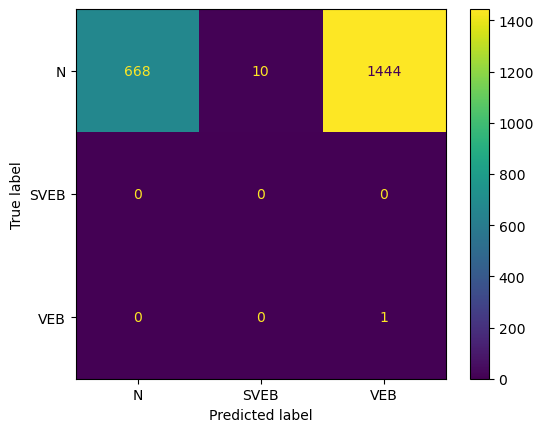

Fold 9:
  Test:  patient=8
              precision    recall  f1-score   support

         0.0       1.00      0.94      0.97      2536
         1.0       0.01      1.00      0.03         2
         2.0       0.00      0.00      0.00         0

    accuracy                           0.94      2538
   macro avg       0.34      0.65      0.33      2538
weighted avg       1.00      0.94      0.97      2538

                   0.0       1.0  2.0  accuracy    macro avg  weighted avg
precision     1.000000  0.013333  0.0  0.941292     0.337778      0.999222
recall        0.941246  1.000000  NaN  0.941292     0.647082      0.941292
f1-score      0.969734  0.026316  NaN  0.941292     0.332017      0.968990
support    2536.000000  2.000000  0.0  0.941292  2538.000000   2538.000000


C:\Users\matte\anaconda3\envs\DMML\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matte\anaconda3\envs\DMML\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matte\anaconda3\envs\DMML\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matte\anaconda3\envs\DMML\lib\site-packa

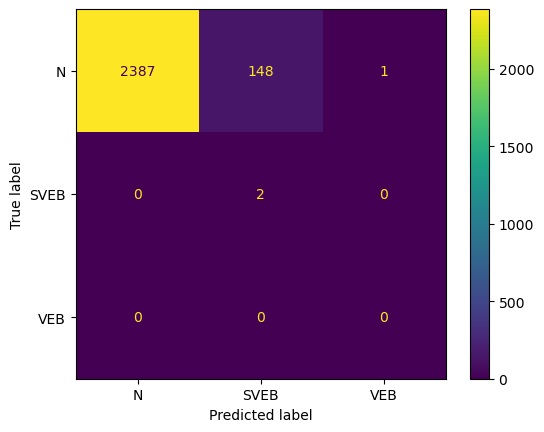

Fold 10:
  Test:  patient=9
              precision    recall  f1-score   support

         0.0       1.00      0.86      0.92      1788
         1.0       0.00      0.17      0.01         6
         2.0       0.00      0.00      0.00         0

    accuracy                           0.86      1794
   macro avg       0.33      0.34      0.31      1794
weighted avg       1.00      0.86      0.92      1794

                   0.0       1.0  2.0  accuracy    macro avg  weighted avg
precision     1.000000  0.003984  0.0   0.85786     0.334661      0.996669
recall        0.860179  0.166667  NaN   0.85786     0.342282      0.857860
f1-score      0.924835  0.007782  NaN   0.85786     0.310872      0.921768
support    1788.000000  6.000000  0.0   0.85786  1794.000000   1794.000000


C:\Users\matte\anaconda3\envs\DMML\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matte\anaconda3\envs\DMML\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matte\anaconda3\envs\DMML\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matte\anaconda3\envs\DMML\lib\site-packa

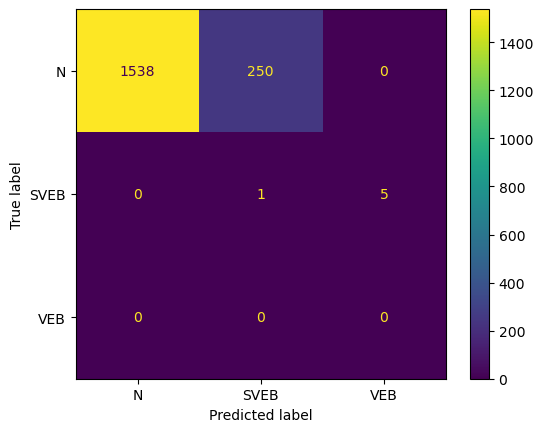

Fold 11:
  Test:  patient=10


C:\Users\matte\anaconda3\envs\DMML\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matte\anaconda3\envs\DMML\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matte\anaconda3\envs\DMML\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matte\anaconda3\

              precision    recall  f1-score   support

         0.0       0.99      0.97      0.98      1819
         1.0       0.00      0.00      0.00        12
         2.0       0.38      0.91      0.53        43

    accuracy                           0.96      1874
   macro avg       0.46      0.62      0.50      1874
weighted avg       0.97      0.96      0.96      1874

                   0.0   1.0        2.0  accuracy    macro avg  weighted avg
precision     0.992655   NaN   0.375000  0.958378     0.455885      0.972127
recall        0.965915   0.0   0.906977  0.958378     0.624297      0.958378
f1-score      0.979103   NaN   0.530612  0.958378     0.503238      0.962542
support    1819.000000  12.0  43.000000  0.958378  1874.000000   1874.000000


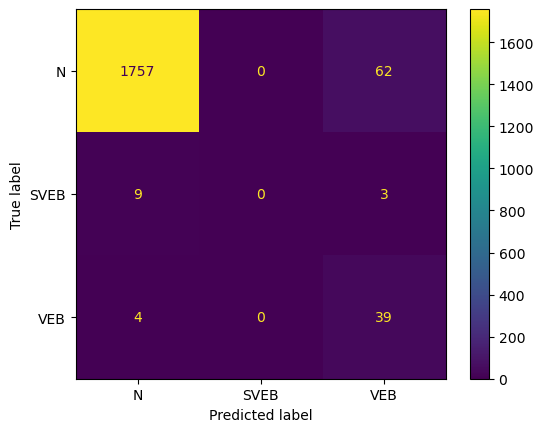

Fold 12:
  Test:  patient=11
              precision    recall  f1-score   support

         0.0       1.00      0.97      0.98      1952
         1.0       0.00      0.00      0.00         0

    accuracy                           0.97      1952
   macro avg       0.50      0.49      0.49      1952
weighted avg       1.00      0.97      0.98      1952

                   0.0  1.0  accuracy    macro avg  weighted avg
precision     1.000000  0.0  0.970287     0.500000      1.000000
recall        0.970287  NaN  0.970287     0.485143      0.970287
f1-score      0.984919  NaN  0.970287     0.492460      0.984919
support    1952.000000  0.0  0.970287  1952.000000   1952.000000


C:\Users\matte\anaconda3\envs\DMML\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matte\anaconda3\envs\DMML\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matte\anaconda3\envs\DMML\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matte\anaconda3\envs\DMML\lib\site-packa

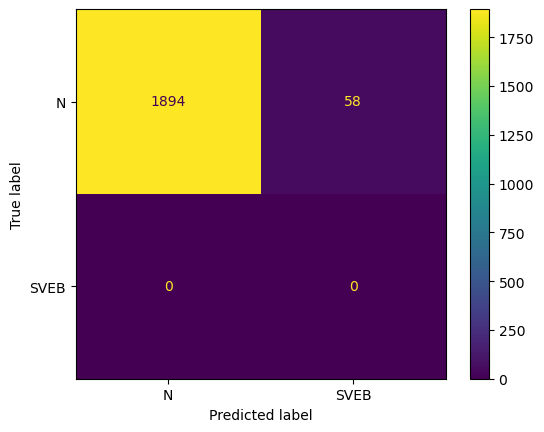

Fold 13:
  Test:  patient=12
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      2301
         1.0       0.04      1.00      0.08         1
         2.0       0.98      0.86      0.92       109

    accuracy                           0.99      2411
   macro avg       0.67      0.95      0.67      2411
weighted avg       1.00      0.99      0.99      2411

                   0.0       1.0         2.0  accuracy    macro avg  \
precision     0.999564  0.043478    0.979167  0.989631     0.674070   
recall        0.995654  1.000000    0.862385  0.989631     0.952680   
f1-score      0.997605  0.083333    0.917073  0.989631     0.666004   
support    2301.000000  1.000000  109.000000  0.989631  2411.000000   

           weighted avg  
precision      0.998245  
recall         0.989631  
f1-score       0.993585  
support     2411.000000  


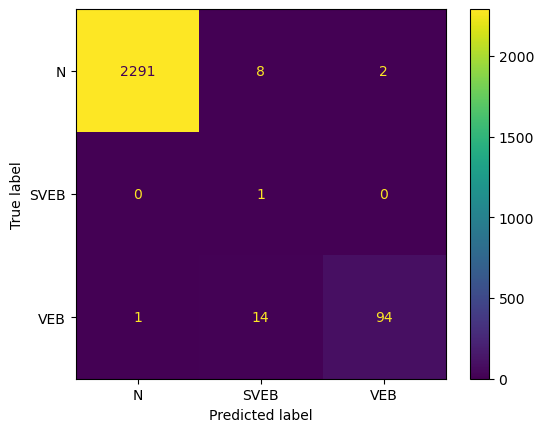

Fold 14:
  Test:  patient=13


C:\Users\matte\anaconda3\envs\DMML\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matte\anaconda3\envs\DMML\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matte\anaconda3\envs\DMML\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matte\anaconda3\envs\DMML\lib\site-packa

              precision    recall  f1-score   support

         0.0       1.00      0.91      0.95      1533
         1.0       0.01      1.00      0.01         1
         2.0       0.00      0.00      0.00         0

    accuracy                           0.91      1534
   macro avg       0.34      0.64      0.32      1534
weighted avg       1.00      0.91      0.95      1534

                   0.0       1.0  2.0  accuracy    macro avg  weighted avg
precision     1.000000  0.007092  0.0  0.907432     0.335697      0.999353
recall        0.907371  1.000000  NaN  0.907432     0.635790      0.907432
f1-score      0.951436  0.014085  NaN  0.907432     0.321840      0.950825
support    1533.000000  1.000000  0.0  0.907432  1534.000000   1534.000000


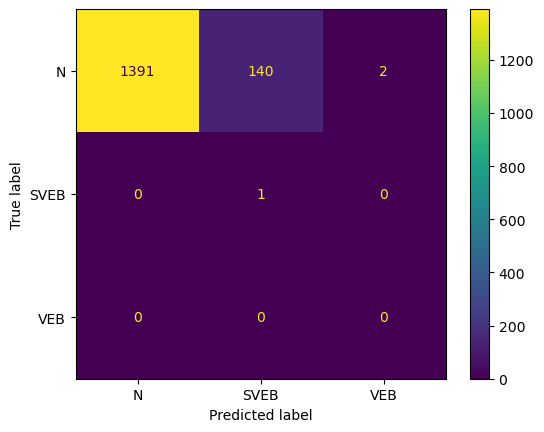

Fold 15:
  Test:  patient=14
              precision    recall  f1-score   support

         0.0       0.99      0.55      0.70      2165
         1.0       0.48      0.27      0.35        96
         2.0       0.01      0.69      0.02        16

    accuracy                           0.54      2277
   macro avg       0.50      0.50      0.36      2277
weighted avg       0.96      0.54      0.68      2277

                   0.0        1.0        2.0  accuracy    macro avg  \
precision     0.993277   0.481481   0.010649  0.535354     0.495136   
recall        0.545958   0.270833   0.687500  0.535354     0.501431   
f1-score      0.704620   0.346667   0.020972  0.535354     0.357420   
support    2165.000000  96.000000  16.000000  0.535354  2277.000000   

           weighted avg  
precision      0.964795  
recall         0.535354  
f1-score       0.684725  
support     2277.000000  


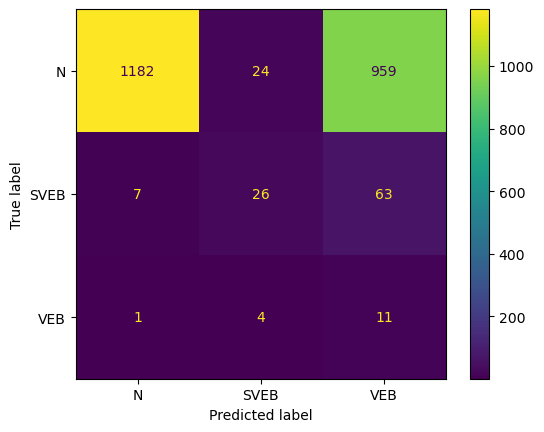

Fold 16:
  Test:  patient=15


C:\Users\matte\anaconda3\envs\DMML\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matte\anaconda3\envs\DMML\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matte\anaconda3\envs\DMML\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matte\anaconda3\envs\DMML\lib\site-packa

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      1542
         1.0       0.00      0.00      0.00         0
         2.0       1.00      1.00      1.00       444

    accuracy                           1.00      1986
   macro avg       0.67      0.66      0.67      1986
weighted avg       1.00      1.00      1.00      1986

                   0.0  1.0         2.0  accuracy    macro avg  weighted avg
precision     0.999350  0.0    1.000000  0.996475     0.666450      0.999495
recall        0.996757  NaN    0.995495  0.996475     0.664084      0.996475
f1-score      0.998052  NaN    0.997743  0.996475     0.665265      0.997983
support    1542.000000  0.0  444.000000  0.996475  1986.000000   1986.000000


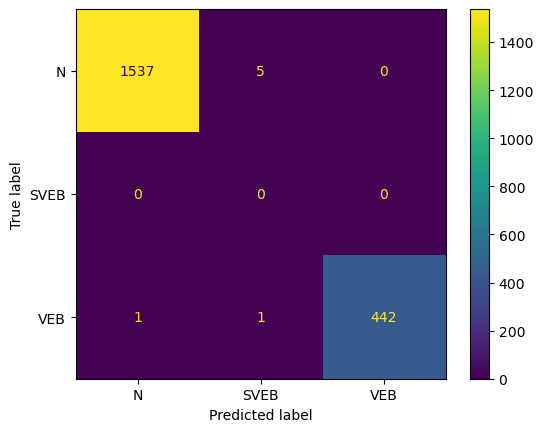

Fold 17:
  Test:  patient=16
              precision    recall  f1-score   support

         0.0       1.00      0.90      0.95      1860
         1.0       0.01      1.00      0.01         1
         2.0       1.00      1.00      1.00         1

    accuracy                           0.90      1862
   macro avg       0.67      0.97      0.65      1862
weighted avg       1.00      0.90      0.95      1862

                   0.0       1.0  2.0  accuracy    macro avg  weighted avg
precision     1.000000  0.005556  1.0  0.903867     0.668519      0.999466
recall        0.903763  1.000000  1.0  0.903867     0.967921      0.903867
f1-score      0.949449  0.011050  1.0  0.903867     0.653500      0.948972
support    1860.000000  1.000000  1.0  0.903867  1862.000000   1862.000000


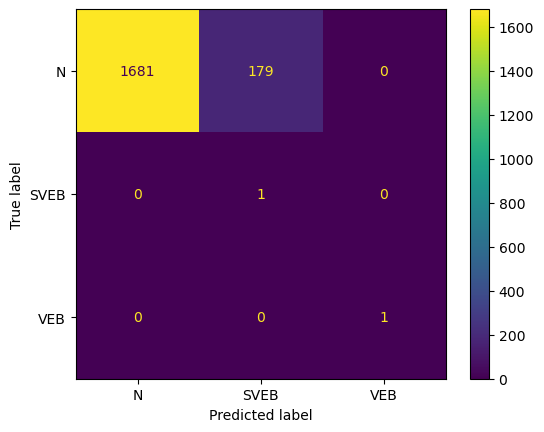

Fold 18:
  Test:  patient=17


C:\Users\matte\anaconda3\envs\DMML\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matte\anaconda3\envs\DMML\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matte\anaconda3\envs\DMML\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matte\anaconda3\envs\DMML\lib\site-packa

              precision    recall  f1-score   support

         0.0       1.00      0.89      0.94      2475
         1.0       0.00      0.00      0.00         0
         2.0       0.00      0.00      0.00         0

    accuracy                           0.89      2475
   macro avg       0.33      0.30      0.31      2475
weighted avg       1.00      0.89      0.94      2475

                   0.0  1.0  2.0  accuracy    macro avg  weighted avg
precision     1.000000  0.0  0.0  0.891717     0.333333      1.000000
recall        0.891717  NaN  NaN  0.891717     0.297239      0.891717
f1-score      0.942760  NaN  NaN  0.891717     0.314253      0.942760
support    2475.000000  0.0  0.0  0.891717  2475.000000   2475.000000


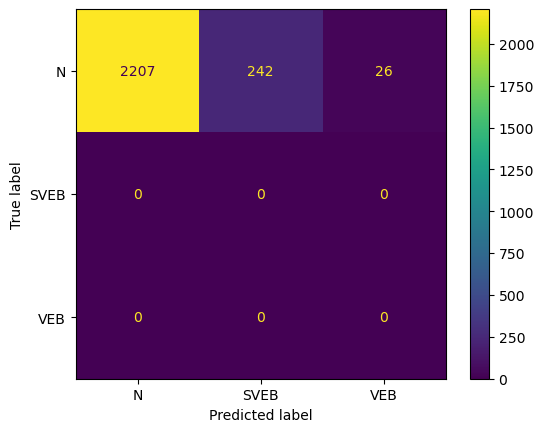

Fold 19:
  Test:  patient=18


C:\Users\matte\anaconda3\envs\DMML\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matte\anaconda3\envs\DMML\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matte\anaconda3\envs\DMML\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matte\anaconda3\envs\DMML\lib\site-packa

              precision    recall  f1-score   support

         0.0       1.00      0.83      0.91      1514
         1.0       0.00      0.00      0.00         0
         2.0       1.00      0.33      0.50         3

    accuracy                           0.83      1517
   macro avg       0.67      0.39      0.47      1517
weighted avg       1.00      0.83      0.91      1517

                   0.0  1.0       2.0  accuracy    macro avg  weighted avg
precision     1.000000  0.0  1.000000  0.831246     0.666667      1.000000
recall        0.832232  NaN  0.333333  0.831246     0.388522      0.831246
f1-score      0.908435  NaN  0.500000  0.831246     0.469478      0.907628
support    1514.000000  0.0  3.000000  0.831246  1517.000000   1517.000000


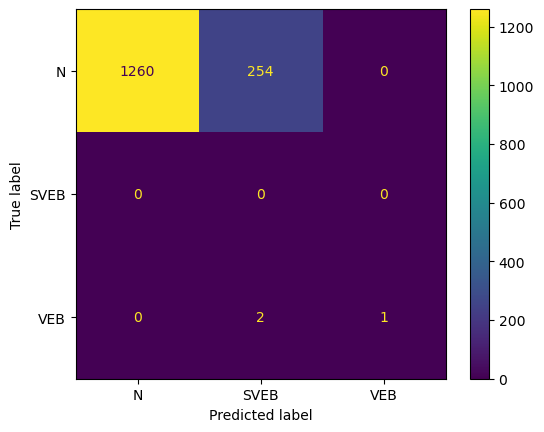

Fold 20:
  Test:  patient=19
              precision    recall  f1-score   support

         0.0       0.98      0.75      0.85      1535
         1.0       0.00      0.00      0.00        31
         2.0       0.06      0.57      0.12        47

    accuracy                           0.73      1613
   macro avg       0.35      0.44      0.32      1613
weighted avg       0.93      0.73      0.81      1613

                   0.0   1.0        2.0  accuracy    macro avg  weighted avg
precision     0.977947   0.0   0.064593  0.731556     0.347514      0.932539
recall        0.751140   0.0   0.574468  0.731556     0.441869      0.731556
f1-score      0.849668   0.0   0.116129  0.731556     0.321932      0.811965
support    1535.000000  31.0  47.000000  0.731556  1613.000000   1613.000000


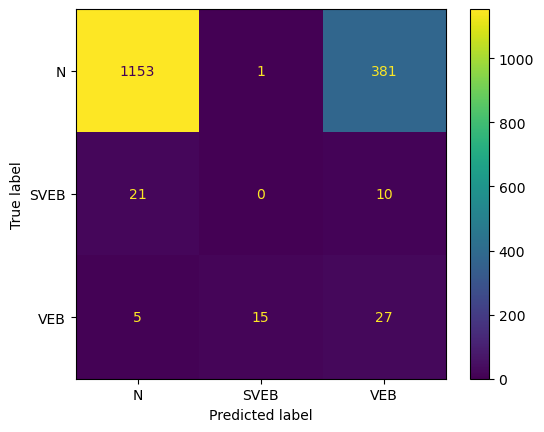

Fold 21:
  Test:  patient=20
              precision    recall  f1-score   support

         0.0       0.99      0.86      0.92      1742
         1.0       0.07      0.63      0.13        30
         2.0       0.97      0.95      0.96       826

    accuracy                           0.89      2598
   macro avg       0.68      0.82      0.67      2598
weighted avg       0.97      0.89      0.93      2598

                   0.0        1.0         2.0  accuracy    macro avg  \
precision     0.986894   0.073077    0.969212  0.889915     0.676394   
recall        0.864524   0.633333    0.952785  0.889915     0.816880   
f1-score      0.921665   0.131034    0.960928  0.889915     0.671209   
support    1742.000000  30.000000  826.000000  0.889915  2598.000000   

           weighted avg  
precision      0.970720  
recall         0.889915  
f1-score       0.925018  
support     2598.000000  


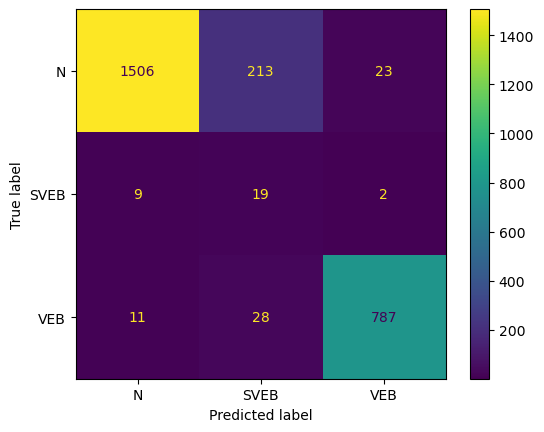

Fold 22:
  Test:  patient=21
              precision    recall  f1-score   support

         0.0       0.92      0.86      0.89      1634
         1.0       0.18      0.41      0.25       128
         2.0       0.53      0.40      0.46       198

    accuracy                           0.78      1960
   macro avg       0.55      0.56      0.53      1960
weighted avg       0.84      0.78      0.80      1960

                   0.0         1.0         2.0  accuracy    macro avg  \
precision     0.923077    0.184028    0.529801  0.784184     0.545635   
recall        0.859241    0.414062    0.404040  0.784184     0.559115   
f1-score      0.890016    0.254808    0.458453  0.784184     0.534425   
support    1634.000000  128.000000  198.000000  0.784184  1960.000000   

           weighted avg  
precision      0.835084  
recall         0.784184  
f1-score       0.804936  
support     1960.000000  


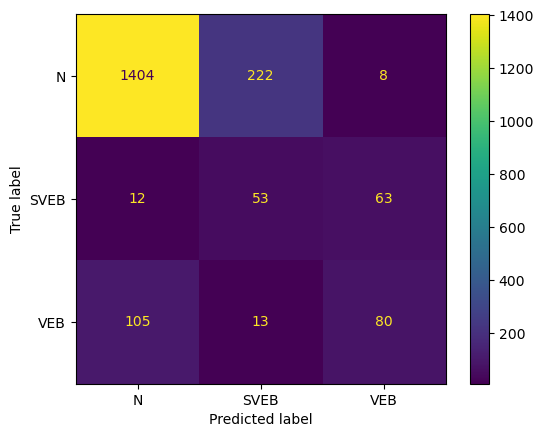

Fold 23:
  Test:  patient=22
              precision    recall  f1-score   support

         0.0       0.99      0.86      0.92      2060
         1.0       0.07      0.40      0.13        55
         2.0       0.33      0.84      0.48        19

    accuracy                           0.85      2134
   macro avg       0.47      0.70      0.51      2134
weighted avg       0.96      0.85      0.90      2134

                   0.0        1.0        2.0  accuracy    macro avg  \
precision     0.993858   0.074576   0.333333  0.851921     0.467256   
recall        0.864078   0.400000   0.842105  0.851921     0.702061   
f1-score      0.924435   0.125714   0.477612  0.851921     0.509254   
support    2060.000000  55.000000  19.000000  0.851921  2134.000000   

           weighted avg  
precision      0.964284  
recall         0.851921  
f1-score       0.899871  
support     2134.000000  


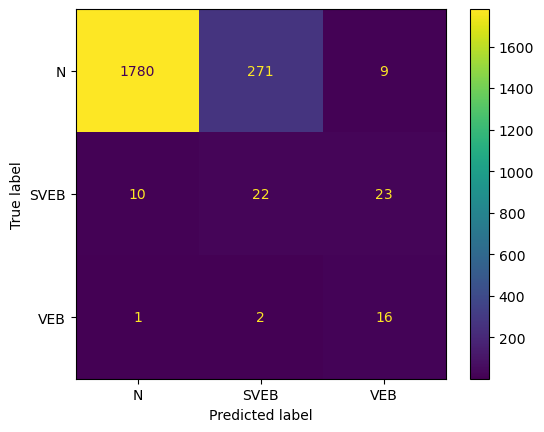

Fold 24:
  Test:  patient=23
              precision    recall  f1-score   support

         0.0       1.00      0.64      0.78      2528
         1.0       0.00      0.50      0.00         2
         2.0       0.44      0.93      0.59       444

    accuracy                           0.68      2974
   macro avg       0.48      0.69      0.46      2974
weighted avg       0.91      0.68      0.75      2974

                   0.0       1.0         2.0  accuracy    macro avg  \
precision     0.999385  0.002463    0.435843    0.6846     0.479230   
recall        0.642405  0.500000    0.925676    0.6846     0.689360   
f1-score      0.782085  0.004902    0.592646    0.6846     0.459878   
support    2528.000000  2.000000  444.000000    0.6846  2974.000000   

           weighted avg  
precision      0.914581  
recall         0.684600  
f1-score       0.753280  
support     2974.000000  


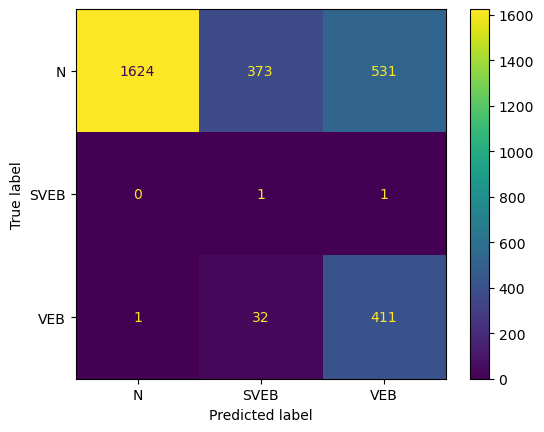

Fold 25:
  Test:  patient=24
              precision    recall  f1-score   support

         0.0       1.00      0.87      0.93      2570
         1.0       0.01      1.00      0.02         3
         2.0       1.00      0.87      0.93        71

    accuracy                           0.87      2644
   macro avg       0.67      0.92      0.63      2644
weighted avg       1.00      0.87      0.93      2644

                   0.0       1.0        2.0  accuracy    macro avg  \
precision     0.997781  0.009119   1.000000  0.874811     0.668966   
recall        0.874708  1.000000   0.873239  0.874811     0.915983   
f1-score      0.932200  0.018072   0.932331  0.874811     0.627534   
support    2570.000000  3.000000  71.000000  0.874811  2644.000000   

           weighted avg  
precision      0.996719  
recall         0.874811  
f1-score       0.931166  
support     2644.000000  


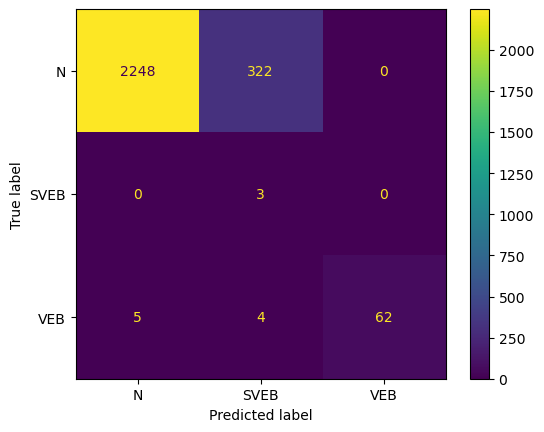

Fold 26:
  Test:  patient=25
              precision    recall  f1-score   support

         0.0       0.60      0.05      0.10      1543
         1.0       0.00      0.00      0.00       106
         2.0       0.09      0.70      0.15       210

    accuracy                           0.12      1859
   macro avg       0.23      0.25      0.08      1859
weighted avg       0.51      0.12      0.10      1859

                   0.0    1.0         2.0  accuracy    macro avg  weighted avg
precision     0.601449    0.0    0.086449   0.12426     0.229299      0.508978
recall        0.053791    0.0    0.704762   0.12426     0.252851      0.124260
f1-score      0.098751    0.0    0.154006   0.12426     0.084252      0.099362
support    1543.000000  106.0  210.000000   0.12426  1859.000000   1859.000000


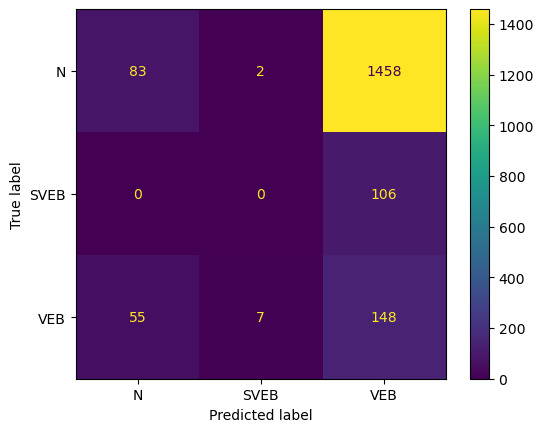

Fold 27:
  Test:  patient=26
              precision    recall  f1-score   support

         0.0       0.84      0.95      0.89      1585
         1.0       0.00      0.00      0.00         2
         2.0       0.99      0.55      0.70       992

    accuracy                           0.79      2579
   macro avg       0.61      0.50      0.53      2579
weighted avg       0.89      0.79      0.82      2579

                   0.0  1.0         2.0  accuracy    macro avg  weighted avg
precision     0.837041  0.0    0.989071  0.794106     0.608704      0.894870
recall        0.949527  0.0    0.547379  0.794106     0.498969      0.794106
f1-score      0.889743  0.0    0.704737  0.794106     0.531493      0.817891
support    1585.000000  2.0  992.000000  0.794106  2579.000000   2579.000000


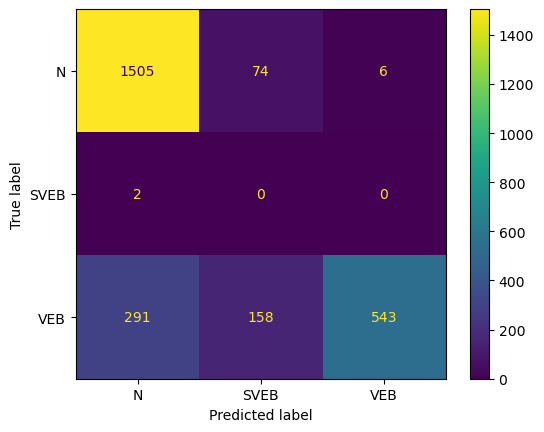

Fold 28:
  Test:  patient=27
              precision    recall  f1-score   support

         0.0       0.99      0.98      0.98      2620
         1.0       0.90      0.74      0.81       383
         2.0       0.01      1.00      0.03         1

    accuracy                           0.95      3004
   macro avg       0.63      0.91      0.61      3004
weighted avg       0.97      0.95      0.96      3004

                   0.0         1.0       2.0  accuracy    macro avg  \
precision     0.985080    0.896226  0.013889  0.952397     0.631732   
recall        0.982824    0.744125  1.000000  0.952397     0.908983   
f1-score      0.983951    0.813124  0.027397  0.952397     0.608157   
support    2620.000000  383.000000  1.000000  0.952397  3004.000000   

           weighted avg  
precision      0.973428  
recall         0.952397  
f1-score       0.961853  
support     3004.000000  


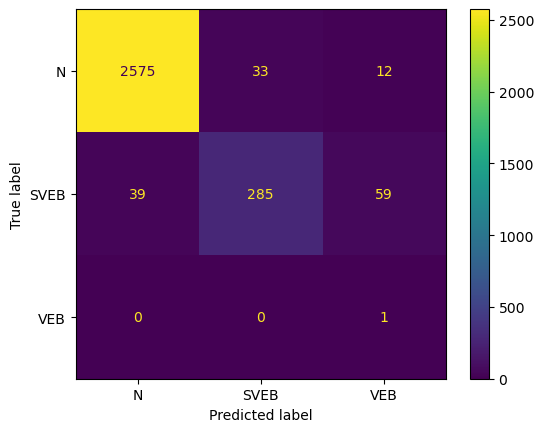

Fold 29:
  Test:  patient=28
              precision    recall  f1-score   support

         0.0       0.99      0.81      0.89      2422
         1.0       0.04      1.00      0.07        22
         2.0       0.69      0.34      0.46       195

    accuracy                           0.77      2639
   macro avg       0.58      0.72      0.47      2639
weighted avg       0.96      0.77      0.85      2639

                   0.0        1.0         2.0  accuracy    macro avg  \
precision     0.992382   0.038261    0.694737  0.773778     0.575127   
recall        0.806771   1.000000    0.338462  0.773778     0.715078   
f1-score      0.890002   0.073702    0.455172  0.773778     0.472959   
support    2422.000000  22.000000  195.000000  0.773778  2639.000000   

           weighted avg  
precision      0.962434  
recall         0.773778  
f1-score       0.851067  
support     2639.000000  


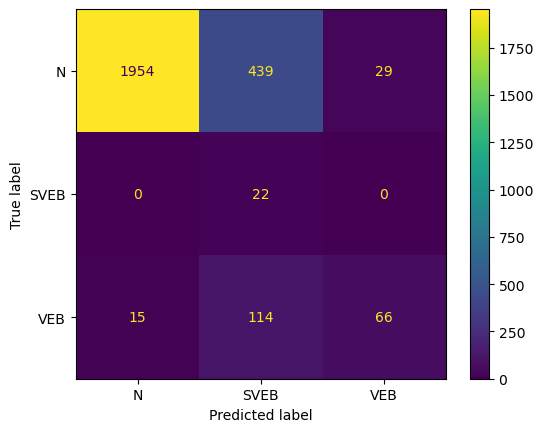

Fold 30:
  Test:  patient=29
              precision    recall  f1-score   support

         0.0       1.00      0.75      0.86      2747
         1.0       0.00      0.00      0.00         0
         2.0       0.00      0.00      0.00         0

    accuracy                           0.75      2747
   macro avg       0.33      0.25      0.29      2747
weighted avg       1.00      0.75      0.86      2747

                   0.0  1.0  2.0  accuracy    macro avg  weighted avg
precision     1.000000  0.0  0.0  0.748453     0.333333      1.000000
recall        0.748453  NaN  NaN  0.748453     0.249484      0.748453
f1-score      0.856132  NaN  NaN  0.748453     0.285377      0.856132
support    2747.000000  0.0  0.0  0.748453  2747.000000   2747.000000


C:\Users\matte\anaconda3\envs\DMML\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matte\anaconda3\envs\DMML\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matte\anaconda3\envs\DMML\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matte\anaconda3\envs\DMML\lib\site-packa

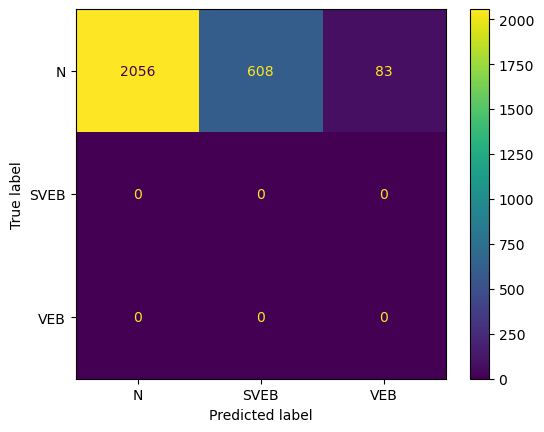

Fold 31:
  Test:  patient=30
              precision    recall  f1-score   support

         0.0       0.99      0.57      0.72      2640
         1.0       0.50      0.11      0.18        28
         2.0       0.15      0.95      0.26       220

    accuracy                           0.60      2888
   macro avg       0.55      0.54      0.39      2888
weighted avg       0.93      0.60      0.68      2888

                   0.0        1.0         2.0  accuracy    macro avg  \
precision     0.994059   0.500000    0.153621  0.595222     0.549227   
recall        0.570455   0.107143    0.954545  0.595222     0.544048   
f1-score      0.724910   0.176471    0.264650  0.595222     0.388677   
support    2640.000000  28.000000  220.000000  0.595222  2888.000000   

           weighted avg  
precision      0.925247  
recall         0.595222  
f1-score       0.684531  
support     2888.000000  


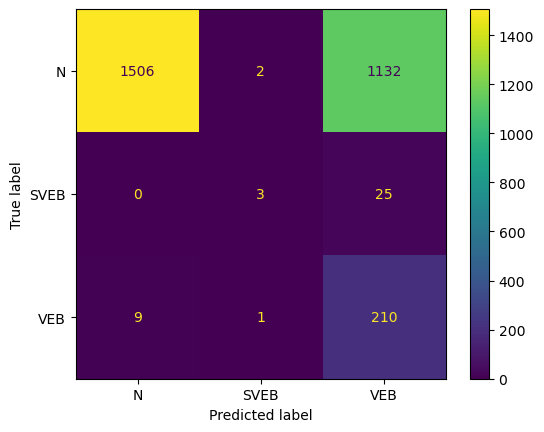

Fold 32:
  Test:  patient=31


C:\Users\matte\anaconda3\envs\DMML\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matte\anaconda3\envs\DMML\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matte\anaconda3\envs\DMML\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matte\anaconda3\envs\DMML\lib\site-packa

              precision    recall  f1-score   support

         0.0       1.00      0.89      0.94      2002
         1.0       0.00      0.00      0.00         0
         2.0       0.52      0.93      0.67       256

    accuracy                           0.89      2258
   macro avg       0.51      0.61      0.54      2258
weighted avg       0.94      0.89      0.91      2258

                   0.0  1.0         2.0  accuracy    macro avg  weighted avg
precision     0.998316  0.0    0.521930  0.893268     0.506749      0.944306
recall        0.888611  NaN    0.929688  0.893268     0.606100      0.893268
f1-score      0.940275  NaN    0.668539  0.893268     0.536271      0.909467
support    2002.000000  0.0  256.000000  0.893268  2258.000000   2258.000000


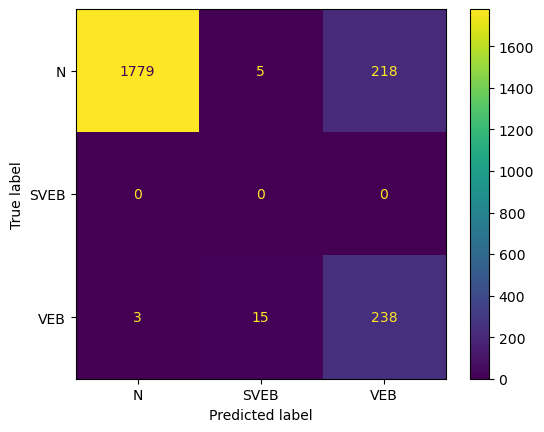

Fold 33:
  Test:  patient=32
              precision    recall  f1-score   support

         0.0       1.00      0.87      0.93      3194
         1.0       0.00      0.67      0.01         3
         2.0       0.98      0.85      0.91       164

    accuracy                           0.87      3361
   macro avg       0.66      0.80      0.62      3361
weighted avg       1.00      0.87      0.93      3361

                   0.0       1.0         2.0  accuracy    macro avg  \
precision     0.997491  0.004662    0.978873  0.869979     0.660342   
recall        0.871321  0.666667    0.847561  0.869979     0.795183   
f1-score      0.930147  0.009259    0.908497  0.869979     0.615968   
support    3194.000000  3.000000  164.000000  0.869979  3361.000000   

           weighted avg  
precision      0.995696  
recall         0.869979  
f1-score       0.928269  
support     3361.000000  


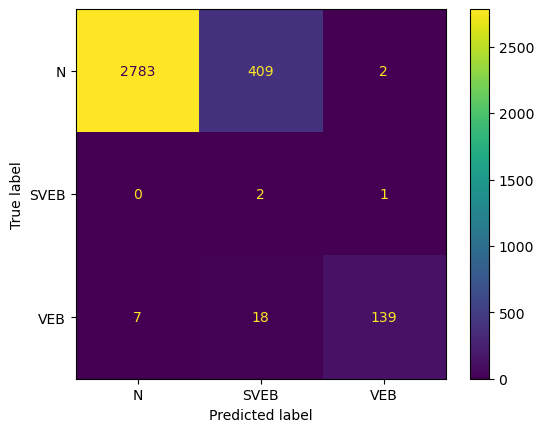

Fold 34:
  Test:  patient=33
              precision    recall  f1-score   support

         0.0       0.99      0.89      0.94      2081
         1.0       0.00      0.00      0.00         7
         2.0       0.20      0.81      0.32        64

    accuracy                           0.88      2152
   macro avg       0.40      0.57      0.42      2152
weighted avg       0.97      0.88      0.92      2152

                   0.0  1.0        2.0  accuracy    macro avg  weighted avg
precision     0.991961  0.0   0.197719  0.884294     0.396560      0.965114
recall        0.889476  0.0   0.812500  0.884294     0.567325      0.884294
f1-score      0.937928  0.0   0.318043  0.884294     0.418657      0.916441
support    2081.000000  7.0  64.000000  0.884294  2152.000000   2152.000000


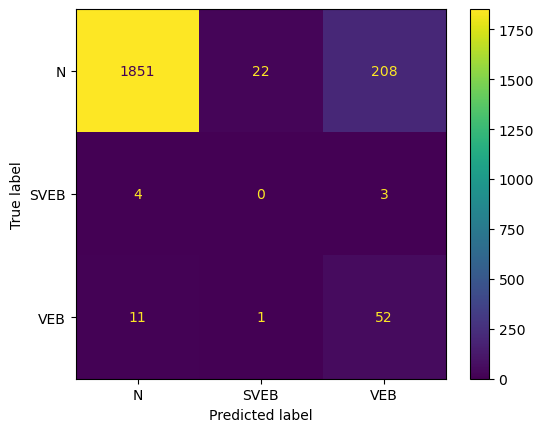

Fold 35:
  Test:  patient=34
              precision    recall  f1-score   support

         0.0       1.00      0.99      0.99      1953
         1.0       0.83      0.98      0.90        94

    accuracy                           0.99      2047
   macro avg       0.91      0.98      0.95      2047
weighted avg       0.99      0.99      0.99      2047

                   0.0        1.0  accuracy    macro avg  weighted avg
precision     0.998967   0.828829  0.989741     0.913898      0.991154
recall        0.990271   0.978723  0.989741     0.984497      0.989741
f1-score      0.994600   0.897561  0.989741     0.946081      0.990144
support    1953.000000  94.000000  0.989741  2047.000000   2047.000000


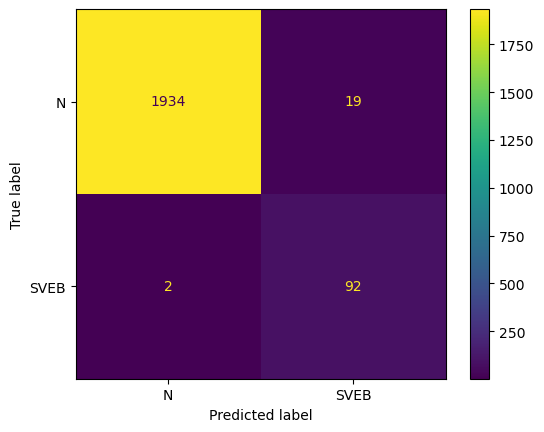

Fold 36:
  Test:  patient=35


C:\Users\matte\anaconda3\envs\DMML\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matte\anaconda3\envs\DMML\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matte\anaconda3\envs\DMML\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matte\anaconda3\envs\DMML\lib\site-packa

              precision    recall  f1-score   support

         0.0       1.00      0.85      0.92      2030
         1.0       0.00      0.00      0.00         0
         2.0       1.00      0.98      0.99       396

    accuracy                           0.87      2426
   macro avg       0.67      0.61      0.64      2426
weighted avg       1.00      0.87      0.93      2426

                   0.0  1.0         2.0  accuracy    macro avg  weighted avg
precision     0.998842  0.0    0.997436  0.871393     0.665426      0.998612
recall        0.849754  NaN    0.982323  0.871393     0.610692      0.871393
f1-score      0.918286  NaN    0.989822  0.871393     0.636036      0.929963
support    2030.000000  0.0  396.000000  0.871393  2426.000000   2426.000000


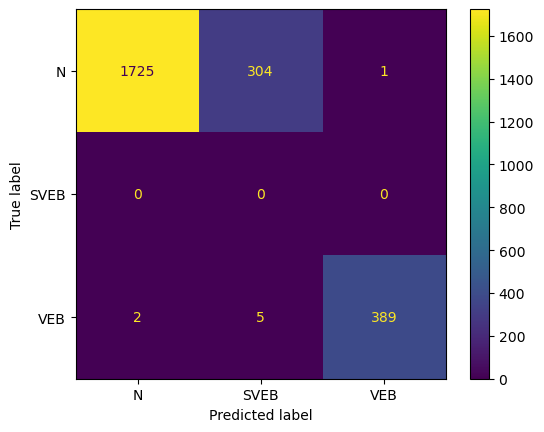

Fold 37:
  Test:  patient=36


C:\Users\matte\anaconda3\envs\DMML\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matte\anaconda3\envs\DMML\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matte\anaconda3\envs\DMML\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matte\anaconda3\envs\DMML\lib\site-packa

              precision    recall  f1-score   support

         0.0       0.99      0.66      0.80      2273
         1.0       0.21      0.95      0.35       209
         2.0       0.00      0.00      0.00         0

    accuracy                           0.69      2482
   macro avg       0.40      0.54      0.38      2482
weighted avg       0.93      0.69      0.76      2482

                   0.0         1.0  2.0  accuracy    macro avg  weighted avg
precision     0.994712    0.213132  0.0   0.68614     0.402615      0.928899
recall        0.662121    0.947368  NaN   0.68614     0.536496      0.686140
f1-score      0.795034    0.347979  NaN   0.68614     0.381004      0.757389
support    2273.000000  209.000000  0.0   0.68614  2482.000000   2482.000000


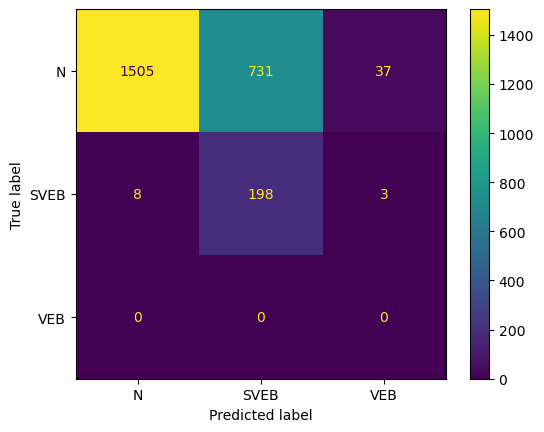

Fold 38:
  Test:  patient=37
              precision    recall  f1-score   support

         0.0       0.96      0.98      0.97      2044
         1.0       0.15      0.33      0.21        73
         2.0       0.87      0.61      0.72       473

    accuracy                           0.90      2590
   macro avg       0.66      0.64      0.63      2590
weighted avg       0.92      0.90      0.90      2590

                   0.0        1.0         2.0  accuracy    macro avg  \
precision     0.960401   0.149068    0.870871  0.898456     0.660113   
recall        0.984834   0.328767    0.613108  0.898456     0.642236   
f1-score      0.972464   0.205128    0.719603  0.898456     0.632398   
support    2044.000000  73.000000  473.000000  0.898456  2590.000000   

           weighted avg  
precision      0.921183  
recall         0.898456  
f1-score       0.904657  
support     2590.000000  


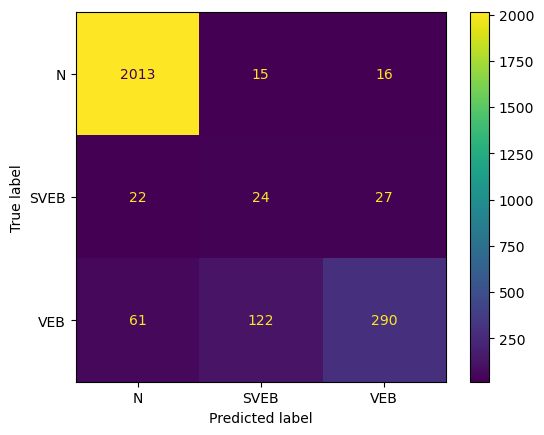

Fold 39:
  Test:  patient=38
              precision    recall  f1-score   support

         0.0       0.99      0.94      0.97      1687
         1.0       0.02      0.67      0.03         3
         2.0       0.99      0.90      0.94       362

    accuracy                           0.94      2052
   macro avg       0.67      0.84      0.65      2052
weighted avg       0.99      0.94      0.96      2052

                   0.0       1.0         2.0  accuracy    macro avg  \
precision     0.988206  0.017699    0.993902  0.935673     0.666603   
recall        0.943687  0.666667    0.900552  0.935673     0.836969   
f1-score      0.965434  0.034483    0.944928  0.935673     0.648281   
support    1687.000000  3.000000  362.000000  0.935673  2052.000000   

           weighted avg  
precision      0.987792  
recall         0.935673  
f1-score       0.960455  
support     2052.000000  


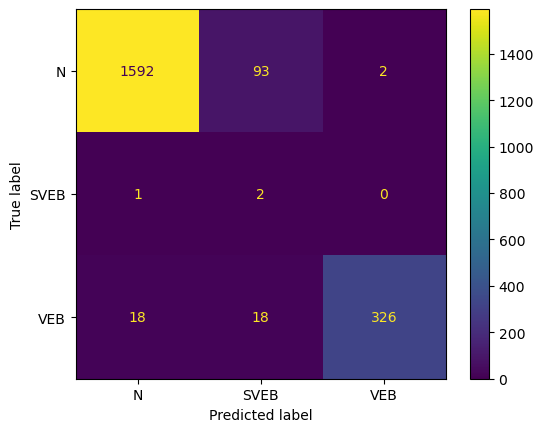

Fold 40:
  Test:  patient=39


C:\Users\matte\anaconda3\envs\DMML\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matte\anaconda3\envs\DMML\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matte\anaconda3\envs\DMML\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matte\anaconda3\envs\DMML\lib\site-packa

              precision    recall  f1-score   support

         0.0       1.00      0.83      0.91      2254
         1.0       0.00      0.00      0.00         0
         2.0       0.01      1.00      0.02         1

    accuracy                           0.83      2255
   macro avg       0.34      0.61      0.31      2255
weighted avg       1.00      0.83      0.91      2255

                   0.0  1.0       2.0  accuracy    macro avg  weighted avg
precision     1.000000  0.0  0.007752  0.832373     0.335917      0.999560
recall        0.832298  NaN  1.000000  0.832373     0.610766      0.832373
f1-score      0.908475  NaN  0.015385  0.832373     0.307953      0.908079
support    2254.000000  0.0  1.000000  0.832373  2255.000000   2255.000000


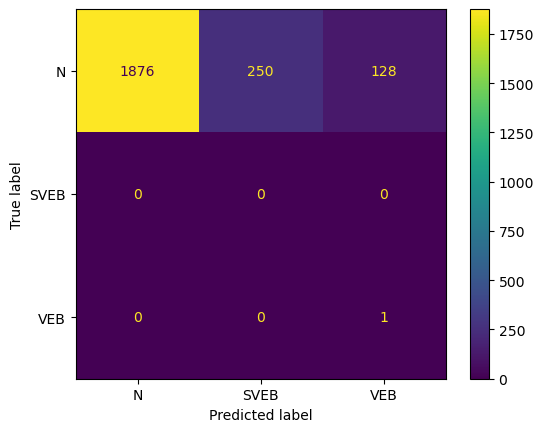

Fold 41:
  Test:  patient=40
              precision    recall  f1-score   support

         0.0       1.00      0.73      0.84      1567
         1.0       0.00      1.00      0.00         1
         2.0       1.00      0.50      0.67         2

    accuracy                           0.73      1570
   macro avg       0.67      0.74      0.50      1570
weighted avg       1.00      0.73      0.84      1570

                   0.0       1.0       2.0  accuracy    macro avg  \
precision     1.000000  0.002326  1.000000  0.726752     0.667442   
recall        0.726867  1.000000  0.500000  0.726752     0.742289   
f1-score      0.841833  0.004640  0.666667  0.726752     0.504380   
support    1567.000000  1.000000  2.000000  0.726752  1570.000000   

           weighted avg  
precision      0.999365  
recall         0.726752  
f1-score       0.841077  
support     1570.000000  


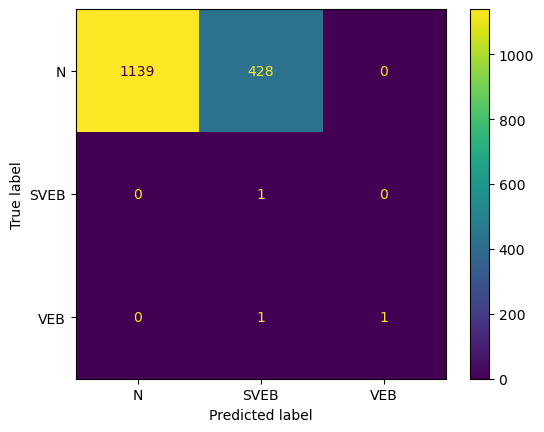

Fold 42:
  Test:  patient=41
              precision    recall  f1-score   support

         0.0       0.24      0.99      0.38       398
         1.0       0.97      0.08      0.15      1381
         2.0       0.00      0.00      0.00         0

    accuracy                           0.28      1779
   macro avg       0.40      0.36      0.18      1779
weighted avg       0.80      0.28      0.20      1779

                  0.0          1.0  2.0  accuracy    macro avg  weighted avg
precision    0.237606     0.965517  0.0  0.283867     0.401041      0.802668
recall       0.987437     0.081101  NaN  0.283867     0.356179      0.283867
f1-score     0.383041     0.149633  NaN  0.283867     0.177558      0.201851
support    398.000000  1381.000000  0.0  0.283867  1779.000000   1779.000000


C:\Users\matte\anaconda3\envs\DMML\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matte\anaconda3\envs\DMML\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matte\anaconda3\envs\DMML\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matte\anaconda3\envs\DMML\lib\site-packa

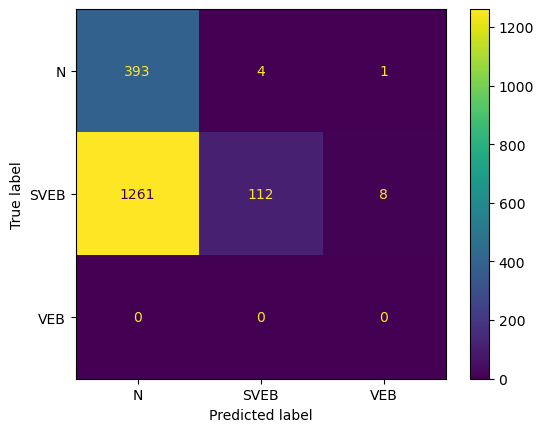

Fold 43:
  Test:  patient=42
              precision    recall  f1-score   support

         0.0       0.98      0.98      0.98      2229
         1.0       0.01      1.00      0.02         7
         2.0       1.00      0.06      0.12       831

    accuracy                           0.73      3067
   macro avg       0.66      0.68      0.37      3067
weighted avg       0.98      0.73      0.74      3067

                   0.0       1.0         2.0  accuracy    macro avg  \
precision     0.978533  0.008974    1.000000  0.732312     0.662502   
recall        0.981606  1.000000    0.061372  0.732312     0.680993   
f1-score      0.980067  0.017789    0.115646  0.732312     0.371168   
support    2229.000000  7.000000  831.000000  0.732312  3067.000000   

           weighted avg  
precision      0.982137  
recall         0.732312  
f1-score       0.743657  
support     3067.000000  


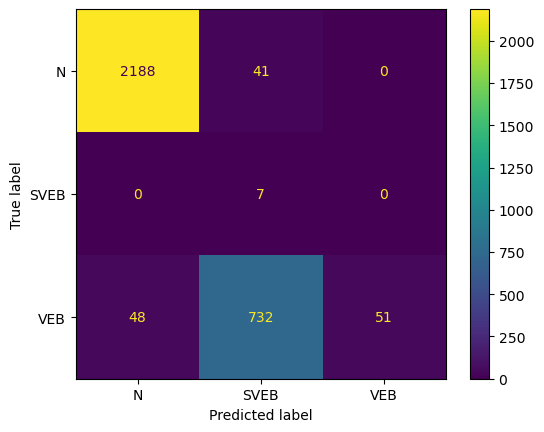

Fold 44:
  Test:  patient=43
              precision    recall  f1-score   support

         0.0       1.00      0.84      0.91      2699
         1.0       0.09      0.90      0.17        50
         2.0       1.00      0.33      0.50         3

    accuracy                           0.84      2752
   macro avg       0.70      0.69      0.53      2752
weighted avg       0.98      0.84      0.90      2752

                   0.0        1.0       2.0  accuracy    macro avg  \
precision     0.997791   0.092213  1.000000  0.837209     0.696668   
recall        0.836606   0.900000  0.333333  0.837209     0.689980   
f1-score      0.910117   0.167286  0.500000  0.837209     0.525801   
support    2699.000000  50.000000  3.000000  0.837209  2752.000000   

           weighted avg  
precision      0.981340  
recall         0.837209  
f1-score       0.896174  
support     2752.000000  


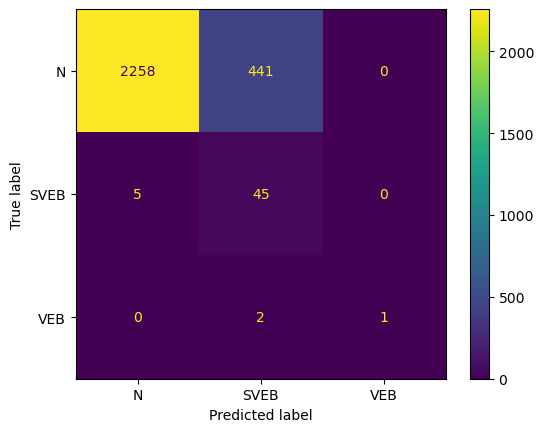

C:\Users\matte\anaconda3\envs\DMML\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\matte\anaconda3\envs\DMML\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [30]:
X=df_cardio.drop('type',axis=1)
y=df_cardio['type']
groups=df_cardio['patient']
skf = LeaveOneGroupOut()


start_time=time.time()
df_features30, acc_features30,confusion_matrix_final_30features,list_select_30 = cross_valid(pipe_select_30, skf, X, y,groups)
end_time=time.time()

In [31]:
df_features30

0.0        1.0         2.0    macro avg  weighted avg
f1-score      0.870194   0.152633    0.498226     0.461365      0.846137
precision     0.961472   0.124344    0.444202     0.513045      0.958565
recall        0.830976   0.522330    0.744380     0.600846      0.801597
support    2047.340909  63.159091  166.880952  2269.795455   2269.795455

In [32]:
print("Time"+str(end_time-start_time))

Time4292.759514331818


In [33]:
confusion_matrix_final_30features

array([[74442.,  6712.,  8929.],
       [ 1413.,   953.,   413.],
       [  842.,  1340.,  4827.]])

In [34]:
list_select_30

{'patient0': {'0.0': 0.9968623935454952,
  '1.0': 0.8108108108108109,
  '2.0': 0.25,
  'macro avg': 0.6858910681187687,
  'weighted avg': 0.9938313351723481},
 'patient1': {'0.0': 0.9844389844389845,
  '1.0': 0.0,
  'macro avg': 0.32814632814632816,
  'weighted avg': 0.9828528851085242},
 'patient2': {'0.0': 0.9954139512430605,
  '1.0': 0.0,
  'macro avg': 0.33180465041435353,
  'weighted avg': 0.9944582009298172},
 'patient3': {'0.0': 0.9853325296363271,
  '2.0': 0.3829787234042553,
  'macro avg': 0.4561037510135275,
  'weighted avg': 0.9757080144159395},
 'patient4': {'0.0': 0.9421332499218017,
  '2.0': 0.7735849056603773,
  'macro avg': 0.5719060518607263,
  'weighted avg': 0.8988730628458191},
 'patient5': {'0.0': 0.8575180564674983,
  '1.0': 0.0,
  '2.0': 0.03470715835140998,
  'macro avg': 0.2974084049396361,
  'weighted avg': 0.8476215465278146},
 'patient6': {'0.0': 0.5157832042882667,
  '2.0': 0.041224970553592456,
  'macro avg': 0.18566939161395304,
  'weighted avg': 0.508652

In [35]:
from sklearn.feature_selection import SelectKBest, mutual_info_classif
pipe_select_19 = Pipeline([
        ('f_classif', SelectKBest(mutual_info_classif, k=19)),
        ('sampling', SMOTE(random_state = 123)),
        ('classification', AdaBoostClassifier())
    ])
pipe_select_19

Pipeline(steps=[('f_classif',
                 SelectKBest(k=19,
                             score_func=<function mutual_info_classif at 0x000001E34C3003A0>)),
                ('sampling', SMOTE(random_state=123)),
                ('classification', AdaBoostClassifier())])

Fold 1:
  Test:  patient=0
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      2238
         1.0       0.91      0.30      0.45        33
         2.0       0.04      1.00      0.07         1

    accuracy                           0.99      2272
   macro avg       0.65      0.77      0.51      2272
weighted avg       1.00      0.99      0.99      2272

                   0.0        1.0       2.0  accuracy    macro avg  \
precision     1.000000   0.909091  0.035714  0.987676     0.648268   
recall        0.997766   0.303030  1.000000  0.987676     0.766932   
f1-score      0.998882   0.454545  0.068966  0.987676     0.507464   
support    2238.000000  33.000000  1.000000  0.987676  2272.000000   

           weighted avg  
precision      0.998255  
recall         0.987676  
f1-score       0.990566  
support     2272.000000  


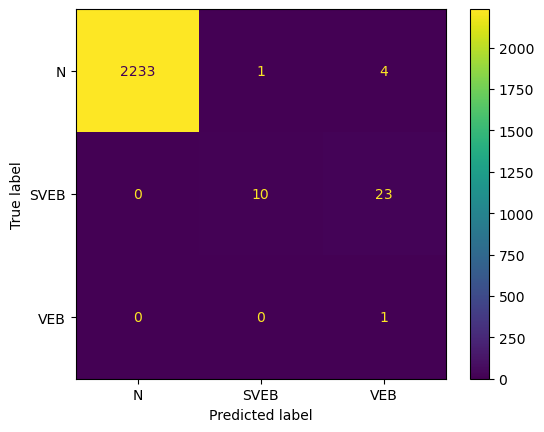

Fold 2:
  Test:  patient=1
              precision    recall  f1-score   support

         0.0       1.00      0.96      0.98      1859
         1.0       0.03      0.67      0.05         3

    accuracy                           0.96      1862
   macro avg       0.51      0.81      0.52      1862
weighted avg       1.00      0.96      0.98      1862

                   0.0       1.0  accuracy    macro avg  weighted avg
precision     0.999441  0.027027  0.960795     0.513234      0.997874
recall        0.961269  0.666667  0.960795     0.813968      0.960795
f1-score      0.979984  0.051948  0.960795     0.515966      0.978488
support    1859.000000  3.000000  0.960795  1862.000000   1862.000000


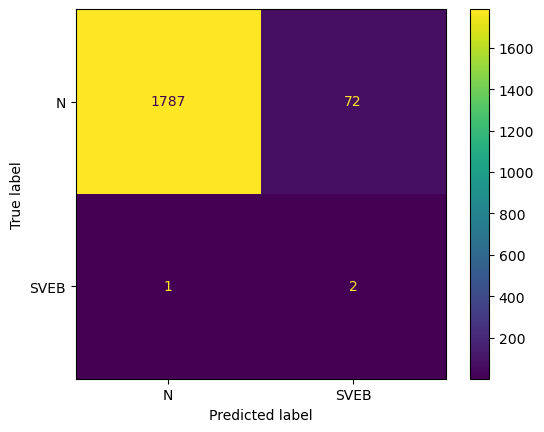

Fold 3:
  Test:  patient=2
              precision    recall  f1-score   support

         0.0       1.00      0.99      1.00      2081
         1.0       0.10      1.00      0.18         2
         2.0       0.00      0.00      0.00         0

    accuracy                           0.99      2083
   macro avg       0.37      0.66      0.39      2083
weighted avg       1.00      0.99      0.99      2083

                   0.0       1.0  2.0  accuracy    macro avg  weighted avg
precision     1.000000  0.100000  0.0  0.990879     0.366667      0.999136
recall        0.990870  1.000000  NaN  0.990879     0.663623      0.990879
f1-score      0.995414  0.181818  NaN  0.990879     0.392411      0.994633
support    2081.000000  2.000000  0.0  0.990879  2083.000000   2083.000000


C:\Users\matte\anaconda3\envs\DMML\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matte\anaconda3\envs\DMML\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matte\anaconda3\envs\DMML\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matte\anaconda3\envs\DMML\lib\site-packa

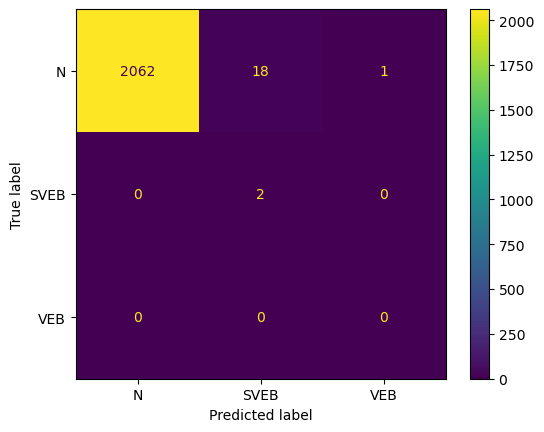

Fold 4:
  Test:  patient=3


C:\Users\matte\anaconda3\envs\DMML\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matte\anaconda3\envs\DMML\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matte\anaconda3\envs\DMML\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matte\anaconda3\envs\DMML\lib\site-packa

              precision    recall  f1-score   support

         0.0       1.00      0.98      0.99      2525
         1.0       0.00      0.00      0.00         0
         2.0       0.00      0.00      0.00        41

    accuracy                           0.97      2566
   macro avg       0.33      0.33      0.33      2566
weighted avg       0.98      0.97      0.98      2566

                   0.0  1.0   2.0  accuracy    macro avg  weighted avg
precision     0.998795  0.0   0.0  0.969213     0.332932      0.982836
recall        0.984950  NaN   0.0  0.969213     0.328317      0.969213
f1-score      0.991825  NaN   0.0  0.969213     0.330608      0.975977
support    2525.000000  0.0  41.0  0.969213  2566.000000   2566.000000


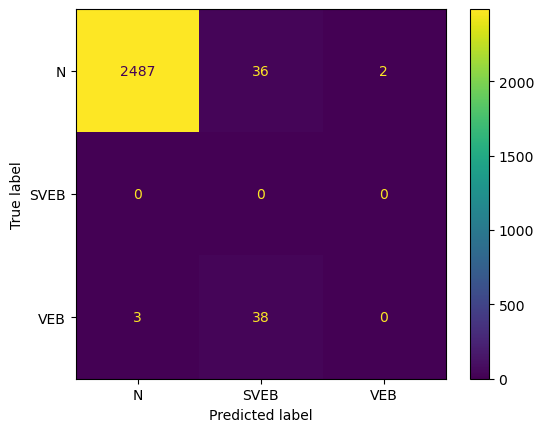

Fold 5:
  Test:  patient=4
              precision    recall  f1-score   support

         0.0       0.94      1.00      0.97      1506
         1.0       0.00      0.00      0.00         0
         2.0       1.00      0.81      0.89       520

    accuracy                           0.95      2026
   macro avg       0.65      0.60      0.62      2026
weighted avg       0.96      0.95      0.95      2026

                   0.0  1.0         2.0  accuracy    macro avg  weighted avg
precision     0.941839  0.0    1.000000  0.950642     0.647280      0.956767
recall        1.000000  NaN    0.807692  0.950642     0.602564      0.950642
f1-score      0.970048  NaN    0.893617  0.950642     0.621222      0.950431
support    1506.000000  0.0  520.000000  0.950642  2026.000000   2026.000000


C:\Users\matte\anaconda3\envs\DMML\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matte\anaconda3\envs\DMML\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matte\anaconda3\envs\DMML\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matte\anaconda3\envs\DMML\lib\site-packa

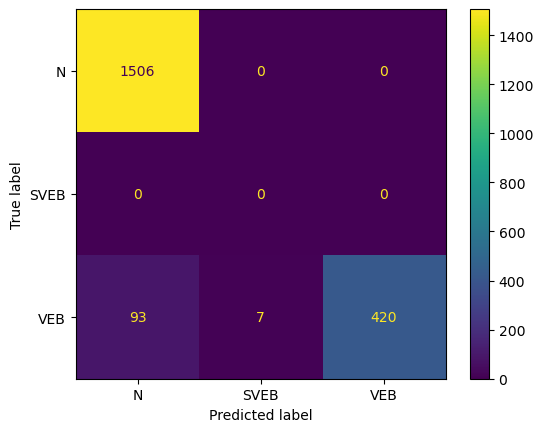

Fold 6:
  Test:  patient=5
              precision    recall  f1-score   support

         0.0       1.00      0.74      0.85      1739
         1.0       0.33      0.25      0.29         4
         2.0       0.02      0.65      0.05        17

    accuracy                           0.74      1760
   macro avg       0.45      0.54      0.39      1760
weighted avg       0.99      0.74      0.84      1760

                   0.0       1.0        2.0  accuracy    macro avg  \
precision     0.996892  0.333333   0.023404  0.735795     0.451210   
recall        0.737780  0.250000   0.647059  0.735795     0.544946   
f1-score      0.847984  0.285714   0.045175  0.735795     0.392958   
support    1739.000000  4.000000  17.000000  0.735795  1760.000000   

           weighted avg  
precision      0.985981  
recall         0.735795  
f1-score       0.838952  
support     1760.000000  


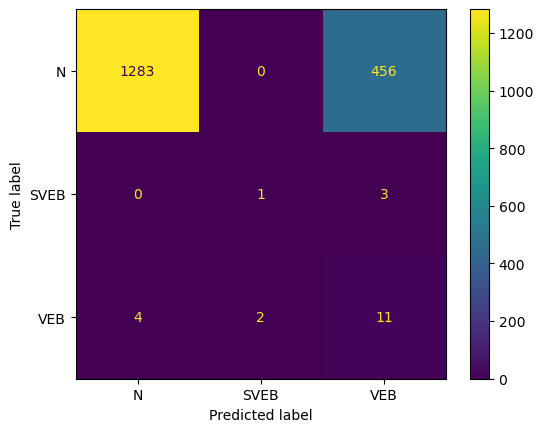

Fold 7:
  Test:  patient=6
              precision    recall  f1-score   support

         0.0       1.00      0.80      0.89      2491
         1.0       0.00      0.00      0.00         0
         2.0       0.06      0.79      0.11        38

    accuracy                           0.80      2529
   macro avg       0.35      0.53      0.33      2529
weighted avg       0.99      0.80      0.88      2529

                   0.0  1.0        2.0  accuracy    macro avg  weighted avg
precision     0.999500  0.0   0.057582  0.802293     0.352361      0.985347
recall        0.802489  NaN   0.789474  0.802293     0.530654      0.802293
f1-score      0.890225  NaN   0.107335  0.802293     0.332520      0.878461
support    2491.000000  0.0  38.000000  0.802293  2529.000000   2529.000000


C:\Users\matte\anaconda3\envs\DMML\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matte\anaconda3\envs\DMML\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matte\anaconda3\envs\DMML\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matte\anaconda3\envs\DMML\lib\site-packa

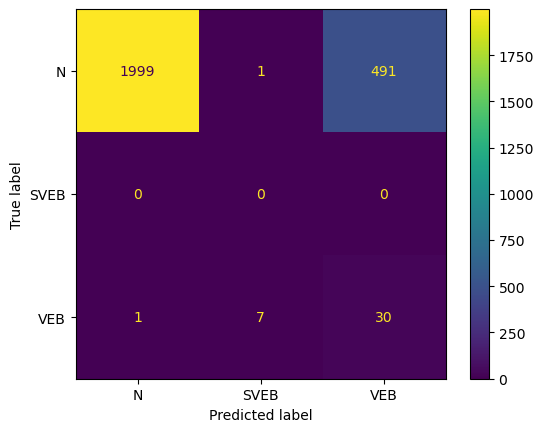

Fold 8:
  Test:  patient=7


C:\Users\matte\anaconda3\envs\DMML\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matte\anaconda3\envs\DMML\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matte\anaconda3\envs\DMML\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matte\anaconda3\envs\DMML\lib\site-packa

              precision    recall  f1-score   support

         0.0       1.00      0.53      0.70      2122
         1.0       0.00      0.00      0.00         0
         2.0       0.00      1.00      0.00         1

    accuracy                           0.53      2123
   macro avg       0.33      0.51      0.23      2123
weighted avg       1.00      0.53      0.70      2123

                   0.0  1.0       2.0  accuracy    macro avg  weighted avg
precision     1.000000  0.0  0.001042  0.533679     0.333681      0.999529
recall        0.533459  NaN  1.000000  0.533679     0.511153      0.533679
f1-score      0.695759  NaN  0.002081  0.533679     0.232613      0.695432
support    2122.000000  0.0  1.000000  0.533679  2123.000000   2123.000000


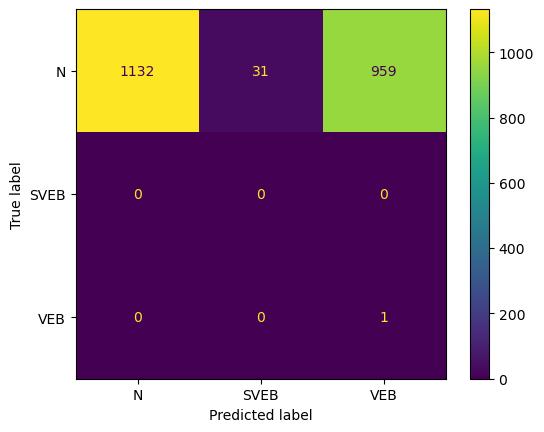

Fold 9:
  Test:  patient=8
              precision    recall  f1-score   support

         0.0       1.00      0.96      0.98      2536
         1.0       0.02      1.00      0.04         2

    accuracy                           0.96      2538
   macro avg       0.51      0.98      0.51      2538
weighted avg       1.00      0.96      0.98      2538

                   0.0       1.0  accuracy    macro avg  weighted avg
precision     1.000000  0.018018  0.957053     0.509009      0.999226
recall        0.957019  1.000000  0.957053     0.978509      0.957053
f1-score      0.978037  0.035398  0.957053     0.506718      0.977295
support    2536.000000  2.000000  0.957053  2538.000000   2538.000000


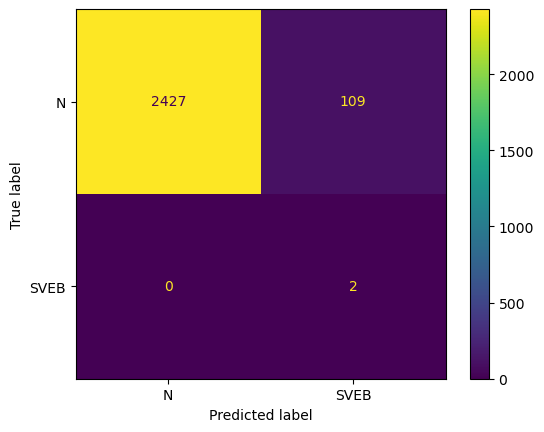

Fold 10:
  Test:  patient=9
              precision    recall  f1-score   support

         0.0       1.00      0.83      0.91      1788
         1.0       0.01      0.33      0.01         6
         2.0       0.00      0.00      0.00         0

    accuracy                           0.83      1794
   macro avg       0.34      0.39      0.31      1794
weighted avg       1.00      0.83      0.90      1794

                   0.0       1.0  2.0  accuracy    macro avg  weighted avg
precision     1.000000  0.006536  0.0  0.828317     0.335512      0.996677
recall        0.829978  0.333333  NaN  0.828317     0.387770      0.828317
f1-score      0.907090  0.012821  NaN  0.828317     0.306637      0.904100
support    1788.000000  6.000000  0.0  0.828317  1794.000000   1794.000000


C:\Users\matte\anaconda3\envs\DMML\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matte\anaconda3\envs\DMML\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matte\anaconda3\envs\DMML\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matte\anaconda3\envs\DMML\lib\site-packa

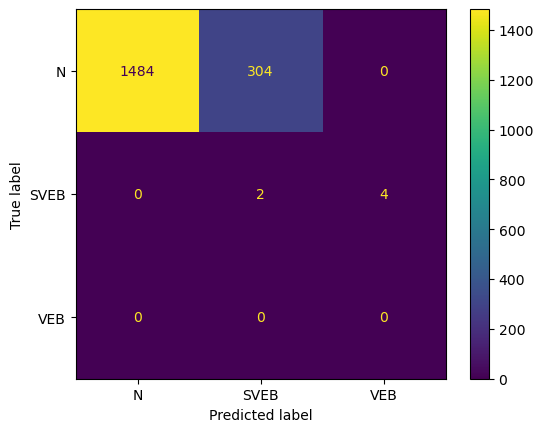

Fold 11:
  Test:  patient=10
              precision    recall  f1-score   support

         0.0       0.99      0.94      0.97      1819
         1.0       0.33      0.17      0.22        12
         2.0       0.26      0.91      0.41        43

    accuracy                           0.93      1874
   macro avg       0.53      0.67      0.53      1874
weighted avg       0.97      0.93      0.95      1874

                   0.0        1.0        2.0  accuracy    macro avg  \
precision     0.994186   0.333333   0.263514  0.934365     0.530344   
recall        0.940077   0.166667   0.906977  0.934365     0.671240   
f1-score      0.966375   0.222222   0.408377  0.934365     0.532325   
support    1819.000000  12.000000  43.000000  0.934365  1874.000000   

           weighted avg  
precision      0.973189  
recall         0.934365  
f1-score       0.948806  
support     1874.000000  


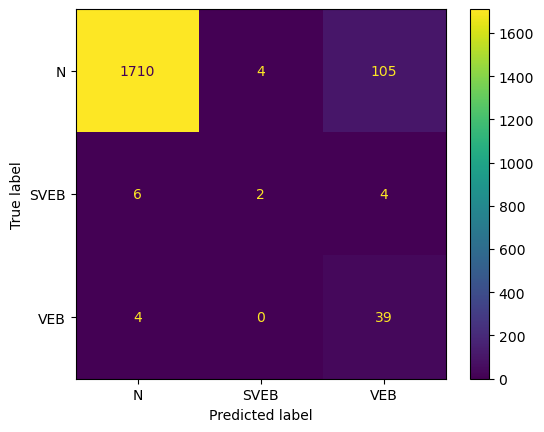

Fold 12:
  Test:  patient=11


C:\Users\matte\anaconda3\envs\DMML\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matte\anaconda3\envs\DMML\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matte\anaconda3\envs\DMML\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matte\anaconda3\envs\DMML\lib\site-packa

              precision    recall  f1-score   support

         0.0       1.00      0.96      0.98      1952
         1.0       0.00      0.00      0.00         0

    accuracy                           0.96      1952
   macro avg       0.50      0.48      0.49      1952
weighted avg       1.00      0.96      0.98      1952

                   0.0  1.0  accuracy    macro avg  weighted avg
precision     1.000000  0.0   0.95543     0.500000      1.000000
recall        0.955430  NaN   0.95543     0.477715      0.955430
f1-score      0.977207  NaN   0.95543     0.488604      0.977207
support    1952.000000  0.0   0.95543  1952.000000   1952.000000


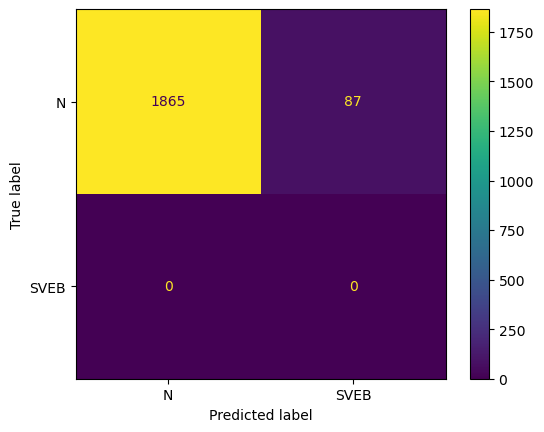

Fold 13:
  Test:  patient=12
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      2301
         1.0       0.04      1.00      0.07         1
         2.0       0.98      0.82      0.89       109

    accuracy                           0.99      2411
   macro avg       0.67      0.94      0.65      2411
weighted avg       1.00      0.99      0.99      2411

                   0.0       1.0         2.0  accuracy    macro avg  \
precision     0.999564  0.035714    0.978022  0.987557     0.671100   
recall        0.995654  1.000000    0.816514  0.987557     0.937389   
f1-score      0.997605  0.068966    0.890000  0.987557     0.652190   
support    2301.000000  1.000000  109.000000  0.987557  2411.000000   

           weighted avg  
precision      0.998190  
recall         0.987557  
f1-score       0.992355  
support     2411.000000  


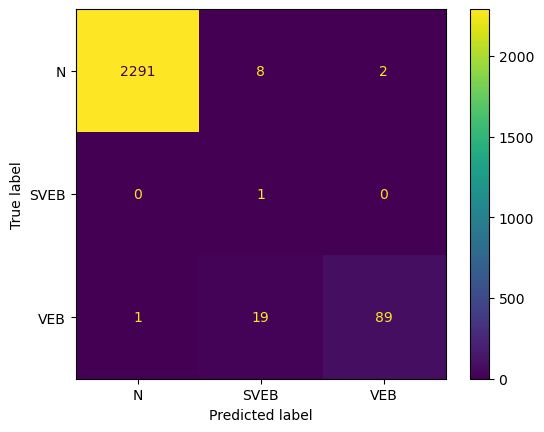

Fold 14:
  Test:  patient=13


C:\Users\matte\anaconda3\envs\DMML\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matte\anaconda3\envs\DMML\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matte\anaconda3\envs\DMML\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matte\anaconda3\envs\DMML\lib\site-packa

              precision    recall  f1-score   support

         0.0       1.00      0.97      0.98      1533
         1.0       0.02      1.00      0.04         1
         2.0       0.00      0.00      0.00         0

    accuracy                           0.97      1534
   macro avg       0.34      0.66      0.34      1534
weighted avg       1.00      0.97      0.98      1534

                   0.0       1.0  2.0  accuracy    macro avg  weighted avg
precision     1.000000  0.018868  0.0   0.96545     0.339623      0.999360
recall        0.965427  1.000000  NaN   0.96545     0.655142      0.965450
f1-score      0.982410  0.037037  NaN   0.96545     0.339816      0.981793
support    1533.000000  1.000000  0.0   0.96545  1534.000000   1534.000000


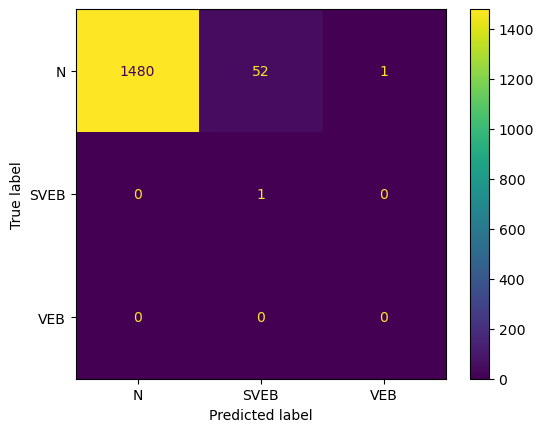

Fold 15:
  Test:  patient=14
              precision    recall  f1-score   support

         0.0       0.98      0.88      0.93      2165
         1.0       0.51      0.31      0.39        96
         2.0       0.02      0.38      0.04        16

    accuracy                           0.86      2277
   macro avg       0.50      0.52      0.45      2277
weighted avg       0.96      0.86      0.90      2277

                   0.0        1.0        2.0  accuracy    macro avg  \
precision     0.983060   0.508475   0.022222  0.856829     0.504585   
recall        0.884527   0.312500   0.375000  0.856829     0.524009   
f1-score      0.931194   0.387097   0.041958  0.856829     0.453416   
support    2165.000000  96.000000  16.000000  0.856829  2277.000000   

           weighted avg  
precision      0.956299  
recall         0.856829  
f1-score       0.902006  
support     2277.000000  


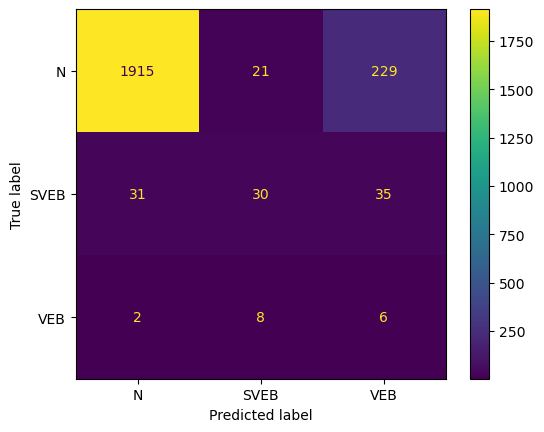

Fold 16:
  Test:  patient=15
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      1542
         1.0       0.00      0.00      0.00         0
         2.0       1.00      1.00      1.00       444

    accuracy                           1.00      1986
   macro avg       0.67      0.66      0.67      1986
weighted avg       1.00      1.00      1.00      1986

                   0.0  1.0         2.0  accuracy    macro avg  weighted avg
precision     1.000000  0.0    1.000000  0.996979     0.666667      1.000000
recall        0.996757  NaN    0.997748  0.996979     0.664835      0.996979
f1-score      0.998376  NaN    0.998873  0.996979     0.665750      0.998487
support    1542.000000  0.0  444.000000  0.996979  1986.000000   1986.000000


C:\Users\matte\anaconda3\envs\DMML\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matte\anaconda3\envs\DMML\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matte\anaconda3\envs\DMML\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matte\anaconda3\envs\DMML\lib\site-packa

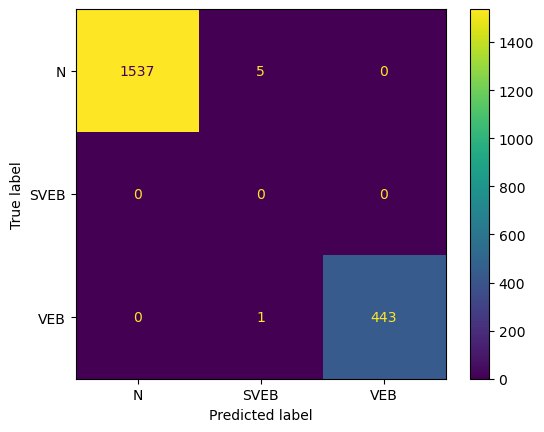

Fold 17:
  Test:  patient=16
              precision    recall  f1-score   support

         0.0       1.00      0.83      0.90      1860
         1.0       0.00      1.00      0.01         1
         2.0       0.50      1.00      0.67         1

    accuracy                           0.83      1862
   macro avg       0.50      0.94      0.53      1862
weighted avg       1.00      0.83      0.90      1862

                   0.0       1.0       2.0  accuracy    macro avg  \
precision     1.000000  0.003086  0.500000  0.825994     0.501029   
recall        0.825806  1.000000  1.000000  0.825994     0.941935   
f1-score      0.904594  0.006154  0.666667  0.825994     0.525805   
support    1860.000000  1.000000  1.000000  0.825994  1862.000000   

           weighted avg  
precision      0.999196  
recall         0.825994  
f1-score       0.903983  
support     1862.000000  


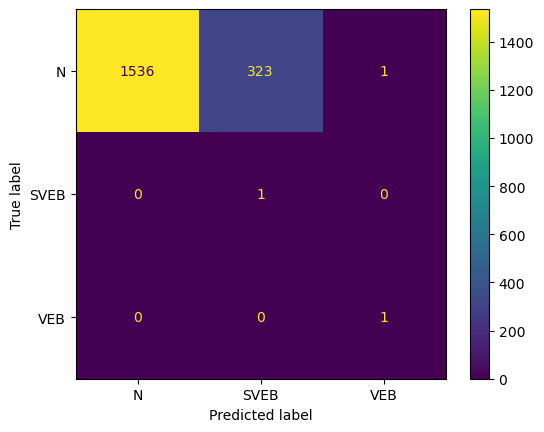

Fold 18:
  Test:  patient=17
              precision    recall  f1-score   support

         0.0       1.00      0.77      0.87      2475
         1.0       0.00      0.00      0.00         0
         2.0       0.00      0.00      0.00         0

    accuracy                           0.77      2475
   macro avg       0.33      0.26      0.29      2475
weighted avg       1.00      0.77      0.87      2475

                   0.0  1.0  2.0  accuracy    macro avg  weighted avg
precision     1.000000  0.0  0.0  0.767677     0.333333      1.000000
recall        0.767677  NaN  NaN  0.767677     0.255892      0.767677
f1-score      0.868571  NaN  NaN  0.767677     0.289524      0.868571
support    2475.000000  0.0  0.0  0.767677  2475.000000   2475.000000


C:\Users\matte\anaconda3\envs\DMML\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matte\anaconda3\envs\DMML\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matte\anaconda3\envs\DMML\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matte\anaconda3\envs\DMML\lib\site-packa

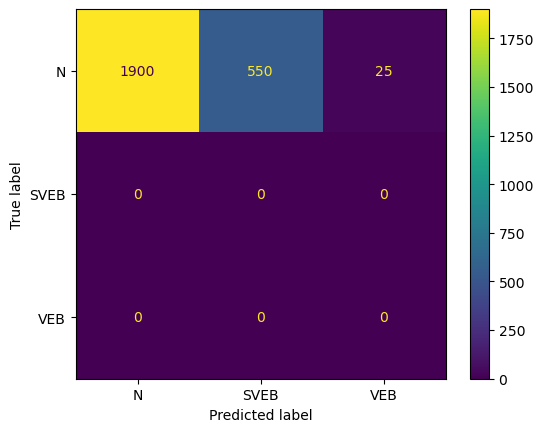

Fold 19:
  Test:  patient=18
              precision    recall  f1-score   support

         0.0       1.00      0.84      0.92      1514
         1.0       0.00      0.00      0.00         0
         2.0       0.00      0.00      0.00         3

    accuracy                           0.84      1517
   macro avg       0.33      0.28      0.31      1517
weighted avg       1.00      0.84      0.91      1517

                   0.0  1.0  2.0  accuracy    macro avg  weighted avg
precision     1.000000  0.0  NaN  0.842452     0.333333      0.998022
recall        0.844122  NaN  0.0  0.842452     0.281374      0.842452
f1-score      0.915473  NaN  NaN  0.842452     0.305158      0.913662
support    1514.000000  0.0  3.0  0.842452  1517.000000   1517.000000


C:\Users\matte\anaconda3\envs\DMML\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matte\anaconda3\envs\DMML\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matte\anaconda3\envs\DMML\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matte\anaconda3\envs\DMM

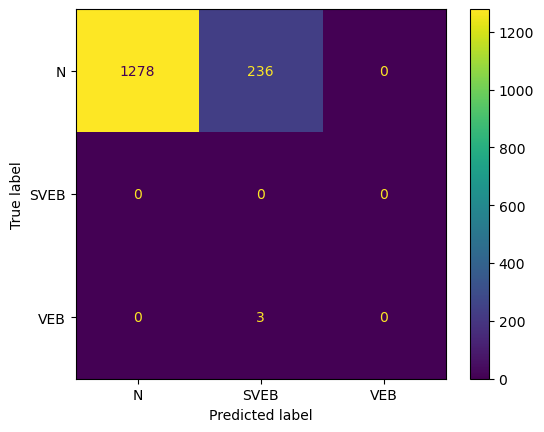

Fold 20:
  Test:  patient=19
              precision    recall  f1-score   support

         0.0       0.98      0.41      0.57      1535
         1.0       0.00      0.00      0.00        31
         2.0       0.03      0.68      0.06        47

    accuracy                           0.41      1613
   macro avg       0.34      0.36      0.21      1613
weighted avg       0.93      0.41      0.55      1613

                   0.0   1.0        2.0  accuracy    macro avg  weighted avg
precision     0.979592   0.0   0.033299  0.406696     0.337630      0.933192
recall        0.406515   0.0   0.680851  0.406696     0.362455      0.406696
f1-score      0.574586   0.0   0.063492  0.406696     0.212693      0.548650
support    1535.000000  31.0  47.000000  0.406696  1613.000000   1613.000000


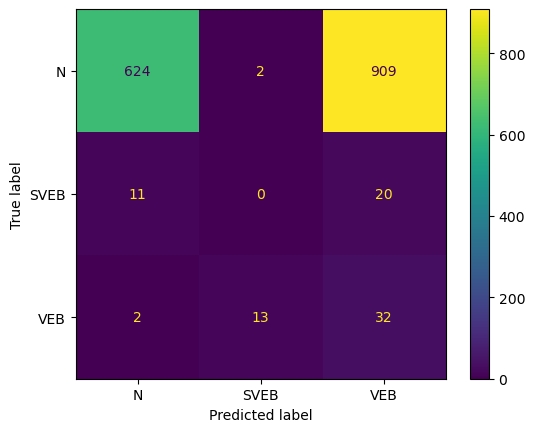

Fold 21:
  Test:  patient=20
              precision    recall  f1-score   support

         0.0       0.98      0.91      0.94      1742
         1.0       0.06      0.37      0.10        30
         2.0       0.99      0.95      0.97       826

    accuracy                           0.92      2598
   macro avg       0.68      0.74      0.67      2598
weighted avg       0.97      0.92      0.94      2598

                   0.0        1.0         2.0  accuracy    macro avg  \
precision     0.981436   0.056995    0.993663  0.916474     0.677364   
recall        0.910448   0.366667    0.949153  0.916474     0.742089   
f1-score      0.944610   0.098655    0.970898  0.916474     0.671387   
support    1742.000000  30.000000  826.000000  0.916474  2598.000000   

           weighted avg  
precision      0.974648  
recall         0.916474  
f1-score       0.943199  
support     2598.000000  


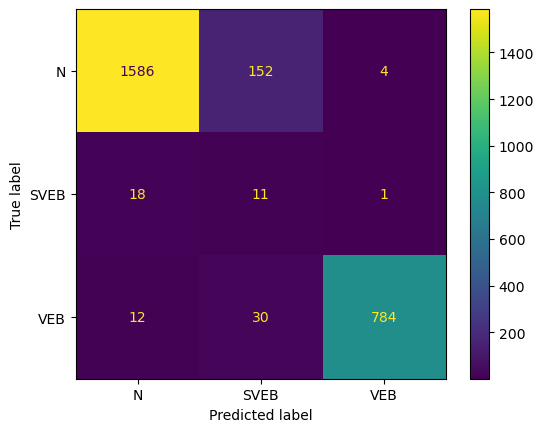

Fold 22:
  Test:  patient=21
              precision    recall  f1-score   support

         0.0       0.86      0.61      0.71      1634
         1.0       0.09      0.49      0.15       128
         2.0       0.14      0.06      0.08       198

    accuracy                           0.54      1960
   macro avg       0.36      0.39      0.31      1960
weighted avg       0.73      0.54      0.61      1960

                   0.0         1.0         2.0  accuracy    macro avg  \
precision     0.855786    0.087866    0.141176  0.543878     0.361609   
recall        0.606487    0.492188    0.060606  0.543878     0.386427   
f1-score      0.709885    0.149112    0.084806  0.543878     0.314601   
support    1634.000000  128.000000  198.000000  0.543878  1960.000000   

           weighted avg  
precision      0.733446  
recall         0.543878  
f1-score       0.610118  
support     1960.000000  


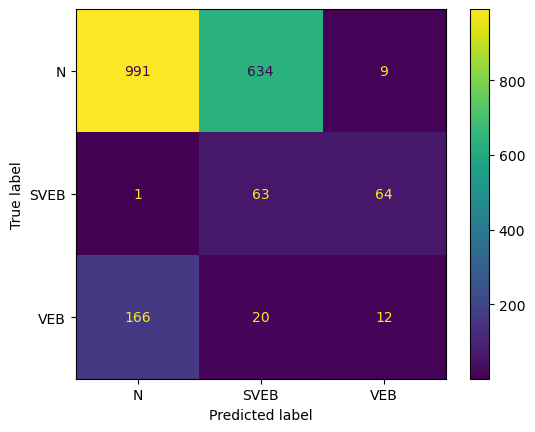

Fold 23:
  Test:  patient=22
              precision    recall  f1-score   support

         0.0       1.00      0.72      0.83      2060
         1.0       0.06      0.62      0.10        55
         2.0       0.24      0.63      0.35        19

    accuracy                           0.71      2134
   macro avg       0.43      0.66      0.43      2134
weighted avg       0.97      0.71      0.81      2134

                   0.0        1.0        2.0  accuracy    macro avg  \
precision     0.998648   0.056106   0.244898  0.713683     0.433217   
recall        0.716990   0.618182   0.631579  0.713683     0.655584   
f1-score      0.834699   0.102874   0.352941  0.713683     0.430172   
support    2060.000000  55.000000  19.000000  0.713683  2134.000000   

           weighted avg  
precision      0.967644  
recall         0.713683  
f1-score       0.811548  
support     2134.000000  


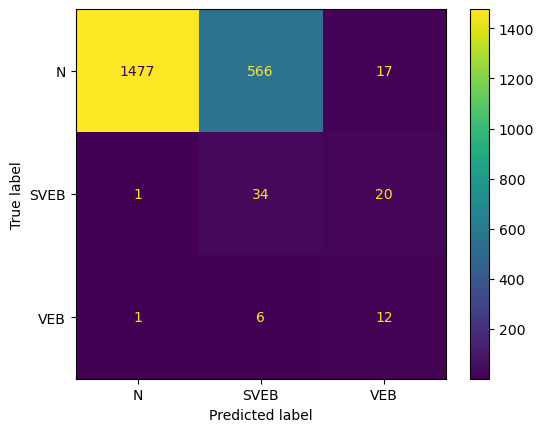

Fold 24:
  Test:  patient=23
              precision    recall  f1-score   support

         0.0       1.00      0.54      0.70      2528
         1.0       0.00      0.00      0.00         2
         2.0       0.31      0.94      0.47       444

    accuracy                           0.60      2974
   macro avg       0.44      0.49      0.39      2974
weighted avg       0.90      0.60      0.67      2974

                   0.0  1.0         2.0  accuracy    macro avg  weighted avg
precision     0.999268  0.0    0.313298  0.599193     0.437522      0.896185
recall        0.539953  0.0    0.939189  0.599193     0.493047      0.599193
f1-score      0.701079  0.0    0.469859  0.599193     0.390313      0.666087
support    2528.000000  2.0  444.000000  0.599193  2974.000000   2974.000000


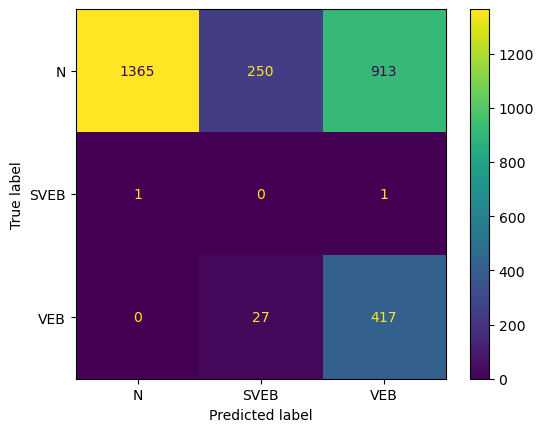

Fold 25:
  Test:  patient=24
              precision    recall  f1-score   support

         0.0       1.00      0.99      0.99      2570
         1.0       0.08      1.00      0.15         3
         2.0       0.98      0.89      0.93        71

    accuracy                           0.99      2644
   macro avg       0.69      0.96      0.69      2644
weighted avg       1.00      0.99      0.99      2644

                   0.0       1.0        2.0  accuracy    macro avg  \
precision     0.998428  0.083333   0.984375  0.985628     0.688712   
recall        0.988327  1.000000   0.887324  0.985628     0.958550   
f1-score      0.993352  0.153846   0.933333  0.985628     0.693510   
support    2570.000000  3.000000  71.000000  0.985628  2644.000000   

           weighted avg  
precision      0.997012  
recall         0.985628  
f1-score       0.990787  
support     2644.000000  


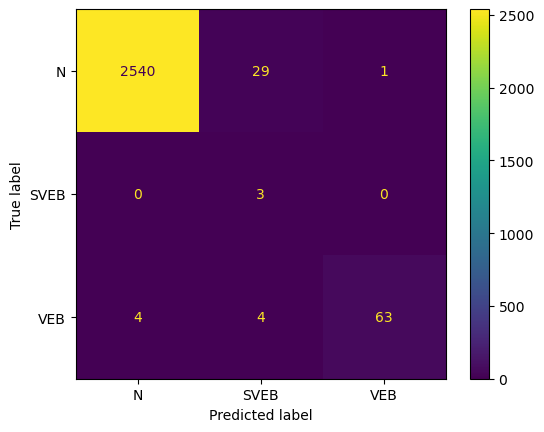

Fold 26:
  Test:  patient=25
              precision    recall  f1-score   support

         0.0       0.54      0.06      0.10      1543
         1.0       0.00      0.00      0.00       106
         2.0       0.08      0.65      0.14       210

    accuracy                           0.12      1859
   macro avg       0.21      0.23      0.08      1859
weighted avg       0.46      0.12      0.10      1859

                   0.0    1.0         2.0  accuracy    macro avg  weighted avg
precision     0.541401    0.0    0.080189  0.118881     0.207197      0.458430
recall        0.055087    0.0    0.647619  0.118881     0.234236      0.118881
f1-score      0.100000    0.0    0.142707  0.118881     0.080902      0.099122
support    1543.000000  106.0  210.000000  0.118881  1859.000000   1859.000000


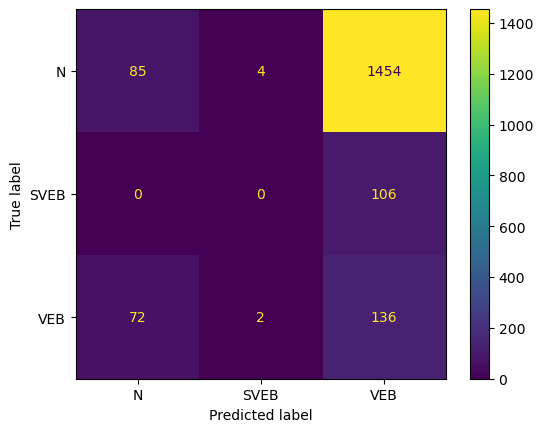

Fold 27:
  Test:  patient=26
              precision    recall  f1-score   support

         0.0       0.84      0.95      0.89      1585
         1.0       0.00      0.00      0.00         2
         2.0       0.99      0.37      0.54       992

    accuracy                           0.73      2579
   macro avg       0.61      0.44      0.48      2579
weighted avg       0.90      0.73      0.76      2579

                   0.0  1.0         2.0  accuracy    macro avg  weighted avg
precision     0.842546  0.0    0.986702  0.728965     0.609749      0.897342
recall        0.952050  0.0    0.373992  0.728965     0.442014      0.728965
f1-score      0.893957  0.0    0.542398  0.728965     0.478785      0.758038
support    1585.000000  2.0  992.000000  0.728965  2579.000000   2579.000000


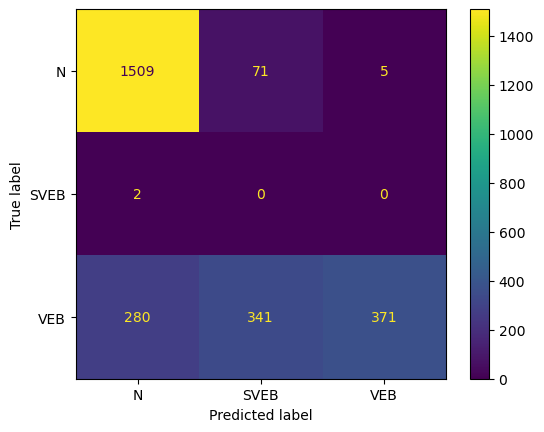

Fold 28:
  Test:  patient=27
              precision    recall  f1-score   support

         0.0       0.99      0.96      0.98      2620
         1.0       0.86      0.75      0.80       383
         2.0       0.01      1.00      0.01         1

    accuracy                           0.93      3004
   macro avg       0.62      0.90      0.60      3004
weighted avg       0.98      0.93      0.95      3004

                   0.0         1.0       2.0  accuracy    macro avg  \
precision     0.993683    0.861862  0.007246  0.933755     0.620931   
recall        0.960687    0.749347  1.000000  0.933755     0.903345   
f1-score      0.976907    0.801676  0.014388  0.933755     0.597657   
support    2620.000000  383.000000  1.000000  0.933755  3004.000000   

           weighted avg  
precision      0.976548  
recall         0.933755  
f1-score       0.954245  
support     3004.000000  


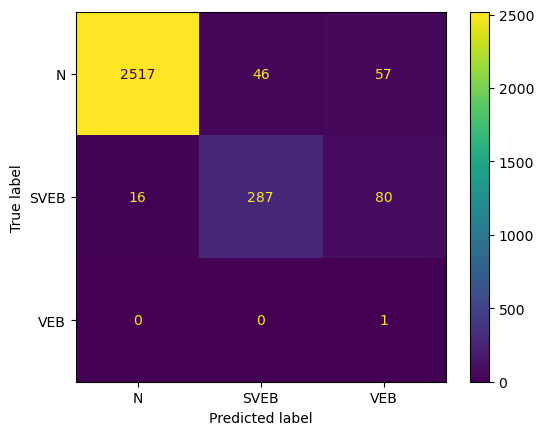

Fold 29:
  Test:  patient=28
              precision    recall  f1-score   support

         0.0       0.99      0.86      0.92      2422
         1.0       0.08      1.00      0.15        22
         2.0       0.41      0.58      0.48       195

    accuracy                           0.84      2639
   macro avg       0.49      0.81      0.52      2639
weighted avg       0.94      0.84      0.88      2639

                   0.0        1.0         2.0  accuracy    macro avg  \
precision     0.990909   0.080586    0.409420  0.835923     0.493638   
recall        0.855078   1.000000    0.579487  0.835923     0.811522   
f1-score      0.917996   0.149153    0.479830  0.835923     0.515660   
support    2422.000000  22.000000  195.000000  0.835923  2639.000000   

           weighted avg  
precision      0.940353  
recall         0.835923  
f1-score       0.879210  
support     2639.000000  


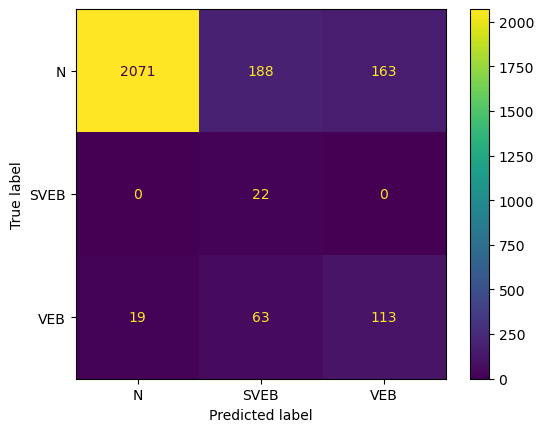

Fold 30:
  Test:  patient=29
              precision    recall  f1-score   support

         0.0       1.00      0.85      0.92      2747
         1.0       0.00      0.00      0.00         0
         2.0       0.00      0.00      0.00         0

    accuracy                           0.85      2747
   macro avg       0.33      0.28      0.31      2747
weighted avg       1.00      0.85      0.92      2747

                   0.0  1.0  2.0  accuracy    macro avg  weighted avg
precision     1.000000  0.0  0.0  0.852566     0.333333      1.000000
recall        0.852566  NaN  NaN  0.852566     0.284189      0.852566
f1-score      0.920417  NaN  NaN  0.852566     0.306806      0.920417
support    2747.000000  0.0  0.0  0.852566  2747.000000   2747.000000


C:\Users\matte\anaconda3\envs\DMML\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matte\anaconda3\envs\DMML\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matte\anaconda3\envs\DMML\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matte\anaconda3\envs\DMML\lib\site-packa

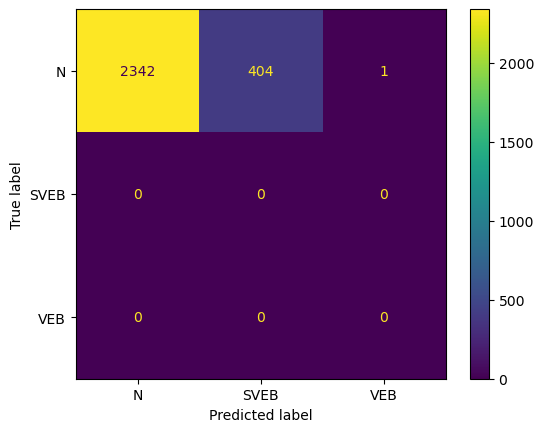

Fold 31:
  Test:  patient=30
              precision    recall  f1-score   support

         0.0       0.99      0.69      0.81      2640
         1.0       0.12      0.07      0.09        28
         2.0       0.18      0.86      0.30       220

    accuracy                           0.69      2888
   macro avg       0.43      0.54      0.40      2888
weighted avg       0.92      0.69      0.76      2888

                   0.0        1.0         2.0  accuracy    macro avg  \
precision     0.985294   0.117647    0.183575  0.692867     0.428839   
recall        0.685227   0.071429    0.863636  0.692867     0.540097   
f1-score      0.808311   0.088889    0.302789  0.692867     0.399996   
support    2640.000000  28.000000  220.000000  0.692867  2888.000000   

           weighted avg  
precision      0.915809  
recall         0.692867  
f1-score       0.762827  
support     2888.000000  


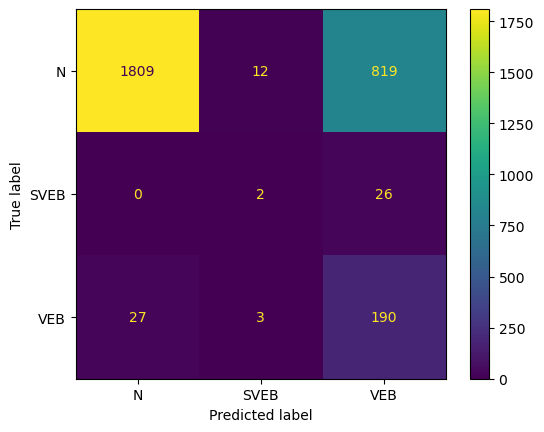

Fold 32:
  Test:  patient=31
              precision    recall  f1-score   support

         0.0       1.00      0.85      0.92      2002
         1.0       0.00      0.00      0.00         0
         2.0       0.41      0.77      0.53       256

    accuracy                           0.84      2258
   macro avg       0.47      0.54      0.48      2258
weighted avg       0.93      0.84      0.88      2258

                   0.0  1.0         2.0  accuracy    macro avg  weighted avg
precision     0.998243  0.0    0.405738  0.842338     0.467993      0.931067
recall        0.851149  NaN    0.773438  0.842338     0.541529      0.842338
f1-score      0.918846  NaN    0.532258  0.842338     0.483701      0.875017
support    2002.000000  0.0  256.000000  0.842338  2258.000000   2258.000000


C:\Users\matte\anaconda3\envs\DMML\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matte\anaconda3\envs\DMML\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matte\anaconda3\envs\DMML\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matte\anaconda3\envs\DMML\lib\site-packa

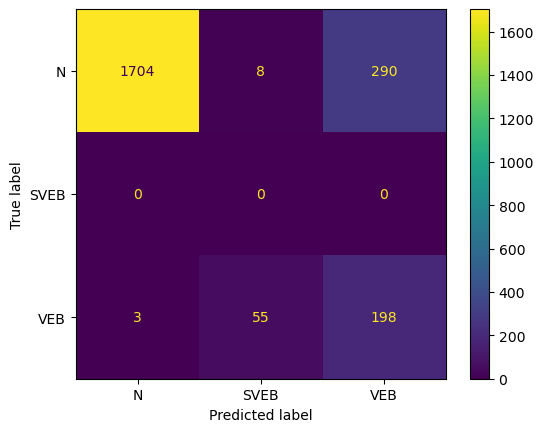

Fold 33:
  Test:  patient=32
              precision    recall  f1-score   support

         0.0       1.00      0.93      0.96      3194
         1.0       0.01      1.00      0.02         3
         2.0       0.90      0.82      0.86       164

    accuracy                           0.92      3361
   macro avg       0.64      0.92      0.62      3361
weighted avg       0.99      0.92      0.96      3361

                   0.0       1.0         2.0  accuracy    macro avg  \
precision     0.997641  0.012295    0.900000  0.921749     0.636645   
recall        0.926738  1.000000    0.823171  0.921749     0.916636   
f1-score      0.960883  0.024291    0.859873  0.921749     0.615016   
support    3194.000000  3.000000  164.000000  0.921749  3361.000000   

           weighted avg  
precision      0.991997  
recall         0.921749  
f1-score       0.955118  
support     3361.000000  


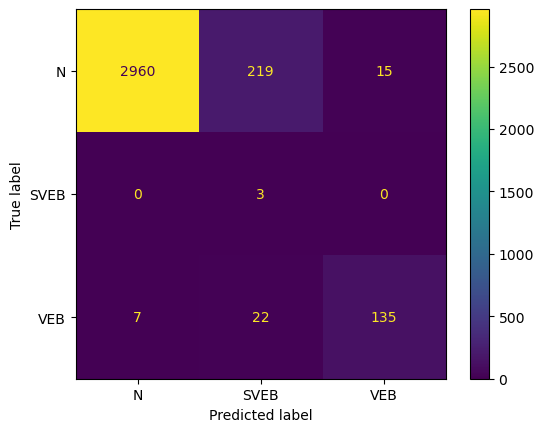

Fold 34:
  Test:  patient=33
              precision    recall  f1-score   support

         0.0       1.00      0.70      0.83      2081
         1.0       0.02      0.29      0.04         7
         2.0       0.10      0.88      0.17        64

    accuracy                           0.71      2152
   macro avg       0.37      0.62      0.34      2152
weighted avg       0.97      0.71      0.80      2152

                   0.0       1.0        2.0  accuracy    macro avg  \
precision     0.999317  0.018868   0.096220  0.706784     0.371468   
recall        0.703027  0.285714   0.875000  0.706784     0.621247   
f1-score      0.825388  0.035398   0.173375  0.706784     0.344720   
support    2081.000000  7.000000  64.000000  0.706784  2152.000000   

           weighted avg  
precision      0.969270  
recall         0.706784  
f1-score       0.803427  
support     2152.000000  


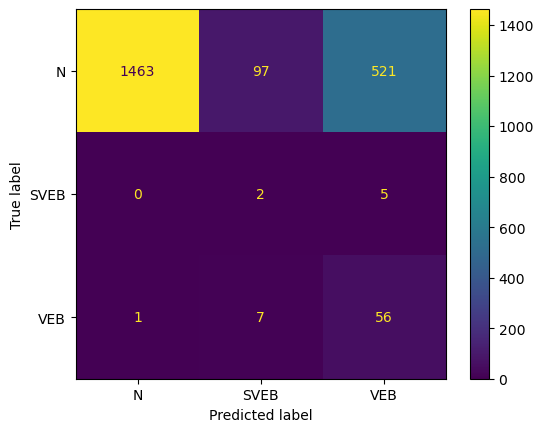

Fold 35:
  Test:  patient=34
              precision    recall  f1-score   support

         0.0       1.00      0.99      0.99      1953
         1.0       0.80      0.91      0.85        94
         2.0       0.00      0.00      0.00         0

    accuracy                           0.99      2047
   macro avg       0.60      0.63      0.62      2047
weighted avg       0.99      0.99      0.99      2047

                   0.0        1.0  2.0  accuracy    macro avg  weighted avg
precision     0.998965   0.796296  0.0  0.985344     0.598421      0.989659
recall        0.988735   0.914894  NaN  0.985344     0.634543      0.985344
f1-score      0.993824   0.851485  NaN  0.985344     0.615103      0.987288
support    1953.000000  94.000000  0.0  0.985344  2047.000000   2047.000000


C:\Users\matte\anaconda3\envs\DMML\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matte\anaconda3\envs\DMML\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matte\anaconda3\envs\DMML\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matte\anaconda3\envs\DMML\lib\site-packa

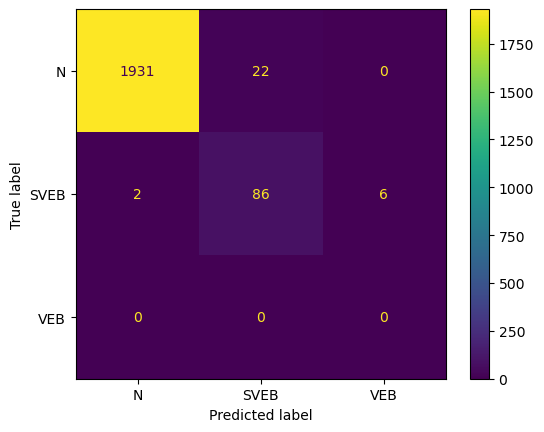

Fold 36:
  Test:  patient=35
              precision    recall  f1-score   support

         0.0       1.00      0.85      0.92      2030
         1.0       0.00      0.00      0.00         0
         2.0       1.00      0.95      0.97       396

    accuracy                           0.86      2426
   macro avg       0.67      0.60      0.63      2426
weighted avg       1.00      0.86      0.93      2426

                   0.0  1.0         2.0  accuracy    macro avg  weighted avg
precision     0.997676  0.0    1.000000  0.862737     0.665892      0.998055
recall        0.845813  NaN    0.949495  0.862737     0.598436      0.862737
f1-score      0.915489  NaN    0.974093  0.862737     0.629861      0.925055
support    2030.000000  0.0  396.000000  0.862737  2426.000000   2426.000000


C:\Users\matte\anaconda3\envs\DMML\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matte\anaconda3\envs\DMML\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matte\anaconda3\envs\DMML\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matte\anaconda3\envs\DMML\lib\site-packa

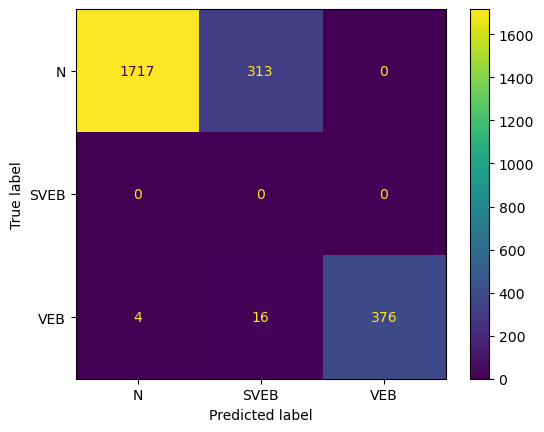

Fold 37:
  Test:  patient=36
              precision    recall  f1-score   support

         0.0       1.00      0.57      0.72      2273
         1.0       0.21      0.95      0.35       209
         2.0       0.00      0.00      0.00         0

    accuracy                           0.60      2482
   macro avg       0.40      0.51      0.36      2482
weighted avg       0.93      0.60      0.69      2482

                   0.0         1.0  2.0  accuracy    macro avg  weighted avg
precision     0.998456    0.211765  0.0  0.600725     0.403407      0.932211
recall        0.568852    0.947368  NaN  0.600725     0.505407      0.600725
f1-score      0.724776    0.346154  NaN  0.600725     0.356977      0.692893
support    2273.000000  209.000000  0.0  0.600725  2482.000000   2482.000000


C:\Users\matte\anaconda3\envs\DMML\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matte\anaconda3\envs\DMML\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matte\anaconda3\envs\DMML\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matte\anaconda3\envs\DMML\lib\site-packa

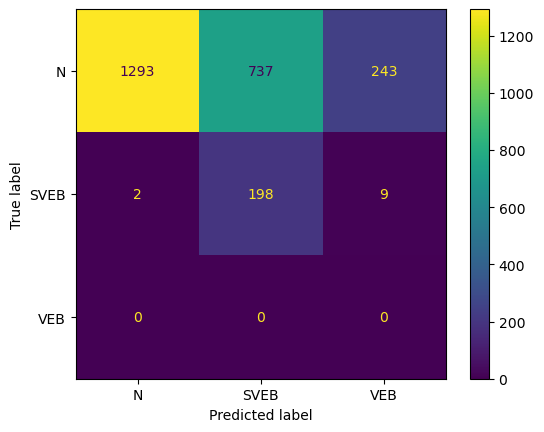

Fold 38:
  Test:  patient=37
              precision    recall  f1-score   support

         0.0       0.95      0.98      0.96      2044
         1.0       0.22      0.41      0.29        73
         2.0       0.88      0.62      0.72       473

    accuracy                           0.90      2590
   macro avg       0.68      0.67      0.66      2590
weighted avg       0.91      0.90      0.90      2590

                   0.0        1.0         2.0  accuracy    macro avg  \
precision     0.947195   0.220588    0.876877       0.9     0.681553   
recall        0.982877   0.410959    0.617336       0.9     0.670391   
f1-score      0.964706   0.287081    0.724566       0.9     0.658784   
support    2044.000000  73.000000  473.000000       0.9  2590.000000   

           weighted avg  
precision      0.913873  
recall         0.900000  
f1-score       0.901751  
support     2590.000000  


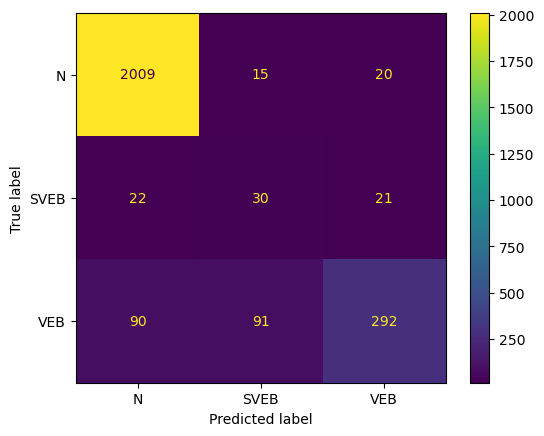

Fold 39:
  Test:  patient=38
              precision    recall  f1-score   support

         0.0       0.98      0.91      0.94      1687
         1.0       0.01      1.00      0.02         3
         2.0       1.00      0.44      0.61       362

    accuracy                           0.83      2052
   macro avg       0.66      0.78      0.52      2052
weighted avg       0.98      0.83      0.88      2052

                   0.0       1.0         2.0  accuracy    macro avg  \
precision     0.975222  0.009434    1.000000  0.827485     0.661552   
recall        0.909899  1.000000    0.441989  0.827485     0.783963   
f1-score      0.941429  0.018692    0.613027  0.827485     0.524382   
support    1687.000000  3.000000  362.000000  0.827485  2052.000000   

           weighted avg  
precision      0.978181  
recall         0.827485  
f1-score       0.882145  
support     2052.000000  


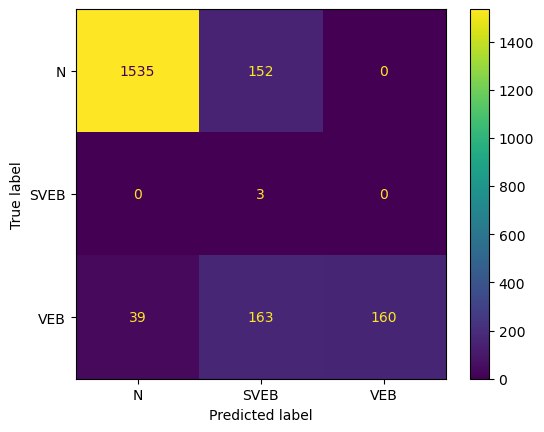

Fold 40:
  Test:  patient=39
              precision    recall  f1-score   support

         0.0       1.00      0.71      0.83      2254
         1.0       0.00      0.00      0.00         0
         2.0       0.00      1.00      0.01         1

    accuracy                           0.71      2255
   macro avg       0.33      0.57      0.28      2255
weighted avg       1.00      0.71      0.83      2255

                   0.0  1.0       2.0  accuracy    macro avg  weighted avg
precision     1.000000  0.0  0.002695  0.705987     0.334232      0.999558
recall        0.705856  NaN  1.000000  0.705987     0.568619      0.705987
f1-score      0.827568  NaN  0.005376  0.705987     0.277648      0.827204
support    2254.000000  0.0  1.000000  0.705987  2255.000000   2255.000000


C:\Users\matte\anaconda3\envs\DMML\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matte\anaconda3\envs\DMML\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matte\anaconda3\envs\DMML\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matte\anaconda3\envs\DMML\lib\site-packa

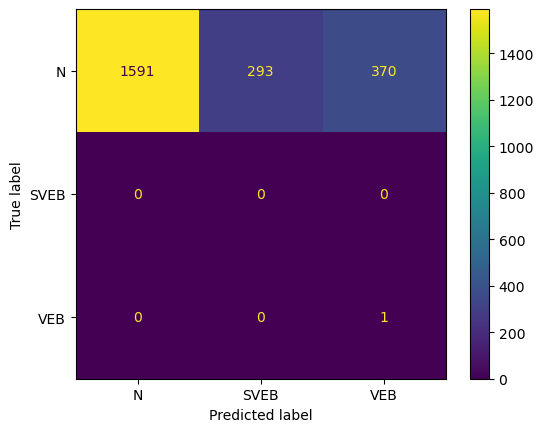

Fold 41:
  Test:  patient=40
              precision    recall  f1-score   support

         0.0       1.00      0.64      0.78      1567
         1.0       0.00      1.00      0.00         1
         2.0       1.00      0.50      0.67         2

    accuracy                           0.64      1570
   macro avg       0.67      0.71      0.48      1570
weighted avg       1.00      0.64      0.78      1570

                   0.0       1.0       2.0  accuracy    macro avg  \
precision     1.000000  0.001761  1.000000  0.638854     0.667254   
recall        0.638800  1.000000  0.500000  0.638854     0.712933   
f1-score      0.779595  0.003515  0.666667  0.638854     0.483259   
support    1567.000000  1.000000  2.000000  0.638854  1570.000000   

           weighted avg  
precision      0.999364  
recall         0.638854  
f1-score       0.778957  
support     1570.000000  


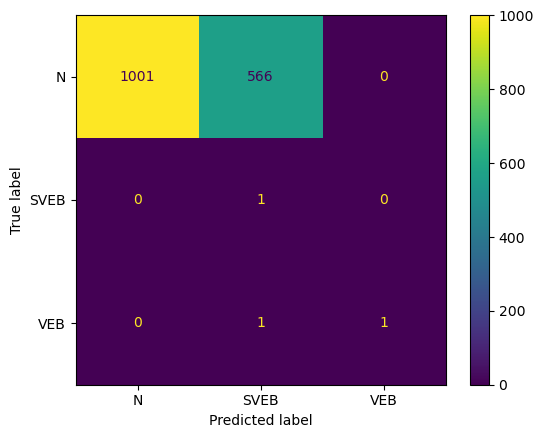

Fold 42:
  Test:  patient=41
              precision    recall  f1-score   support

         0.0       0.25      0.99      0.40       398
         1.0       0.98      0.14      0.25      1381
         2.0       0.00      0.00      0.00         0

    accuracy                           0.33      1779
   macro avg       0.41      0.38      0.22      1779
weighted avg       0.82      0.33      0.28      1779

                  0.0          1.0  2.0  accuracy    macro avg  weighted avg
precision    0.249841     0.980100  0.0  0.332209     0.409980      0.816725
recall       0.989950     0.142650  NaN  0.332209     0.377533      0.332209
f1-score     0.398987     0.249052  NaN  0.332209     0.216013      0.282596
support    398.000000  1381.000000  0.0  0.332209  1779.000000   1779.000000


C:\Users\matte\anaconda3\envs\DMML\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matte\anaconda3\envs\DMML\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matte\anaconda3\envs\DMML\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matte\anaconda3\envs\DMML\lib\site-packa

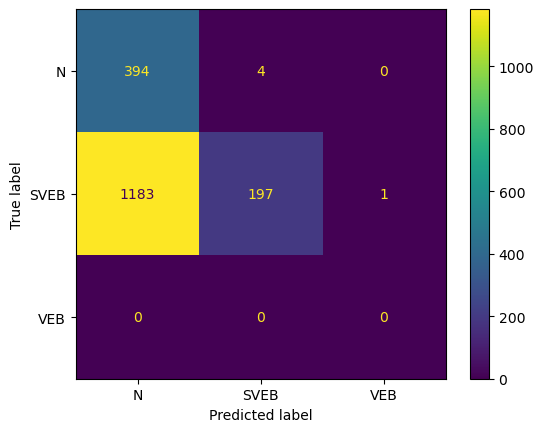

Fold 43:
  Test:  patient=42
              precision    recall  f1-score   support

         0.0       0.97      0.98      0.98      2229
         1.0       0.01      1.00      0.02         7
         2.0       1.00      0.03      0.07       831

    accuracy                           0.72      3067
   macro avg       0.66      0.67      0.35      3067
weighted avg       0.98      0.72      0.73      3067

                   0.0       1.0         2.0  accuracy    macro avg  \
precision     0.972816  0.008805    1.000000  0.723182     0.660540   
recall        0.979363  1.000000    0.033694  0.723182     0.671019   
f1-score      0.976079  0.017456    0.065192  0.723182     0.352909   
support    2229.000000  7.000000  831.000000  0.723182  3067.000000   

           weighted avg  
precision      0.977982  
recall         0.723182  
f1-score       0.727087  
support     3067.000000  


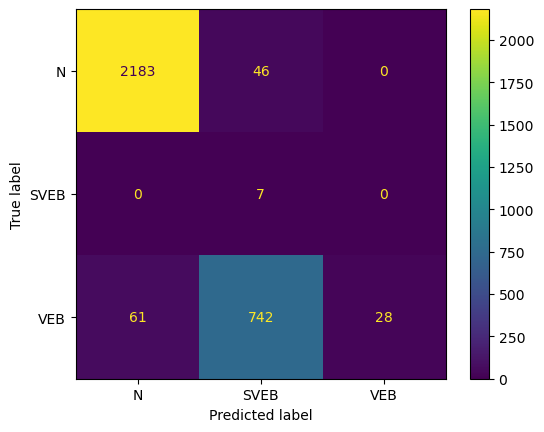

Fold 44:
  Test:  patient=43
              precision    recall  f1-score   support

         0.0       1.00      0.72      0.84      2699
         1.0       0.06      0.96      0.11        50
         2.0       1.00      0.33      0.50         3

    accuracy                           0.73      2752
   macro avg       0.69      0.67      0.48      2752
weighted avg       0.98      0.73      0.83      2752

                   0.0        1.0       2.0  accuracy    macro avg  \
precision     0.998978   0.060453  1.000000  0.728198     0.686477   
recall        0.724342   0.960000  0.333333  0.728198     0.672559   
f1-score      0.839777   0.113744  0.500000  0.728198     0.484507   
support    2699.000000  50.000000  3.000000  0.728198  2752.000000   

           weighted avg  
precision      0.981927  
recall         0.728198  
f1-score       0.826215  
support     2752.000000  


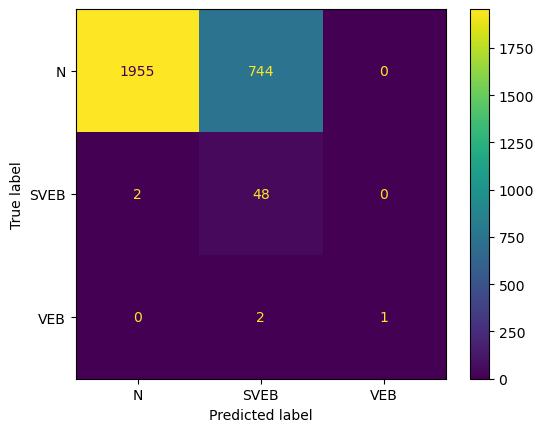

C:\Users\matte\anaconda3\envs\DMML\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\matte\anaconda3\envs\DMML\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [36]:
X=df_cardio.drop('type',axis=1)
y=df_cardio['type']
groups=df_cardio['patient']
skf = LeaveOneGroupOut()


start_time=time.time()
df_features19, acc_features19,confusion_matrix_final_19features,list_select_19 = cross_valid(pipe_select_19, skf, X, y,groups)
end_time=time.time()

In [37]:
df_features19

0.0        1.0         2.0    macro avg  weighted avg
f1-score      0.869095   0.163587    0.424841     0.443797      0.842732
precision     0.959423   0.135415    0.388522     0.494212      0.954463
recall        0.825361   0.593487    0.675799     0.605144      0.794390
support    2047.340909  63.159091  170.951220  2269.795455   2269.795455

In [38]:
confusion_matrix_final_19features

array([[74564.,  7432.,  8087.],
       [ 1299.,  1051.,   429.],
       [  896.,  1693.,  4420.]])

In [39]:
list_select_19

{'patient0': {'0.0': 0.9988816819503467,
  '1.0': 0.45454545454545453,
  '2.0': 0.0689655172413793,
  'macro avg': 0.5074642179123935,
  'weighted avg': 0.9905660958283966},
 'patient1': {'0.0': 0.9799835481217438,
  '1.0': 0.051948051948051945,
  'macro avg': 0.5159658000348979,
  'weighted avg': 0.9784883244436982},
 'patient2': {'0.0': 0.9954139512430605,
  '1.0': 0.18181818181818182,
  'macro avg': 0.3924107110204141,
  'weighted avg': 0.9946327743161045},
 'patient3': {'0.0': 0.9918245264207377,
  '2.0': 0.0,
  'macro avg': 0.33060817547357924,
  'weighted avg': 0.9759769794280446},
 'patient4': {'0.0': 0.9700483091787441,
  '2.0': 0.8936170212765957,
  'macro avg': 0.6212217768184466,
  'weighted avg': 0.9504311967853003},
 'patient5': {'0.0': 0.8479841374752148,
  '1.0': 0.28571428571428575,
  '2.0': 0.04517453798767967,
  'macro avg': 0.3929576537257267,
  'weighted avg': 0.8389518405443445},
 'patient6': {'0.0': 0.8902248942329103,
  '2.0': 0.1073345259391771,
  'macro avg': 0

In [40]:
print("Time"+str(end_time-start_time))

Time2765.228831768036


In [57]:
from utils import retrieve_fscore_avg,compare_plots

In [43]:
from scipy.stats import wilcoxon
list_normal=retrieve_fscore_avg(list_fscore)
list_smote=retrieve_fscore_avg(list_fscore_smote)
wilcoxon(list_normal, list_smote)

WilcoxonResult(statistic=268.0, pvalue=0.007309075703460621)

In [48]:
list_normal=retrieve_fscore_avg(list_fscore_PCA)
list_smote=retrieve_fscore_avg(list_fscore_smote)
wilcoxon(list_normal, list_smote)

WilcoxonResult(statistic=394.0, pvalue=0.2434992791543209)

In [49]:
list_normal=retrieve_fscore_avg(list_fscore)
list_smote=retrieve_fscore_avg(list_fscore_PCA)
wilcoxon(list_normal, list_smote)

WilcoxonResult(statistic=193.0, pvalue=0.00026013212880116043)

In [50]:
list_normal=retrieve_fscore_avg(list_select_30)
list_smote=retrieve_fscore_avg(list_fscore_smote)
wilcoxon(list_normal, list_smote)

WilcoxonResult(statistic=433.0, pvalue=0.4766892327322694)

In [55]:
list_normal=retrieve_fscore_avg(list_select_19)
list_smote=retrieve_fscore_avg(list_fscore_smote)
wilcoxon(list_normal, list_smote)

WilcoxonResult(statistic=483.0, pvalue=0.894310661280997)

In [54]:
list_normal=retrieve_fscore_avg(list_fscore)
list_smote=retrieve_fscore_avg(list_select_30)
wilcoxon(list_normal, list_smote)

WilcoxonResult(statistic=255.0, pvalue=0.0044332973145628785)

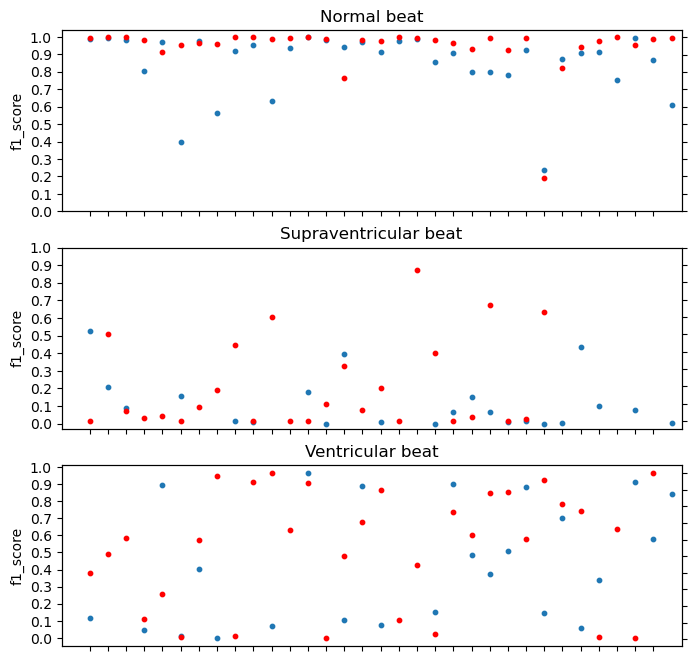

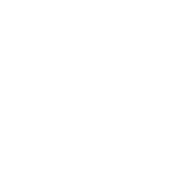

In [61]:
compare_plots(list_fscore,list_fscore_PCA)  #blu è quello a dx, rosso quello a sx

In [62]:
pd.DataFrame(list_fscore).to_csv('list_bestAB.csv')

In [63]:
import json

# export the dictionary to a JSON file
with open('bestAB.json', 'w') as f:
    json.dump(list_fscore, f)
